In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import catboost as cb
%matplotlib inline


In [2]:
work_path = Path.cwd()
print(work_path)

/Users/19282873/Desktop/hp perenos 2/DS обучение/project-master/MyPortfolio/plotly_dashboard/model


In [3]:
data_path = Path(work_path, 'sberbank-russian-housing-market', 'train.csv')
print(data_path)

/Users/19282873/Desktop/hp perenos 2/DS обучение/project-master/MyPortfolio/plotly_dashboard/model/sberbank-russian-housing-market/train.csv


In [4]:
## Load data into Python

df_train = pd.read_csv(Path(work_path, 'sberbank-russian-housing-market', 'train.csv'), parse_dates=['timestamp'])
df_test = pd.read_csv(Path(work_path, 'sberbank-russian-housing-market', 'test.csv'), parse_dates=['timestamp'])
df_macro = pd.read_csv(Path(work_path, 'sberbank-russian-housing-market', 'macro.csv'), parse_dates=['timestamp'])

In [5]:
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print("Macro shape:", df_macro.shape)


Train shape: (30471, 292)
Test shape: (7662, 291)
Macro shape: (2484, 100)


In [6]:
### Добавим в наши DF макропоказатели

# df_train = df_train.merge(df_macro, how = 'left', on = 'timestamp')
# df_test = df_test.merge(df_macro, how = 'left', on = 'timestamp')

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (30471, 292)
Test shape: (7662, 291)


In [7]:
# Посмотрим на данные
pd.set_option('display.max_columns', None)
df_train.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_c

<AxesSubplot:xlabel='price_doc', ylabel='Count'>

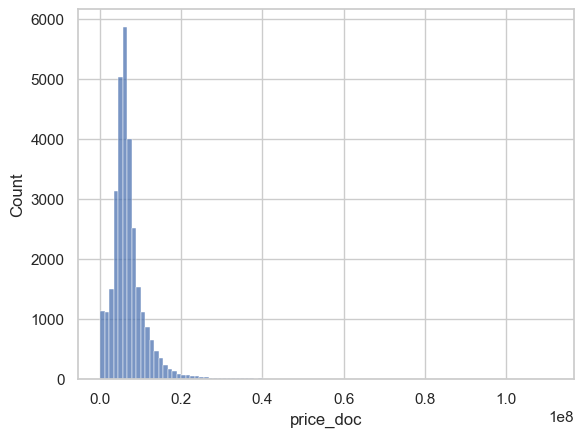

In [8]:
### Посмотрим на нашу целевую переменную
sns.set(style='whitegrid', color_codes=True)

sns.histplot(df_train, x = 'price_doc', bins = 100)

Есть выбросы. Попробуем логарифмировать.

<AxesSubplot:xlabel='price_doc', ylabel='Count'>

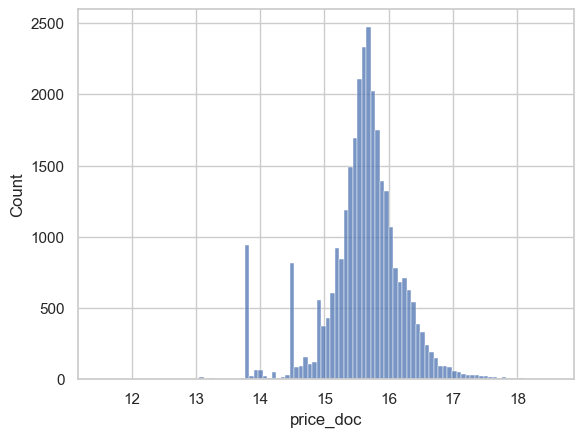

In [9]:
sns.set(style='whitegrid', color_codes=True)

sns.histplot(np.log(df_train['price_doc']), bins = 100)



In [10]:
# Отлично. Тогда добавим еще один столбец в df
df_train['price_doc_log'] = np.log(df_train['price_doc'])

In [11]:
### Поищим столбцы с годами или месяцами или днями
col = [x for x in df_train.columns.to_list() if 'year' in x or 'month' in x or 'day' in x]
col

['build_year']

In [12]:
## Оставим только столбец build_year и переведем в строку

df_train['build_year'] = df_train['build_year'].astype(float)
df_test['build_year'] = df_test['build_year'].astype(float)

In [13]:
# Уберем лишние
df_train['build_year'] = df_train['build_year'].apply(lambda x: x if x > 1000 and x < 2022 else np.nan)

Рассмотрим корреляцию целевого показателя с другими признаками

In [14]:
corrs = df_train.corr(method='pearson')['price_doc']

In [15]:
abs(corrs).sort_values()

trc_sqm_500                    0.000374
cafe_sum_3000_max_price_avg    0.002200
cafe_avg_price_3000            0.003339
cafe_sum_3000_min_price_avg    0.005119
prom_part_500                  0.009009
                                 ...   
sport_count_5000               0.294864
full_sq                        0.341840
num_room                       0.476337
price_doc_log                  0.829761
price_doc                      1.000000
Name: price_doc, Length: 277, dtype: float64

In [16]:
## Найдем корреляцию, где корреляция меньше 0.1
corrs[abs(corrs.values) < 0.1]

max_floor                      0.094386
material                       0.064047
build_year                     0.037858
kitch_sq                       0.028718
green_zone_part               -0.094486
                                 ...   
mosque_count_3000              0.096199
prom_part_5000                 0.087792
cafe_sum_5000_min_price_avg    0.032183
cafe_sum_5000_max_price_avg    0.033343
cafe_avg_price_5000            0.032920
Name: price_doc, Length: 100, dtype: float64

Таких признаков около 160. Попробуем их удалить, чтобы не создавать шум

In [17]:
col_del = corrs[abs(corrs.values) < 0.1].index.to_list()

In [18]:
print('PREV df_trian ' + str(df_train.shape))
print('PREV df_test ' + str(df_test.shape))

df_train.drop(col_del, axis=1, inplace=True)
df_test.drop(col_del, axis=1, inplace=True)

print('AFTER df_trian ' + str(df_train.shape))
print('AFTER df_test ' + str(df_test.shape))

PREV df_trian (30471, 293)
PREV df_test (7662, 291)
AFTER df_trian (30471, 193)
AFTER df_test (7662, 191)


In [19]:
# Найдем топ 5 признаков
abs(corrs).sort_values(ascending = False).head(20)

price_doc                     1.000000
price_doc_log                 0.829761
num_room                      0.476337
full_sq                       0.341840
sport_count_5000              0.294864
sport_count_3000              0.290651
trc_count_5000                0.289371
zd_vokzaly_avto_km            0.284069
sadovoe_km                    0.283622
kremlin_km                    0.279249
bulvar_ring_km                0.279158
sport_count_2000              0.278056
ttk_km                        0.272620
office_sqm_5000               0.269977
trc_sqm_5000                  0.268072
sport_count_1500              0.258376
nuclear_reactor_km            0.257946
sport_objects_raion           0.252794
trc_count_3000                0.242068
cafe_count_5000_price_1000    0.240464
Name: price_doc, dtype: float64

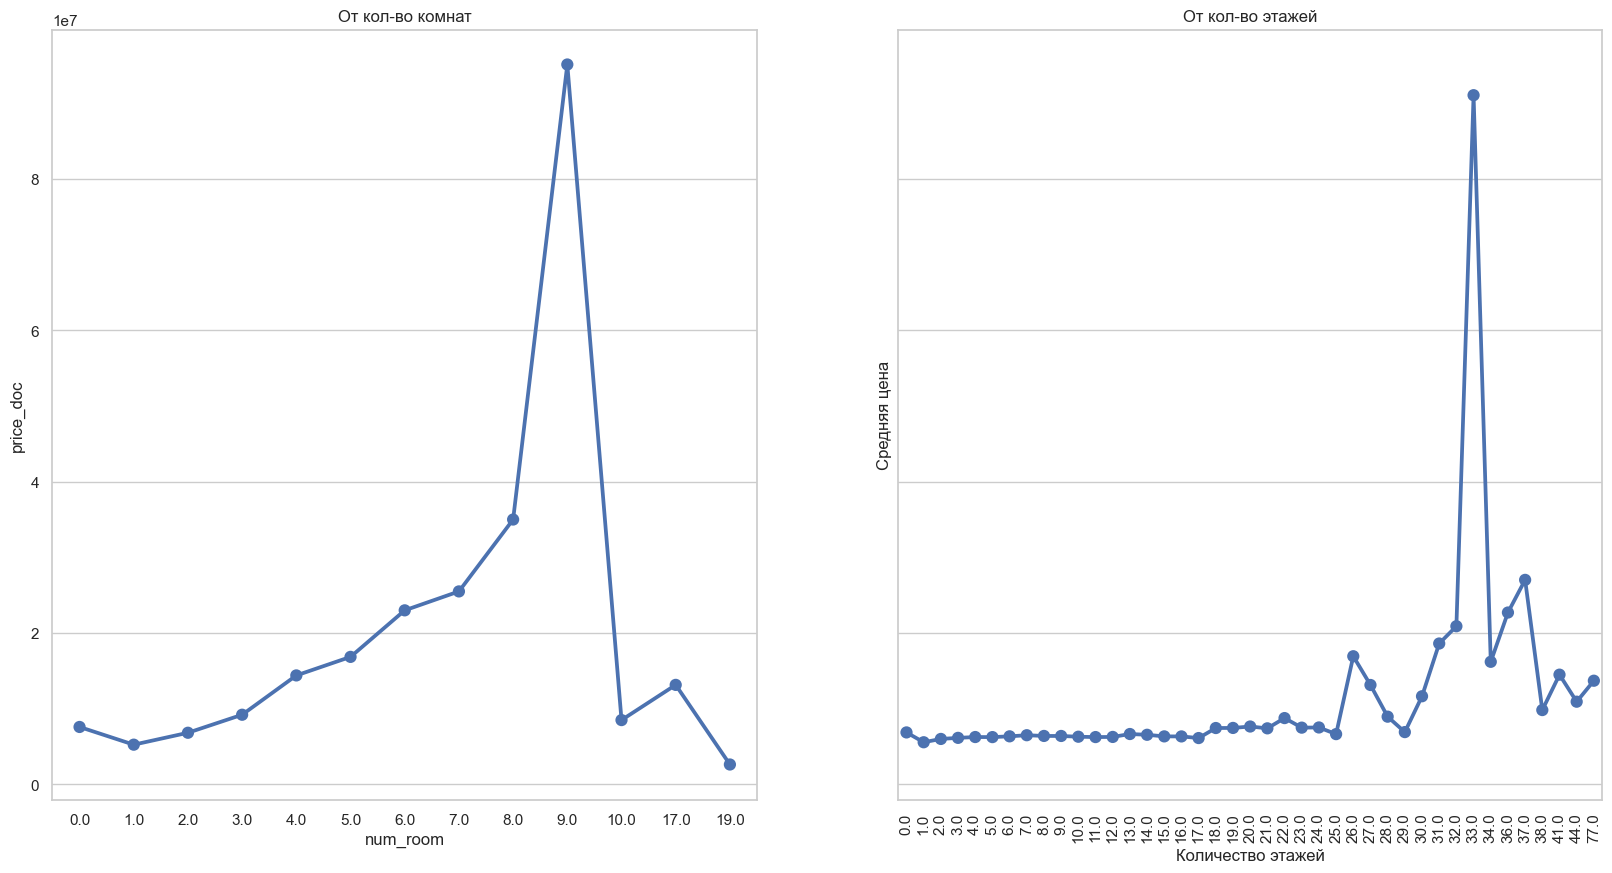

In [20]:
## посмотрим на графики
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

temp_df = df_train.groupby(['num_room'])['price_doc'].aggregate(np.median).reset_index()
# plt.figure(figsize=(8, 5))
sns.pointplot(ax=axes[0],x='num_room', y='price_doc', data=temp_df)
axes[0].set_title('От кол-во комнат')
plt.ylabel('Средняя цена', fontsize=12)
plt.xlabel('Количество комнат', fontsize=12)
plt.xticks(rotation='vertical')
# plt.show()

temp_df = df_train.groupby(['floor'])['price_doc'].aggregate(np.median).reset_index()
sns.pointplot(ax=axes[1],x='floor', y='price_doc', data=temp_df)
axes[1].set_title('От кол-во этажей')
plt.ylabel('Средняя цена', fontsize=12)
plt.xlabel('Количество этажей', fontsize=12)
plt.xticks(rotation='vertical')

plt.show()

Видим выброс на кол-ве этажей

In [21]:
df_train[(df_train['floor']) == 33]

,id,timestamp,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,mosque_count_2000,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,price_doc_log
7457,7460,2013-04-19,185,66.0,33.0,NaN,NaN,Investment,Ramenki,18800000.1,125111,8371,8,7687,8,0,176.0,5,1,12,yes,5,11,no,no,no,yes,no,no,no,no,16928,8715,8213,79011,41069,37942,29172,8989,20183,8371,4356,4015,7687,3937,3750,19215,9989,9226,15224,7873,7351,99.0,38.0,3.721862,2.800055,30.224681,2.518723,0.543921,0.883583,1.768784,6.08951,73.074126,5.184264,6.521758,0.379486,4.553832,no,2.686379,5.397897,6.542679,7.424229,1.908287,no,2.686379,no,6.189938,12.936044,16.266346,5.131717,1.499882,2.50353,3.824673,4.421095,6.043965,0.104265,0.485134,6.190541,6.046

Такое одно значение. Значит удаляем

In [22]:
## Посмотрим на кол-во комнат
df_train[(df_train['num_room']) == 9][['num_room','price_doc','price_doc_log']]

,num_room,price_doc,price_doc_log
28326,9.0,95122496,18.370676


In [23]:
## Тоже удаляем
print(df_train.shape)
df_train.drop(df_train.index[[28326,7457,18990]], inplace=True)
print(df_train.shape)

(30471, 193)
(30468, 193)


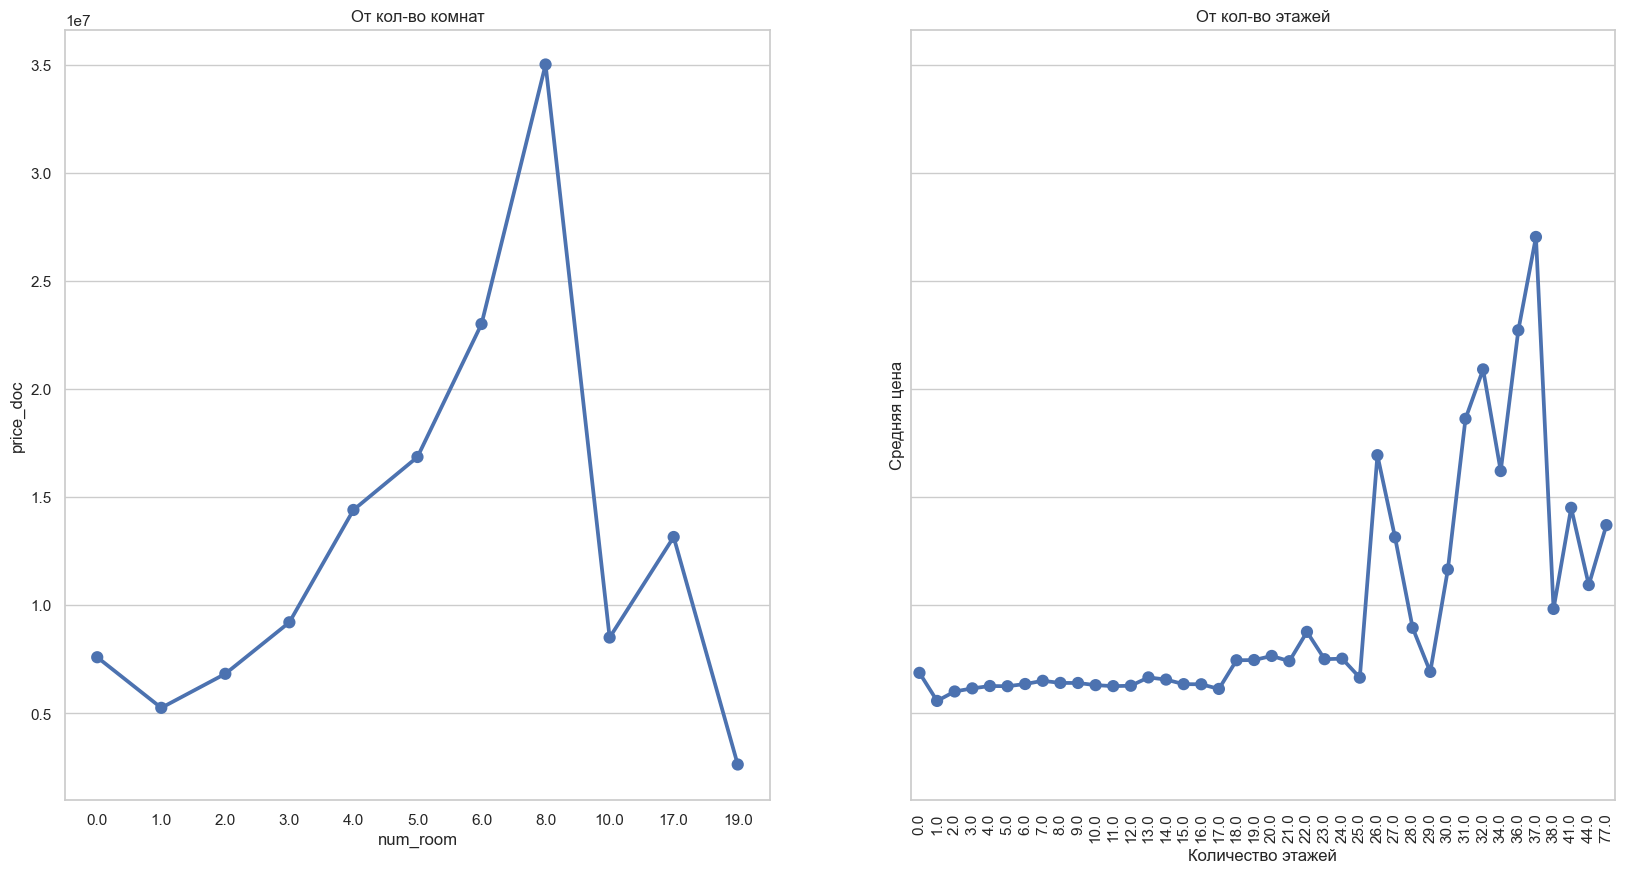

In [24]:
## посмотрим на графики теперь
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

temp_df = df_train.groupby(['num_room'])['price_doc'].aggregate(np.median).reset_index()
# plt.figure(figsize=(8, 5))
sns.pointplot(ax=axes[0],x='num_room', y='price_doc', data=temp_df)
axes[0].set_title('От кол-во комнат')
plt.ylabel('Средняя цена', fontsize=12)
plt.xlabel('Количество комнат', fontsize=12)
plt.xticks(rotation='vertical')
# plt.show()

temp_df = df_train.groupby(['floor'])['price_doc'].aggregate(np.median).reset_index()
sns.pointplot(ax=axes[1],x='floor', y='price_doc', data=temp_df)
axes[1].set_title('От кол-во этажей')
plt.ylabel('Средняя цена', fontsize=12)
plt.xlabel('Количество этажей', fontsize=12)
plt.xticks(rotation='vertical')

plt.show()

Посмотрим как изменялась цена по году и месяцу

In [25]:
df_train['timestamp'][0:3]


0   2011-08-20
1   2011-08-23
2   2011-08-27
Name: timestamp, dtype: datetime64[ns]

In [26]:
df_train['year'] = df_train['timestamp'].astype(str).apply(lambda x: x[:4]).astype(int)
df_train['month'] = df_train['timestamp'].astype(str).apply(lambda x: x[5:7]).astype(int)
# df_train['month_year'] = df_train['month'].astype(str) + '_' + df_train['year'].astype(str)

df_test['year'] = df_test['timestamp'].astype(str).apply(lambda x: x[:4]).astype(int)
df_test['month'] = df_test['timestamp'].astype(str).apply(lambda x: x[5:7]).astype(int)
# df_test['month_year'] = df_test['month'].astype(str) + '_' + df_train['year'].astype(str)

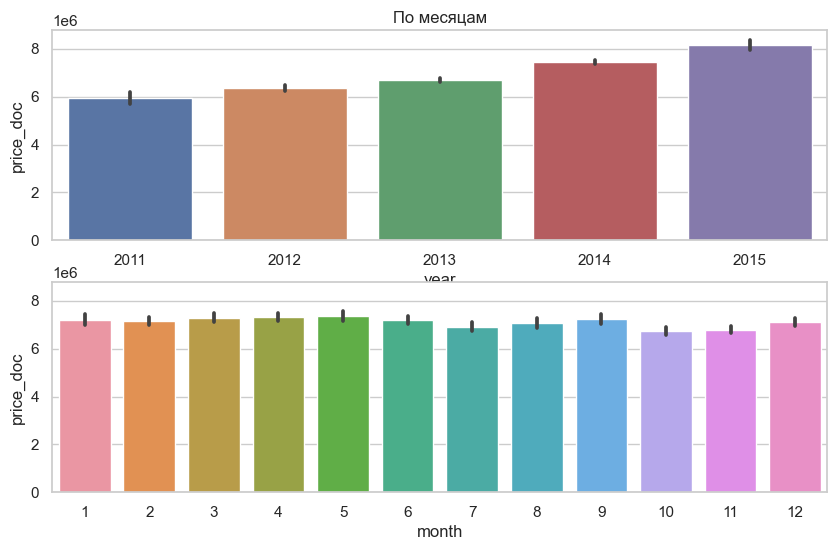

In [27]:
# fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
fig, ax = plt.subplots(2, 1, figsize=(10,6), sharey=True)
sns.barplot(ax=ax[0],x='year', y='price_doc', data=df_train)
ax[0].set_title('По годам')
sns.barplot(ax=ax[1],x='month', y='price_doc', data=df_train)
ax[0].set_title('По месяцам')
plt.show()

In [28]:
## Посмотрим на пропуски
missingValues = df_train.columns[df_train.isna().any()].tolist()
pd.isnull(df_train[missingValues]).sum().sort_values(ascending=False)

hospital_beds_raion            14441
state                          13558
num_room                        9571
life_sq                         6383
build_count_brick               4991
build_count_monolith            4991
cafe_sum_1500_min_price_avg     4199
cafe_sum_1500_max_price_avg     4199
cafe_avg_price_1500             4199
cafe_sum_2000_max_price_avg     1725
cafe_avg_price_2000             1725
floor                            167
metro_min_walk                    25
metro_km_walk                     25
railroad_station_walk_km          25
railroad_station_walk_min         25
dtype: int64

In [29]:
### Качественные пропущенные переменные заменим на часто встречающиеся
### Количественные пропущенные заменим на среднее значение

col_categ_train = df_train.dtypes[df_train.dtypes == "object"].index.to_list()
col_categ_test = df_test.dtypes[df_test.dtypes == "object"].index.to_list()

col_count_train = df_train.dtypes[(df_train.dtypes != "object") & (df_train.dtypes != "datetime64[ns]")].index.to_list()
col_count_test = df_test.dtypes[(df_test.dtypes != "object") & (df_test.dtypes != "datetime64[ns]")].index.to_list()

print("Кол-во количественных признаков: ", len(col_count_train))
print("Кол-во категориальных признаков: ", len(col_categ_train))


Кол-во количественных признаков:  179
Кол-во категориальных признаков:  15


In [30]:
print('PREV df_train ' + str(df_train.shape))
print('PREV df_test ' + str(df_test.shape))
df_train.drop(['id', 'price_doc', 'timestamp'], axis=1, inplace=True)
id_test = df_test['id']
df_test.drop(['id', 'timestamp'], axis=1, inplace=True)
print('AFTER df_train ' + str(df_train.shape))
print('AFTER df_test ' + str(df_test.shape))

PREV df_train (30468, 195)
PREV df_test (7662, 193)
AFTER df_train (30468, 192)
AFTER df_test (7662, 191)


In [31]:
### Качественные пропущенные переменные заменим на часто встречающиеся
### Количественные пропущенные заменим на среднее значение

col_categ_train = df_train.dtypes[df_train.dtypes == "object"].index.to_list()
col_categ_test = df_test.dtypes[df_test.dtypes == "object"].index.to_list()

col_count_train = df_train.dtypes[(df_train.dtypes != "object") & (df_train.dtypes != "datetime64[ns]")].index.to_list()
col_count_test = df_test.dtypes[(df_test.dtypes != "object") & (df_test.dtypes != "datetime64[ns]")].index.to_list()

print("Кол-во количественных признаков: ", len(col_count_train))
print("Кол-во категориальных признаков: ", len(col_categ_train))


Кол-во количественных признаков:  177
Кол-во категориальных признаков:  15


In [32]:
# df_train_prev = df_train.copy()
# df_test_prev = df_test.copy()

In [33]:
# df_test = df_test_prev.copy()
# df_train = df_train_prev.copy()

In [34]:
df_train = df_train.reset_index()
df_train.drop('index', axis=1, inplace=True)

In [35]:
imp_freq = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_train[col_categ_train] = pd.DataFrame(imp_freq.fit_transform(df_train[col_categ_train]))

In [36]:
df_train[col_count_train] = df_train[col_count_train].apply(lambda x: x.fillna(x.mean()),axis=0)

In [37]:
df_train.isna().sum().sort_values(ascending=False)

full_sq                        0
life_sq                        0
cafe_count_1500                0
cafe_sum_1500_min_price_avg    0
cafe_sum_1500_max_price_avg    0
                              ..
ttk_km                         0
sadovoe_km                     0
bulvar_ring_km                 0
kremlin_km                     0
month                          0
Length: 192, dtype: int64

In [38]:
new_categ_train = []
new_categ_test = []

for col in col_categ_train:
    new_categ_train += [f"{str(col)}_{cat}" for cat in list(df_train[col].unique())]

for col in col_categ_test:
     new_categ_test += [f"{str(col)}_{cat}" for cat in list(df_test[col].unique())]

pipe = make_pipeline(OneHotEncoder(sparse=False, handle_unknown='error'), MinMaxScaler())
train_oh = pipe[0].fit_transform(df_train[col_categ_train])
test_oh = pipe[0].fit_transform(df_test[col_categ_test])

df_train_encoded = pd.concat([df_train.drop(col_categ_train, axis = 1),pd.DataFrame(train_oh, columns = new_categ_train)], axis = 1)
df_test_encoded = pd.concat([df_test.drop(col_categ_test, axis = 1),pd.DataFrame(test_oh, columns = new_categ_test)], axis = 1)




In [39]:
print(df_train.shape)
print(df_test.shape)

(30468, 192)
(7662, 191)


In [40]:
print(df_train_encoded.shape)
print(df_test_encoded.shape)

(30468, 354)
(7662, 353)


In [41]:
set(df_test_encoded.columns) - set(df_train_encoded.columns) 

{'product_type_nan'}

In [42]:
df_train_encoded = df_train_encoded.drop('sub_area_Poselenie Klenovskoe', axis=1)
df_test_encoded = df_test_encoded.drop('product_type_nan', axis=1)

In [43]:
df_train_encoded = df_train_encoded.sort_index(axis=1)
df_test_encoded = df_test_encoded.sort_index(axis=1)

In [44]:
X = df_train_encoded.drop(['price_doc_log'], axis=1)
y = df_train_encoded['price_doc_log']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (30468, 352)
y shape: (30468,)


In [45]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

X_test = df_test_encoded

# ПОСТРОЕНИЕ МОДЕЛЕЙ

In [46]:
tree = DecisionTreeRegressor(random_state = 42)

tree.fit(X_train, y_train)
tree_predictions_log = tree.predict(X_val)
tree_predictions = np.exp(tree_predictions_log)
print('RMSLE:', np.sqrt(mean_squared_log_error(np.exp(y_val), tree_predictions)))

RMSLE: 0.6421472493096029


In [47]:
%%time
cross_val_score(tree, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')

CPU times: user 11.8 s, sys: 208 ms, total: 12 s
Wall time: 12.1 s


array([-0.4411984 , -0.41660762, -0.48263014, -0.44738601, -0.4488929 ])

In [48]:
## Попробуем подобрать параметры
param_tree = {'max_depth':[1, 5, 10, 25],
              'min_samples_leaf':[1, 5, 10],
              'min_samples_split':[2, 5, 10]
             }

In [49]:
%%time
grid_search_tree = GridSearchCV(estimator = DecisionTreeRegressor(random_state = 42)
                                 ,param_grid = param_tree
                                 ,n_jobs = -1
                                 ,cv = 5
                                 ,scoring = 'neg_mean_squared_log_error'
                                ).fit(X_train, y_train)


CPU times: user 1.21 s, sys: 319 ms, total: 1.53 s
Wall time: 35.5 s


In [50]:
tree_predictions_log_grid = grid_search_tree.predict(X_val)
tree_predictions_grid = np.exp(tree_predictions_log_grid)

In [51]:
print('RMSLE:', np.sqrt(mean_squared_log_error(np.exp(y_val), tree_predictions_grid)))

RMSLE: 0.4844264766876569


In [52]:
grid_search_tree.best_params_

{'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}

## Совсем маленькое значение. Попробуем через GradientBoosting

In [53]:
%%time
param = {'max_depth': 5
         , 'min_samples_leaf': 10
         , 'min_samples_split': 2
         , 'n_estimators': 200
         , 'learning_rate': 0.1
        }
gradboosttree = GradientBoostingRegressor(random_state = 42, **param)

gradboosttree.fit(X_train, y_train)
gradboosttree_predictions_log = gradboosttree.predict(X_val)
gradboosttree_predictions = np.exp(gradboosttree_predictions_log)
print('RMSLE:', np.sqrt(mean_squared_log_error(np.exp(y_val), gradboosttree_predictions)))

RMSLE: 0.4561518788685428
CPU times: user 2min 5s, sys: 485 ms, total: 2min 6s
Wall time: 2min 7s


In [54]:
# # ## Попробуем подобрать параметры
# param_gradboost = {'n_estimators' : [10, 20, 50, 100],
#                    'max_depth': [1, 3, 5],
#                   'min_samples_leaf': [1, 2, 3, 5],
#                   'min_samples_split': [2, 3, 5, 10],
#                    'learning_rate': [0.001, 0.005, 0.01],
#                    'loss': ['squared_error']
#                  }

In [55]:
# %%time
# grid_search_gradboost = GridSearchCV(estimator = gradboosttree
#                                  ,param_grid = param_gradboost
#                                  ,n_jobs = -1
#                                  ,cv = 3
#                                  ,scoring = 'neg_mean_squared_log_error'
#                                 ).fit(X_train, y_train)

In [56]:
dmatrix_train = xgb.DMatrix(X_train, y_train) # _scaled
dmatrix_val = xgb.DMatrix(X_val, y_val)

dmatrix_test = xgb.DMatrix(X_test)

In [57]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.8,# 0.7,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 1,
    'nthread': -1
}

In [58]:
%%time
partial_model = xgb.train(params = xgb_params,
                          dtrain = dmatrix_train,
                          num_boost_round = 1000,
                          evals = [(dmatrix_train, 'train'), (dmatrix_val, 'eval')],
                          early_stopping_rounds = 20,
                          verbose_eval=20
                         )

[0]	train-rmse:13.6116	eval-rmse:13.6113
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[20]	train-rmse:1.72298	eval-rmse:1.72756
[40]	train-rmse:0.49269	eval-rmse:0.507113
[60]	train-rmse:0.435825	eval-rmse:0.459578
[80]	train-rmse:0.424243	eval-rmse:0.456921
[100]	train-rmse:0.41615	eval-rmse:0.456369
[120]	train-rmse:0.409794	eval-rmse:0.456595
Stopping. Best iteration:
[100]	train-rmse:0.41615	eval-rmse:0.456369

CPU times: user 40.3 s, sys: 160 ms, total: 40.4 s
Wall time: 40.7 s


In [59]:
num_boost_round = partial_model.best_iteration
num_boost_round

100

In [60]:
model = xgb.train(params = dict(xgb_params, verbose=1)
          , dtrain = dmatrix_train
          , num_boost_round = num_boost_round)

In [61]:
predict = np.exp(model.predict(dmatrix_val))
print('RMSLE:', np.sqrt(mean_squared_log_error(np.exp(y_val), predict)))

RMSLE: 0.4563970599600447


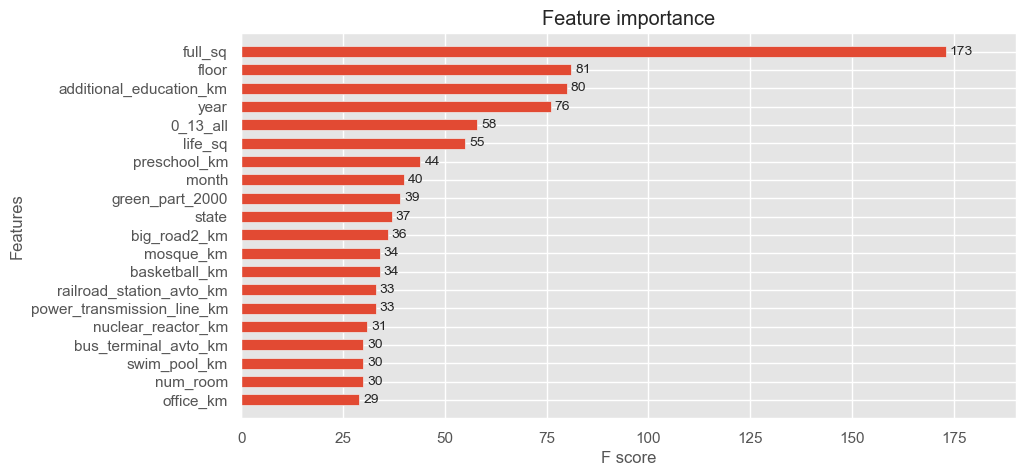

In [62]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot()
    xgb.plotting.plot_importance(model, max_num_features=20, ax=ax, height=0.6, importance_type="weight")

In [63]:
dmatrix_train = xgb.DMatrix(X_train, y_train)
dmatrix_test = xgb.DMatrix(X_test[X_train.columns])

In [64]:
print(X_train.shape)
print(X_test.shape)

(21327, 352)
(7662, 352)


In [65]:
%%time

## Выполним перекрестную проверку для xgboost
xgb_params = {
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,# 0.7,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 1,
    'nthread': -1
}

cv_output = xgb.cv(xgb_params, 
                   dmatrix_train, 
                   num_boost_round=1000, 
                   early_stopping_rounds=20,
                   verbose_eval=20, 
#                    show_stdv=False
                  )

[0]	train-rmse:13.6118+0.000873825	test-rmse:13.6117+0.00111622
[20]	train-rmse:1.72607+0.00156218	test-rmse:1.72954+0.00452744
[40]	train-rmse:0.489877+0.003423	test-rmse:0.518804+0.00282208
[60]	train-rmse:0.427309+0.00315156	test-rmse:0.473792+0.00487067
[80]	train-rmse:0.413047+0.0033787	test-rmse:0.472093+0.00445775
[100]	train-rmse:0.400015+0.00313278	test-rmse:0.471741+0.00400616
CPU times: user 1min 18s, sys: 359 ms, total: 1min 18s
Wall time: 1min 19s


In [66]:
%%time

model = xgb.train(params = dict(xgb_params, verbose=1)
          , dtrain = dmatrix_train
          , num_boost_round = len(cv_output))

CPU times: user 29.3 s, sys: 153 ms, total: 29.4 s
Wall time: 29.6 s


In [67]:
# predict = np.exp(model.predict(dmatrix_val))
# print('RMSLE:', np.sqrt(mean_squared_log_error(np.exp(y_val), predict)))

In [68]:
predict = np.exp(model.predict(dmatrix_test))

In [ ]:
submission = pd.DataFrame({'id': id_test, 'price_doc': predict})
submission.head()

In [69]:
## Сохраняем модель
# submission.to_csv('XGB_CV.csv', index=False)

# CATBOOST

In [70]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

X_test = df_test_encoded[X_train.columns]

In [71]:
train_dataset = cb.Pool(X_train, y_train) 
val_dataset = cb.Pool(X_val, y_val)
test_dataset = cb.Pool(X_test[X_train.columns])

In [72]:
model_cb = cb.CatBoostRegressor(loss_function='RMSE')

In [73]:
grid_cb = {'iterations': [500, 400, 450],
        'learning_rate': [0.03, 0.05, 0.07],
        'max_depth': [x for x in range(5,11,2)],
        'l2_leaf_reg': [1]}

In [77]:
%%time
model_cb.grid_search(
                     param_grid = grid_cb,
                     X = train_dataset,
                     train_size=0.8,
                     cv=3,
                     verbose = 20
                    )

0:	learn: 15.1536747	test: 15.1543256	best: 15.1543256 (0)	total: 63.6ms	remaining: 31.8s
1:	learn: 14.7002180	test: 14.7008714	best: 14.7008714 (1)	total: 69.7ms	remaining: 17.3s
2:	learn: 14.2602914	test: 14.2610104	best: 14.2610104 (2)	total: 76.4ms	remaining: 12.7s
3:	learn: 13.8335380	test: 13.8341674	best: 13.8341674 (3)	total: 84.3ms	remaining: 10.5s
4:	learn: 13.4195979	test: 13.4201978	best: 13.4201978 (4)	total: 90.2ms	remaining: 8.93s
5:	learn: 13.0180331	test: 13.0185281	best: 13.0185281 (5)	total: 99.2ms	remaining: 8.17s
6:	learn: 12.6285660	test: 12.6291673	best: 12.6291673 (6)	total: 109ms	remaining: 7.68s
7:	learn: 12.2507453	test: 12.2513302	best: 12.2513302 (7)	total: 118ms	remaining: 7.24s
8:	learn: 11.8841983	test: 11.8847530	best: 11.8847530 (8)	total: 122ms	remaining: 6.66s
9:	learn: 11.5287864	test: 11.5292567	best: 11.5292567 (9)	total: 131ms	remaining: 6.4s
10:	learn: 11.1844040	test: 11.1848483	best: 11.1848483 (10)	total: 140ms	remaining: 6.2s
11:	learn: 10.8

120:	learn: 0.6433605	test: 0.6427822	best: 0.6427822 (120)	total: 880ms	remaining: 2.76s
121:	learn: 0.6356348	test: 0.6350817	best: 0.6350817 (121)	total: 889ms	remaining: 2.75s
122:	learn: 0.6281170	test: 0.6276835	best: 0.6276835 (122)	total: 900ms	remaining: 2.76s
123:	learn: 0.6210352	test: 0.6206345	best: 0.6206345 (123)	total: 910ms	remaining: 2.76s
124:	learn: 0.6143140	test: 0.6140194	best: 0.6140194 (124)	total: 921ms	remaining: 2.76s
125:	learn: 0.6077207	test: 0.6075398	best: 0.6075398 (125)	total: 930ms	remaining: 2.76s
126:	learn: 0.6013410	test: 0.6012715	best: 0.6012715 (126)	total: 941ms	remaining: 2.76s
127:	learn: 0.5954498	test: 0.5953844	best: 0.5953844 (127)	total: 950ms	remaining: 2.76s
128:	learn: 0.5898587	test: 0.5898874	best: 0.5898874 (128)	total: 959ms	remaining: 2.76s
129:	learn: 0.5847579	test: 0.5848041	best: 0.5848041 (129)	total: 966ms	remaining: 2.75s
130:	learn: 0.5800558	test: 0.5801135	best: 0.5801135 (130)	total: 974ms	remaining: 2.74s
131:	learn

236:	learn: 0.4716347	test: 0.4784102	best: 0.4784102 (236)	total: 1.7s	remaining: 1.89s
237:	learn: 0.4714617	test: 0.4783476	best: 0.4783476 (237)	total: 1.71s	remaining: 1.88s
238:	learn: 0.4712631	test: 0.4781781	best: 0.4781781 (238)	total: 1.72s	remaining: 1.88s
239:	learn: 0.4711644	test: 0.4781440	best: 0.4781440 (239)	total: 1.73s	remaining: 1.87s
240:	learn: 0.4710468	test: 0.4780819	best: 0.4780819 (240)	total: 1.73s	remaining: 1.86s
241:	learn: 0.4708866	test: 0.4779477	best: 0.4779477 (241)	total: 1.74s	remaining: 1.85s
242:	learn: 0.4706890	test: 0.4777797	best: 0.4777797 (242)	total: 1.74s	remaining: 1.84s
243:	learn: 0.4705420	test: 0.4777041	best: 0.4777041 (243)	total: 1.75s	remaining: 1.84s
244:	learn: 0.4704085	test: 0.4776008	best: 0.4776008 (244)	total: 1.76s	remaining: 1.83s
245:	learn: 0.4703227	test: 0.4775229	best: 0.4775229 (245)	total: 1.76s	remaining: 1.82s
246:	learn: 0.4702268	test: 0.4774495	best: 0.4774495 (246)	total: 1.77s	remaining: 1.81s
247:	learn:

358:	learn: 0.4590425	test: 0.4721376	best: 0.4721306 (355)	total: 2.51s	remaining: 986ms
359:	learn: 0.4589663	test: 0.4721323	best: 0.4721306 (355)	total: 2.52s	remaining: 980ms
360:	learn: 0.4588925	test: 0.4720860	best: 0.4720860 (360)	total: 2.53s	remaining: 973ms
361:	learn: 0.4588226	test: 0.4720489	best: 0.4720489 (361)	total: 2.53s	remaining: 966ms
362:	learn: 0.4587741	test: 0.4720380	best: 0.4720380 (362)	total: 2.54s	remaining: 958ms
363:	learn: 0.4587045	test: 0.4720164	best: 0.4720164 (363)	total: 2.54s	remaining: 950ms
364:	learn: 0.4586184	test: 0.4719751	best: 0.4719751 (364)	total: 2.55s	remaining: 943ms
365:	learn: 0.4585029	test: 0.4719145	best: 0.4719145 (365)	total: 2.56s	remaining: 936ms
366:	learn: 0.4583940	test: 0.4719099	best: 0.4719099 (366)	total: 2.56s	remaining: 928ms
367:	learn: 0.4583272	test: 0.4718929	best: 0.4718929 (367)	total: 2.57s	remaining: 921ms
368:	learn: 0.4581857	test: 0.4718099	best: 0.4718099 (368)	total: 2.57s	remaining: 913ms
369:	learn

465:	learn: 0.4498685	test: 0.4703715	best: 0.4703714 (464)	total: 3.33s	remaining: 243ms
466:	learn: 0.4497861	test: 0.4703519	best: 0.4703519 (466)	total: 3.35s	remaining: 236ms
467:	learn: 0.4497307	test: 0.4703445	best: 0.4703445 (467)	total: 3.35s	remaining: 229ms
468:	learn: 0.4496210	test: 0.4703228	best: 0.4703228 (468)	total: 3.36s	remaining: 222ms
469:	learn: 0.4495549	test: 0.4703088	best: 0.4703088 (469)	total: 3.37s	remaining: 215ms
470:	learn: 0.4494890	test: 0.4703227	best: 0.4703088 (469)	total: 3.37s	remaining: 208ms
471:	learn: 0.4493875	test: 0.4702824	best: 0.4702824 (471)	total: 3.38s	remaining: 200ms
472:	learn: 0.4493272	test: 0.4702856	best: 0.4702824 (471)	total: 3.38s	remaining: 193ms
473:	learn: 0.4492173	test: 0.4703165	best: 0.4702824 (471)	total: 3.39s	remaining: 186ms
474:	learn: 0.4491159	test: 0.4703283	best: 0.4702824 (471)	total: 3.39s	remaining: 179ms
475:	learn: 0.4490668	test: 0.4703384	best: 0.4702824 (471)	total: 3.4s	remaining: 171ms
476:	learn:

81:	learn: 0.5504358	test: 0.5510758	best: 0.5510758 (81)	total: 613ms	remaining: 3.13s
82:	learn: 0.5448222	test: 0.5456175	best: 0.5456175 (82)	total: 621ms	remaining: 3.12s
83:	learn: 0.5395618	test: 0.5405097	best: 0.5405097 (83)	total: 628ms	remaining: 3.11s
84:	learn: 0.5347318	test: 0.5357665	best: 0.5357665 (84)	total: 635ms	remaining: 3.1s
85:	learn: 0.5302730	test: 0.5316159	best: 0.5316159 (85)	total: 640ms	remaining: 3.08s
86:	learn: 0.5263417	test: 0.5277352	best: 0.5277352 (86)	total: 646ms	remaining: 3.07s
87:	learn: 0.5224108	test: 0.5239450	best: 0.5239450 (87)	total: 651ms	remaining: 3.05s
88:	learn: 0.5188916	test: 0.5205365	best: 0.5205365 (88)	total: 657ms	remaining: 3.03s
89:	learn: 0.5155166	test: 0.5173249	best: 0.5173249 (89)	total: 662ms	remaining: 3.02s
90:	learn: 0.5125470	test: 0.5144995	best: 0.5144995 (90)	total: 667ms	remaining: 3s
91:	learn: 0.5097583	test: 0.5119059	best: 0.5119059 (91)	total: 672ms	remaining: 2.98s
92:	learn: 0.5070750	test: 0.5094440

178:	learn: 0.4646223	test: 0.4746924	best: 0.4746924 (178)	total: 1.22s	remaining: 2.19s
179:	learn: 0.4644813	test: 0.4746216	best: 0.4746216 (179)	total: 1.23s	remaining: 2.19s
180:	learn: 0.4643012	test: 0.4745490	best: 0.4745490 (180)	total: 1.24s	remaining: 2.18s
181:	learn: 0.4641304	test: 0.4744532	best: 0.4744532 (181)	total: 1.25s	remaining: 2.18s
182:	learn: 0.4639160	test: 0.4743236	best: 0.4743236 (182)	total: 1.25s	remaining: 2.17s
183:	learn: 0.4636555	test: 0.4740617	best: 0.4740617 (183)	total: 1.26s	remaining: 2.17s
184:	learn: 0.4634560	test: 0.4739580	best: 0.4739580 (184)	total: 1.27s	remaining: 2.17s
185:	learn: 0.4632634	test: 0.4738548	best: 0.4738548 (185)	total: 1.28s	remaining: 2.17s
186:	learn: 0.4631264	test: 0.4737380	best: 0.4737380 (186)	total: 1.29s	remaining: 2.16s
187:	learn: 0.4629733	test: 0.4736801	best: 0.4736801 (187)	total: 1.3s	remaining: 2.15s
188:	learn: 0.4627177	test: 0.4735261	best: 0.4735261 (188)	total: 1.3s	remaining: 2.15s
189:	learn: 

289:	learn: 0.4485084	test: 0.4698067	best: 0.4698067 (289)	total: 2.05s	remaining: 1.49s
290:	learn: 0.4483105	test: 0.4698414	best: 0.4698067 (289)	total: 2.06s	remaining: 1.48s
291:	learn: 0.4482412	test: 0.4697970	best: 0.4697970 (291)	total: 2.07s	remaining: 1.47s
292:	learn: 0.4481584	test: 0.4697950	best: 0.4697950 (292)	total: 2.07s	remaining: 1.47s
293:	learn: 0.4480694	test: 0.4697766	best: 0.4697766 (293)	total: 2.08s	remaining: 1.46s
294:	learn: 0.4479304	test: 0.4698162	best: 0.4697766 (293)	total: 2.08s	remaining: 1.45s
295:	learn: 0.4478491	test: 0.4697806	best: 0.4697766 (293)	total: 2.09s	remaining: 1.44s
296:	learn: 0.4477199	test: 0.4697945	best: 0.4697766 (293)	total: 2.1s	remaining: 1.43s
297:	learn: 0.4475853	test: 0.4698290	best: 0.4697766 (293)	total: 2.1s	remaining: 1.42s
298:	learn: 0.4474721	test: 0.4698532	best: 0.4697766 (293)	total: 2.11s	remaining: 1.42s
299:	learn: 0.4473702	test: 0.4698453	best: 0.4697766 (293)	total: 2.11s	remaining: 1.41s
300:	learn: 

397:	learn: 0.4363521	test: 0.4687019	best: 0.4686709 (389)	total: 2.67s	remaining: 685ms
398:	learn: 0.4362800	test: 0.4686388	best: 0.4686388 (398)	total: 2.68s	remaining: 679ms
399:	learn: 0.4361493	test: 0.4686528	best: 0.4686388 (398)	total: 2.69s	remaining: 672ms
400:	learn: 0.4360538	test: 0.4686511	best: 0.4686388 (398)	total: 2.7s	remaining: 666ms
401:	learn: 0.4359370	test: 0.4686257	best: 0.4686257 (401)	total: 2.71s	remaining: 660ms
402:	learn: 0.4357949	test: 0.4686038	best: 0.4686038 (402)	total: 2.71s	remaining: 653ms
403:	learn: 0.4356944	test: 0.4685971	best: 0.4685971 (403)	total: 2.72s	remaining: 647ms
404:	learn: 0.4355754	test: 0.4685905	best: 0.4685905 (404)	total: 2.73s	remaining: 640ms
405:	learn: 0.4355130	test: 0.4685944	best: 0.4685905 (404)	total: 2.74s	remaining: 634ms
406:	learn: 0.4354044	test: 0.4685779	best: 0.4685779 (406)	total: 2.75s	remaining: 627ms
407:	learn: 0.4353273	test: 0.4685166	best: 0.4685166 (407)	total: 2.75s	remaining: 621ms
408:	learn:

12:	learn: 6.1093849	test: 6.1098820	best: 6.1098820 (12)	total: 80.9ms	remaining: 3.03s
13:	learn: 5.6862662	test: 5.6868998	best: 5.6868998 (13)	total: 90.7ms	remaining: 3.15s
14:	learn: 5.2927908	test: 5.2931039	best: 5.2931039 (14)	total: 99.1ms	remaining: 3.2s
15:	learn: 4.9271443	test: 4.9273264	best: 4.9273264 (15)	total: 107ms	remaining: 3.25s
16:	learn: 4.5873212	test: 4.5873684	best: 4.5873684 (16)	total: 115ms	remaining: 3.27s
17:	learn: 4.2716745	test: 4.2717023	best: 4.2717023 (17)	total: 123ms	remaining: 3.29s
18:	learn: 3.9783315	test: 3.9781340	best: 3.9781340 (18)	total: 130ms	remaining: 3.29s
19:	learn: 3.7060540	test: 3.7056879	best: 3.7056879 (19)	total: 138ms	remaining: 3.32s
20:	learn: 3.4532776	test: 3.4527934	best: 3.4527934 (20)	total: 147ms	remaining: 3.35s
21:	learn: 3.2185420	test: 3.2180183	best: 3.2180183 (21)	total: 155ms	remaining: 3.36s
22:	learn: 3.0008381	test: 3.0002740	best: 3.0002740 (22)	total: 162ms	remaining: 3.36s
23:	learn: 2.7988346	test: 2.7

122:	learn: 0.4664112	test: 0.4748586	best: 0.4748586 (122)	total: 895ms	remaining: 2.74s
123:	learn: 0.4662394	test: 0.4747992	best: 0.4747992 (123)	total: 906ms	remaining: 2.75s
124:	learn: 0.4661273	test: 0.4747324	best: 0.4747324 (124)	total: 914ms	remaining: 2.74s
125:	learn: 0.4659134	test: 0.4746203	best: 0.4746203 (125)	total: 923ms	remaining: 2.74s
126:	learn: 0.4656789	test: 0.4746247	best: 0.4746203 (125)	total: 933ms	remaining: 2.74s
127:	learn: 0.4654071	test: 0.4745112	best: 0.4745112 (127)	total: 942ms	remaining: 2.74s
128:	learn: 0.4651428	test: 0.4744507	best: 0.4744507 (128)	total: 951ms	remaining: 2.73s
129:	learn: 0.4649565	test: 0.4744635	best: 0.4744507 (128)	total: 960ms	remaining: 2.73s
130:	learn: 0.4647452	test: 0.4743972	best: 0.4743972 (130)	total: 967ms	remaining: 2.72s
131:	learn: 0.4644537	test: 0.4742304	best: 0.4742304 (131)	total: 972ms	remaining: 2.71s
132:	learn: 0.4642819	test: 0.4741967	best: 0.4741967 (132)	total: 977ms	remaining: 2.7s
133:	learn:

240:	learn: 0.4435148	test: 0.4696777	best: 0.4696648 (227)	total: 1.71s	remaining: 1.83s
241:	learn: 0.4434039	test: 0.4696600	best: 0.4696600 (241)	total: 1.72s	remaining: 1.83s
242:	learn: 0.4432377	test: 0.4696307	best: 0.4696307 (242)	total: 1.72s	remaining: 1.82s
243:	learn: 0.4430571	test: 0.4696428	best: 0.4696307 (242)	total: 1.73s	remaining: 1.81s
244:	learn: 0.4427656	test: 0.4696594	best: 0.4696307 (242)	total: 1.74s	remaining: 1.81s
245:	learn: 0.4426386	test: 0.4696663	best: 0.4696307 (242)	total: 1.74s	remaining: 1.8s
246:	learn: 0.4424562	test: 0.4696612	best: 0.4696307 (242)	total: 1.75s	remaining: 1.79s
247:	learn: 0.4421896	test: 0.4695941	best: 0.4695941 (247)	total: 1.76s	remaining: 1.79s
248:	learn: 0.4420026	test: 0.4695441	best: 0.4695441 (248)	total: 1.76s	remaining: 1.78s
249:	learn: 0.4418375	test: 0.4695390	best: 0.4695390 (249)	total: 1.77s	remaining: 1.77s
250:	learn: 0.4417847	test: 0.4695510	best: 0.4695390 (249)	total: 1.77s	remaining: 1.76s
251:	learn:

345:	learn: 0.4274240	test: 0.4691661	best: 0.4688936 (316)	total: 2.52s	remaining: 1.12s
346:	learn: 0.4273481	test: 0.4691488	best: 0.4688936 (316)	total: 2.52s	remaining: 1.11s
347:	learn: 0.4272323	test: 0.4691269	best: 0.4688936 (316)	total: 2.53s	remaining: 1.11s
348:	learn: 0.4270324	test: 0.4691546	best: 0.4688936 (316)	total: 2.54s	remaining: 1.1s
349:	learn: 0.4269821	test: 0.4691510	best: 0.4688936 (316)	total: 2.54s	remaining: 1.09s
350:	learn: 0.4268047	test: 0.4691419	best: 0.4688936 (316)	total: 2.55s	remaining: 1.08s
351:	learn: 0.4266598	test: 0.4691290	best: 0.4688936 (316)	total: 2.56s	remaining: 1.07s
352:	learn: 0.4265053	test: 0.4691295	best: 0.4688936 (316)	total: 2.56s	remaining: 1.07s
353:	learn: 0.4262796	test: 0.4691250	best: 0.4688936 (316)	total: 2.57s	remaining: 1.06s
354:	learn: 0.4261725	test: 0.4691178	best: 0.4688936 (316)	total: 2.57s	remaining: 1.05s
355:	learn: 0.4260421	test: 0.4691229	best: 0.4688936 (316)	total: 2.58s	remaining: 1.04s
356:	learn:

455:	learn: 0.4137300	test: 0.4690649	best: 0.4688314 (446)	total: 3.12s	remaining: 301ms
456:	learn: 0.4135657	test: 0.4690932	best: 0.4688314 (446)	total: 3.13s	remaining: 295ms
457:	learn: 0.4134051	test: 0.4690921	best: 0.4688314 (446)	total: 3.14s	remaining: 288ms
458:	learn: 0.4133401	test: 0.4690601	best: 0.4688314 (446)	total: 3.14s	remaining: 281ms
459:	learn: 0.4132641	test: 0.4690656	best: 0.4688314 (446)	total: 3.15s	remaining: 274ms
460:	learn: 0.4131499	test: 0.4690389	best: 0.4688314 (446)	total: 3.15s	remaining: 267ms
461:	learn: 0.4129899	test: 0.4689455	best: 0.4688314 (446)	total: 3.16s	remaining: 260ms
462:	learn: 0.4128880	test: 0.4689207	best: 0.4688314 (446)	total: 3.17s	remaining: 253ms
463:	learn: 0.4127388	test: 0.4689390	best: 0.4688314 (446)	total: 3.17s	remaining: 246ms
464:	learn: 0.4126555	test: 0.4689207	best: 0.4688314 (446)	total: 3.18s	remaining: 239ms
465:	learn: 0.4125485	test: 0.4689160	best: 0.4688314 (446)	total: 3.18s	remaining: 232ms
466:	learn

50:	learn: 3.3562439	test: 3.3557981	best: 3.3557981 (50)	total: 483ms	remaining: 3.31s
51:	learn: 3.2586109	test: 3.2581454	best: 3.2581454 (51)	total: 495ms	remaining: 3.31s
52:	learn: 3.1639961	test: 3.1634661	best: 3.1634661 (52)	total: 507ms	remaining: 3.32s
53:	learn: 3.0723053	test: 3.0717210	best: 3.0717210 (53)	total: 519ms	remaining: 3.33s
54:	learn: 2.9834787	test: 2.9828766	best: 2.9828766 (54)	total: 533ms	remaining: 3.34s
55:	learn: 2.8974183	test: 2.8968125	best: 2.8968125 (55)	total: 543ms	remaining: 3.33s
56:	learn: 2.8139868	test: 2.8133660	best: 2.8133660 (56)	total: 552ms	remaining: 3.32s
57:	learn: 2.7332000	test: 2.7325828	best: 2.7325828 (57)	total: 561ms	remaining: 3.31s
58:	learn: 2.6545599	test: 2.6541032	best: 2.6541032 (58)	total: 571ms	remaining: 3.3s
59:	learn: 2.5787190	test: 2.5782176	best: 2.5782176 (59)	total: 580ms	remaining: 3.28s
60:	learn: 2.5052207	test: 2.5046617	best: 2.5046617 (60)	total: 590ms	remaining: 3.28s
61:	learn: 2.4340280	test: 2.4334

163:	learn: 0.4979675	test: 0.5004662	best: 0.5004662 (163)	total: 1.5s	remaining: 2.17s
164:	learn: 0.4969496	test: 0.4995122	best: 0.4995122 (164)	total: 1.51s	remaining: 2.16s
165:	learn: 0.4959794	test: 0.4986077	best: 0.4986077 (165)	total: 1.52s	remaining: 2.15s
166:	learn: 0.4951583	test: 0.4978232	best: 0.4978232 (166)	total: 1.53s	remaining: 2.13s
167:	learn: 0.4942501	test: 0.4970189	best: 0.4970189 (167)	total: 1.54s	remaining: 2.12s
168:	learn: 0.4933488	test: 0.4961365	best: 0.4961365 (168)	total: 1.54s	remaining: 2.11s
169:	learn: 0.4925123	test: 0.4953803	best: 0.4953803 (169)	total: 1.55s	remaining: 2.1s
170:	learn: 0.4917957	test: 0.4947302	best: 0.4947302 (170)	total: 1.55s	remaining: 2.08s
171:	learn: 0.4910811	test: 0.4941121	best: 0.4941121 (171)	total: 1.56s	remaining: 2.07s
172:	learn: 0.4903164	test: 0.4933697	best: 0.4933697 (172)	total: 1.57s	remaining: 2.05s
173:	learn: 0.4896324	test: 0.4928030	best: 0.4928030 (173)	total: 1.57s	remaining: 2.04s
174:	learn: 

279:	learn: 0.4662332	test: 0.4750730	best: 0.4750730 (279)	total: 2.33s	remaining: 997ms
280:	learn: 0.4660936	test: 0.4750013	best: 0.4750013 (280)	total: 2.33s	remaining: 988ms
281:	learn: 0.4659746	test: 0.4749742	best: 0.4749742 (281)	total: 2.34s	remaining: 980ms
282:	learn: 0.4658632	test: 0.4749482	best: 0.4749482 (282)	total: 2.35s	remaining: 972ms
283:	learn: 0.4657355	test: 0.4748371	best: 0.4748371 (283)	total: 2.36s	remaining: 962ms
284:	learn: 0.4656509	test: 0.4748027	best: 0.4748027 (284)	total: 2.36s	remaining: 953ms
285:	learn: 0.4655282	test: 0.4746899	best: 0.4746899 (285)	total: 2.37s	remaining: 944ms
286:	learn: 0.4654579	test: 0.4746394	best: 0.4746394 (286)	total: 2.37s	remaining: 935ms
287:	learn: 0.4653940	test: 0.4745983	best: 0.4745983 (287)	total: 2.38s	remaining: 925ms
288:	learn: 0.4653024	test: 0.4745511	best: 0.4745511 (288)	total: 2.38s	remaining: 916ms
289:	learn: 0.4652331	test: 0.4745107	best: 0.4745107 (289)	total: 2.39s	remaining: 907ms
290:	learn

387:	learn: 0.4565561	test: 0.4712760	best: 0.4712760 (387)	total: 3.14s	remaining: 97.2ms
388:	learn: 0.4564926	test: 0.4712423	best: 0.4712423 (388)	total: 3.15s	remaining: 89.2ms
389:	learn: 0.4563766	test: 0.4712573	best: 0.4712423 (388)	total: 3.16s	remaining: 81.1ms
390:	learn: 0.4562490	test: 0.4712547	best: 0.4712423 (388)	total: 3.17s	remaining: 73ms
391:	learn: 0.4561610	test: 0.4712501	best: 0.4712423 (388)	total: 3.18s	remaining: 64.9ms
392:	learn: 0.4560275	test: 0.4712107	best: 0.4712107 (392)	total: 3.19s	remaining: 56.8ms
393:	learn: 0.4558928	test: 0.4711809	best: 0.4711809 (393)	total: 3.2s	remaining: 48.7ms
394:	learn: 0.4558016	test: 0.4711591	best: 0.4711591 (394)	total: 3.21s	remaining: 40.6ms
395:	learn: 0.4556750	test: 0.4711088	best: 0.4711088 (395)	total: 3.22s	remaining: 32.5ms
396:	learn: 0.4556155	test: 0.4710721	best: 0.4710721 (396)	total: 3.22s	remaining: 24.4ms
397:	learn: 0.4555660	test: 0.4710175	best: 0.4710175 (397)	total: 3.23s	remaining: 16.2ms
39

92:	learn: 0.5070750	test: 0.5094440	best: 0.5094440 (92)	total: 699ms	remaining: 2.31s
93:	learn: 0.5047841	test: 0.5072399	best: 0.5072399 (93)	total: 711ms	remaining: 2.31s
94:	learn: 0.5027186	test: 0.5052959	best: 0.5052959 (94)	total: 722ms	remaining: 2.32s
95:	learn: 0.5006133	test: 0.5032110	best: 0.5032110 (95)	total: 732ms	remaining: 2.32s
96:	learn: 0.4991285	test: 0.5017462	best: 0.5017462 (96)	total: 742ms	remaining: 2.32s
97:	learn: 0.4973898	test: 0.5000941	best: 0.5000941 (97)	total: 752ms	remaining: 2.32s
98:	learn: 0.4958770	test: 0.4987130	best: 0.4987130 (98)	total: 758ms	remaining: 2.3s
99:	learn: 0.4944761	test: 0.4974149	best: 0.4974149 (99)	total: 763ms	remaining: 2.29s
100:	learn: 0.4929801	test: 0.4961120	best: 0.4961120 (100)	total: 769ms	remaining: 2.28s
101:	learn: 0.4917385	test: 0.4949590	best: 0.4949590 (101)	total: 775ms	remaining: 2.26s
102:	learn: 0.4906167	test: 0.4939847	best: 0.4939847 (102)	total: 780ms	remaining: 2.25s
103:	learn: 0.4893468	test:

210:	learn: 0.4592070	test: 0.4724427	best: 0.4724427 (210)	total: 1.51s	remaining: 1.36s
211:	learn: 0.4590768	test: 0.4724238	best: 0.4724238 (211)	total: 1.52s	remaining: 1.35s
212:	learn: 0.4589391	test: 0.4723400	best: 0.4723400 (212)	total: 1.53s	remaining: 1.34s
213:	learn: 0.4588186	test: 0.4723384	best: 0.4723384 (213)	total: 1.54s	remaining: 1.34s
214:	learn: 0.4587148	test: 0.4722983	best: 0.4722983 (214)	total: 1.55s	remaining: 1.33s
215:	learn: 0.4585958	test: 0.4722878	best: 0.4722878 (215)	total: 1.56s	remaining: 1.33s
216:	learn: 0.4584707	test: 0.4722635	best: 0.4722635 (216)	total: 1.56s	remaining: 1.32s
217:	learn: 0.4583094	test: 0.4722714	best: 0.4722635 (216)	total: 1.57s	remaining: 1.31s
218:	learn: 0.4582136	test: 0.4721688	best: 0.4721688 (218)	total: 1.57s	remaining: 1.3s
219:	learn: 0.4580643	test: 0.4721064	best: 0.4721064 (219)	total: 1.58s	remaining: 1.29s
220:	learn: 0.4579211	test: 0.4720920	best: 0.4720920 (220)	total: 1.59s	remaining: 1.28s
221:	learn:

311:	learn: 0.4458498	test: 0.4695517	best: 0.4695517 (311)	total: 2.33s	remaining: 656ms
312:	learn: 0.4456857	test: 0.4695186	best: 0.4695186 (312)	total: 2.34s	remaining: 650ms
313:	learn: 0.4456169	test: 0.4694837	best: 0.4694837 (313)	total: 2.35s	remaining: 643ms
314:	learn: 0.4455464	test: 0.4694392	best: 0.4694392 (314)	total: 2.36s	remaining: 636ms
315:	learn: 0.4453629	test: 0.4693982	best: 0.4693982 (315)	total: 2.37s	remaining: 629ms
316:	learn: 0.4452787	test: 0.4693590	best: 0.4693590 (316)	total: 2.37s	remaining: 622ms
317:	learn: 0.4451707	test: 0.4693385	best: 0.4693385 (317)	total: 2.38s	remaining: 614ms
318:	learn: 0.4451087	test: 0.4693428	best: 0.4693385 (317)	total: 2.39s	remaining: 606ms
319:	learn: 0.4449967	test: 0.4692669	best: 0.4692669 (319)	total: 2.39s	remaining: 599ms
320:	learn: 0.4448275	test: 0.4693398	best: 0.4692669 (319)	total: 2.4s	remaining: 591ms
321:	learn: 0.4446480	test: 0.4693096	best: 0.4692669 (319)	total: 2.4s	remaining: 583ms
322:	learn: 

6:	learn: 9.4148536	test: 9.4155329	best: 9.4155329 (6)	total: 58ms	remaining: 3.25s
7:	learn: 8.7587689	test: 8.7594147	best: 8.7594147 (7)	total: 67.7ms	remaining: 3.32s
8:	learn: 8.1486563	test: 8.1492450	best: 8.1492450 (8)	total: 72.4ms	remaining: 3.14s
9:	learn: 7.5816006	test: 7.5820038	best: 7.5820038 (9)	total: 80.2ms	remaining: 3.13s
10:	learn: 7.0549266	test: 7.0553756	best: 7.0553756 (10)	total: 89.2ms	remaining: 3.15s
11:	learn: 6.5648595	test: 6.5652399	best: 6.5652399 (11)	total: 97.3ms	remaining: 3.15s
12:	learn: 6.1093849	test: 6.1098820	best: 6.1098820 (12)	total: 104ms	remaining: 3.09s
13:	learn: 5.6862662	test: 5.6868998	best: 5.6868998 (13)	total: 109ms	remaining: 3.02s
14:	learn: 5.2927908	test: 5.2931039	best: 5.2931039 (14)	total: 115ms	remaining: 2.94s
15:	learn: 4.9271443	test: 4.9273264	best: 4.9273264 (15)	total: 120ms	remaining: 2.88s
16:	learn: 4.5873212	test: 4.5873684	best: 4.5873684 (16)	total: 125ms	remaining: 2.82s
17:	learn: 4.2716745	test: 4.2717023

125:	learn: 0.4659134	test: 0.4746203	best: 0.4746203 (125)	total: 871ms	remaining: 1.89s
126:	learn: 0.4656789	test: 0.4746247	best: 0.4746203 (125)	total: 880ms	remaining: 1.89s
127:	learn: 0.4654071	test: 0.4745112	best: 0.4745112 (127)	total: 886ms	remaining: 1.88s
128:	learn: 0.4651428	test: 0.4744507	best: 0.4744507 (128)	total: 892ms	remaining: 1.87s
129:	learn: 0.4649565	test: 0.4744635	best: 0.4744507 (128)	total: 898ms	remaining: 1.86s
130:	learn: 0.4647452	test: 0.4743972	best: 0.4743972 (130)	total: 903ms	remaining: 1.85s
131:	learn: 0.4644537	test: 0.4742304	best: 0.4742304 (131)	total: 909ms	remaining: 1.85s
132:	learn: 0.4642819	test: 0.4741967	best: 0.4741967 (132)	total: 915ms	remaining: 1.84s
133:	learn: 0.4641040	test: 0.4741076	best: 0.4741076 (133)	total: 920ms	remaining: 1.83s
134:	learn: 0.4638972	test: 0.4740270	best: 0.4740270 (134)	total: 926ms	remaining: 1.82s
135:	learn: 0.4637107	test: 0.4739711	best: 0.4739711 (135)	total: 931ms	remaining: 1.81s
136:	learn

228:	learn: 0.4451428	test: 0.4696823	best: 0.4696648 (227)	total: 1.7s	remaining: 1.27s
229:	learn: 0.4449158	test: 0.4697147	best: 0.4696648 (227)	total: 1.71s	remaining: 1.26s
230:	learn: 0.4447534	test: 0.4698598	best: 0.4696648 (227)	total: 1.72s	remaining: 1.26s
231:	learn: 0.4445841	test: 0.4698882	best: 0.4696648 (227)	total: 1.73s	remaining: 1.25s
232:	learn: 0.4445107	test: 0.4698886	best: 0.4696648 (227)	total: 1.74s	remaining: 1.25s
233:	learn: 0.4443971	test: 0.4698356	best: 0.4696648 (227)	total: 1.75s	remaining: 1.24s
234:	learn: 0.4442502	test: 0.4698352	best: 0.4696648 (227)	total: 1.76s	remaining: 1.24s
235:	learn: 0.4441111	test: 0.4698158	best: 0.4696648 (227)	total: 1.77s	remaining: 1.23s
236:	learn: 0.4440134	test: 0.4697525	best: 0.4696648 (227)	total: 1.78s	remaining: 1.23s
237:	learn: 0.4438898	test: 0.4697337	best: 0.4696648 (227)	total: 1.79s	remaining: 1.22s
238:	learn: 0.4437878	test: 0.4697374	best: 0.4696648 (227)	total: 1.79s	remaining: 1.21s
239:	learn:

337:	learn: 0.4283997	test: 0.4691633	best: 0.4688936 (316)	total: 2.52s	remaining: 462ms
338:	learn: 0.4282518	test: 0.4691491	best: 0.4688936 (316)	total: 2.53s	remaining: 455ms
339:	learn: 0.4281420	test: 0.4691923	best: 0.4688936 (316)	total: 2.54s	remaining: 448ms
340:	learn: 0.4280317	test: 0.4691693	best: 0.4688936 (316)	total: 2.54s	remaining: 440ms
341:	learn: 0.4279518	test: 0.4691531	best: 0.4688936 (316)	total: 2.55s	remaining: 433ms
342:	learn: 0.4278227	test: 0.4691444	best: 0.4688936 (316)	total: 2.56s	remaining: 426ms
343:	learn: 0.4277116	test: 0.4691338	best: 0.4688936 (316)	total: 2.57s	remaining: 419ms
344:	learn: 0.4275592	test: 0.4692267	best: 0.4688936 (316)	total: 2.58s	remaining: 411ms
345:	learn: 0.4274240	test: 0.4691661	best: 0.4688936 (316)	total: 2.59s	remaining: 404ms
346:	learn: 0.4273481	test: 0.4691488	best: 0.4688936 (316)	total: 2.6s	remaining: 397ms
347:	learn: 0.4272323	test: 0.4691269	best: 0.4688936 (316)	total: 2.6s	remaining: 389ms
348:	learn: 

36:	learn: 5.0961395	test: 5.0961323	best: 5.0961323 (36)	total: 278ms	remaining: 3.1s
37:	learn: 4.9454341	test: 4.9454098	best: 4.9454098 (37)	total: 290ms	remaining: 3.14s
38:	learn: 4.7993685	test: 4.7993675	best: 4.7993675 (38)	total: 302ms	remaining: 3.18s
39:	learn: 4.6576764	test: 4.6576568	best: 4.6576568 (39)	total: 312ms	remaining: 3.2s
40:	learn: 4.5203308	test: 4.5202933	best: 4.5202933 (40)	total: 322ms	remaining: 3.21s
41:	learn: 4.3870918	test: 4.3870567	best: 4.3870567 (41)	total: 332ms	remaining: 3.23s
42:	learn: 4.2578789	test: 4.2578758	best: 4.2578758 (42)	total: 344ms	remaining: 3.26s
43:	learn: 4.1326559	test: 4.1326274	best: 4.1326274 (43)	total: 358ms	remaining: 3.31s
44:	learn: 4.0112051	test: 4.0111968	best: 4.0111968 (44)	total: 372ms	remaining: 3.35s
45:	learn: 3.8935452	test: 3.8935284	best: 3.8935284 (45)	total: 386ms	remaining: 3.39s
46:	learn: 3.7792786	test: 3.7791146	best: 3.7791146 (46)	total: 400ms	remaining: 3.43s
47:	learn: 3.6686152	test: 3.66839

152:	learn: 0.5127373	test: 0.5143939	best: 0.5143939 (152)	total: 1.53s	remaining: 2.96s
153:	learn: 0.5110665	test: 0.5127549	best: 0.5127549 (153)	total: 1.54s	remaining: 2.95s
154:	learn: 0.5095076	test: 0.5113021	best: 0.5113021 (154)	total: 1.54s	remaining: 2.94s
155:	learn: 0.5080292	test: 0.5098593	best: 0.5098593 (155)	total: 1.55s	remaining: 2.92s
156:	learn: 0.5065699	test: 0.5084566	best: 0.5084566 (156)	total: 1.55s	remaining: 2.9s
157:	learn: 0.5051343	test: 0.5070946	best: 0.5070946 (157)	total: 1.56s	remaining: 2.89s
158:	learn: 0.5037533	test: 0.5058377	best: 0.5058377 (158)	total: 1.57s	remaining: 2.87s
159:	learn: 0.5025311	test: 0.5047246	best: 0.5047246 (159)	total: 1.57s	remaining: 2.85s
160:	learn: 0.5013018	test: 0.5035699	best: 0.5035699 (160)	total: 1.58s	remaining: 2.83s
161:	learn: 0.5001887	test: 0.5024895	best: 0.5024895 (161)	total: 1.58s	remaining: 2.82s
162:	learn: 0.4990377	test: 0.5014750	best: 0.5014750 (162)	total: 1.59s	remaining: 2.8s
163:	learn: 

263:	learn: 0.4681035	test: 0.4762098	best: 0.4762098 (263)	total: 2.35s	remaining: 1.65s
264:	learn: 0.4679883	test: 0.4761460	best: 0.4761460 (264)	total: 2.36s	remaining: 1.65s
265:	learn: 0.4678917	test: 0.4760944	best: 0.4760944 (265)	total: 2.37s	remaining: 1.64s
266:	learn: 0.4677053	test: 0.4759429	best: 0.4759429 (266)	total: 2.39s	remaining: 1.64s
267:	learn: 0.4674717	test: 0.4757441	best: 0.4757441 (267)	total: 2.4s	remaining: 1.63s
268:	learn: 0.4673440	test: 0.4756749	best: 0.4756749 (268)	total: 2.42s	remaining: 1.63s
269:	learn: 0.4672234	test: 0.4755943	best: 0.4755943 (269)	total: 2.42s	remaining: 1.62s
270:	learn: 0.4671227	test: 0.4755552	best: 0.4755552 (270)	total: 2.43s	remaining: 1.61s
271:	learn: 0.4670171	test: 0.4755029	best: 0.4755029 (271)	total: 2.44s	remaining: 1.6s
272:	learn: 0.4668780	test: 0.4753861	best: 0.4753861 (272)	total: 2.45s	remaining: 1.59s
273:	learn: 0.4667738	test: 0.4753354	best: 0.4753354 (273)	total: 2.46s	remaining: 1.58s
274:	learn: 

366:	learn: 0.4583940	test: 0.4719099	best: 0.4719099 (366)	total: 3.15s	remaining: 713ms
367:	learn: 0.4583272	test: 0.4718929	best: 0.4718929 (367)	total: 3.16s	remaining: 705ms
368:	learn: 0.4581857	test: 0.4718099	best: 0.4718099 (368)	total: 3.17s	remaining: 696ms
369:	learn: 0.4580868	test: 0.4718285	best: 0.4718099 (368)	total: 3.18s	remaining: 687ms
370:	learn: 0.4579936	test: 0.4718362	best: 0.4718099 (368)	total: 3.18s	remaining: 678ms
371:	learn: 0.4578898	test: 0.4718160	best: 0.4718099 (368)	total: 3.19s	remaining: 669ms
372:	learn: 0.4577652	test: 0.4717731	best: 0.4717731 (372)	total: 3.2s	remaining: 660ms
373:	learn: 0.4576802	test: 0.4717406	best: 0.4717406 (373)	total: 3.2s	remaining: 651ms
374:	learn: 0.4575434	test: 0.4717758	best: 0.4717406 (373)	total: 3.21s	remaining: 641ms
375:	learn: 0.4574682	test: 0.4717696	best: 0.4717406 (373)	total: 3.21s	remaining: 632ms
376:	learn: 0.4574115	test: 0.4717623	best: 0.4717406 (373)	total: 3.22s	remaining: 623ms
377:	learn: 

24:	learn: 4.3737017	test: 4.3734491	best: 4.3734491 (24)	total: 230ms	remaining: 3.92s
25:	learn: 4.1590896	test: 4.1587775	best: 4.1587775 (25)	total: 240ms	remaining: 3.91s
26:	learn: 3.9554428	test: 3.9551054	best: 3.9551054 (26)	total: 247ms	remaining: 3.87s
27:	learn: 3.7621079	test: 3.7617486	best: 3.7617486 (27)	total: 253ms	remaining: 3.81s
28:	learn: 3.5786333	test: 3.5782603	best: 3.5782603 (28)	total: 258ms	remaining: 3.75s
29:	learn: 3.4046181	test: 3.4041620	best: 3.4041620 (29)	total: 265ms	remaining: 3.71s
30:	learn: 3.2395487	test: 3.2390538	best: 3.2390538 (30)	total: 271ms	remaining: 3.67s
31:	learn: 3.0828723	test: 3.0823092	best: 3.0823092 (31)	total: 277ms	remaining: 3.62s
32:	learn: 2.9343929	test: 2.9338571	best: 2.9338571 (32)	total: 284ms	remaining: 3.59s
33:	learn: 2.7935407	test: 2.7930204	best: 2.7930204 (33)	total: 292ms	remaining: 3.57s
34:	learn: 2.6600413	test: 2.6595006	best: 2.6595006 (34)	total: 298ms	remaining: 3.53s
35:	learn: 2.5335150	test: 2.532

117:	learn: 0.4792394	test: 0.4838864	best: 0.4838864 (117)	total: 845ms	remaining: 2.38s
118:	learn: 0.4787434	test: 0.4835214	best: 0.4835214 (118)	total: 856ms	remaining: 2.38s
119:	learn: 0.4783044	test: 0.4831983	best: 0.4831983 (119)	total: 868ms	remaining: 2.39s
120:	learn: 0.4779189	test: 0.4828854	best: 0.4828854 (120)	total: 878ms	remaining: 2.39s
121:	learn: 0.4775957	test: 0.4826125	best: 0.4826125 (121)	total: 888ms	remaining: 2.39s
122:	learn: 0.4771933	test: 0.4823733	best: 0.4823733 (122)	total: 898ms	remaining: 2.39s
123:	learn: 0.4768980	test: 0.4821271	best: 0.4821271 (123)	total: 908ms	remaining: 2.39s
124:	learn: 0.4765389	test: 0.4818520	best: 0.4818520 (124)	total: 918ms	remaining: 2.39s
125:	learn: 0.4761859	test: 0.4816292	best: 0.4816292 (125)	total: 928ms	remaining: 2.39s
126:	learn: 0.4758301	test: 0.4813880	best: 0.4813880 (126)	total: 937ms	remaining: 2.38s
127:	learn: 0.4754467	test: 0.4810418	best: 0.4810418 (127)	total: 947ms	remaining: 2.38s
128:	learn

209:	learn: 0.4593435	test: 0.4725259	best: 0.4725259 (209)	total: 1.67s	remaining: 1.9s
210:	learn: 0.4592070	test: 0.4724427	best: 0.4724427 (210)	total: 1.68s	remaining: 1.9s
211:	learn: 0.4590768	test: 0.4724238	best: 0.4724238 (211)	total: 1.68s	remaining: 1.89s
212:	learn: 0.4589391	test: 0.4723400	best: 0.4723400 (212)	total: 1.69s	remaining: 1.88s
213:	learn: 0.4588186	test: 0.4723384	best: 0.4723384 (213)	total: 1.69s	remaining: 1.87s
214:	learn: 0.4587148	test: 0.4722983	best: 0.4722983 (214)	total: 1.7s	remaining: 1.86s
215:	learn: 0.4585958	test: 0.4722878	best: 0.4722878 (215)	total: 1.71s	remaining: 1.85s
216:	learn: 0.4584707	test: 0.4722635	best: 0.4722635 (216)	total: 1.71s	remaining: 1.84s
217:	learn: 0.4583094	test: 0.4722714	best: 0.4722635 (216)	total: 1.72s	remaining: 1.83s
218:	learn: 0.4582136	test: 0.4721688	best: 0.4721688 (218)	total: 1.72s	remaining: 1.82s
219:	learn: 0.4580643	test: 0.4721064	best: 0.4721064 (219)	total: 1.73s	remaining: 1.81s
220:	learn: 0

318:	learn: 0.4451087	test: 0.4693428	best: 0.4693385 (317)	total: 2.49s	remaining: 1.02s
319:	learn: 0.4449967	test: 0.4692669	best: 0.4692669 (319)	total: 2.5s	remaining: 1.01s
320:	learn: 0.4448275	test: 0.4693398	best: 0.4692669 (319)	total: 2.51s	remaining: 1.01s
321:	learn: 0.4446480	test: 0.4693096	best: 0.4692669 (319)	total: 2.52s	remaining: 1s
322:	learn: 0.4445080	test: 0.4693421	best: 0.4692669 (319)	total: 2.52s	remaining: 993ms
323:	learn: 0.4444029	test: 0.4692997	best: 0.4692669 (319)	total: 2.54s	remaining: 986ms
324:	learn: 0.4442418	test: 0.4692108	best: 0.4692108 (324)	total: 2.55s	remaining: 980ms
325:	learn: 0.4441951	test: 0.4691908	best: 0.4691908 (325)	total: 2.56s	remaining: 973ms
326:	learn: 0.4441148	test: 0.4692016	best: 0.4691908 (325)	total: 2.57s	remaining: 966ms
327:	learn: 0.4440559	test: 0.4692025	best: 0.4691908 (325)	total: 2.58s	remaining: 959ms
328:	learn: 0.4439480	test: 0.4691514	best: 0.4691514 (328)	total: 2.59s	remaining: 952ms
329:	learn: 0.

442:	learn: 0.4317145	test: 0.4682074	best: 0.4680783 (440)	total: 3.51s	remaining: 55.4ms
443:	learn: 0.4316051	test: 0.4682195	best: 0.4680783 (440)	total: 3.51s	remaining: 47.5ms
444:	learn: 0.4315510	test: 0.4682276	best: 0.4680783 (440)	total: 3.52s	remaining: 39.5ms
445:	learn: 0.4314128	test: 0.4682316	best: 0.4680783 (440)	total: 3.53s	remaining: 31.6ms
446:	learn: 0.4313178	test: 0.4682150	best: 0.4680783 (440)	total: 3.53s	remaining: 23.7ms
447:	learn: 0.4312774	test: 0.4681852	best: 0.4680783 (440)	total: 3.54s	remaining: 15.8ms
448:	learn: 0.4310987	test: 0.4681587	best: 0.4680783 (440)	total: 3.54s	remaining: 7.9ms
449:	learn: 0.4310410	test: 0.4681520	best: 0.4680783 (440)	total: 3.55s	remaining: 0us

bestTest = 0.4680782812
bestIteration = 440

0:	learn: 14.5306628	test: 14.5314407	best: 14.5314407 (0)	total: 8.48ms	remaining: 3.81s
1:	learn: 13.5162734	test: 13.5170575	best: 13.5170575 (1)	total: 16.5ms	remaining: 3.7s
2:	learn: 12.5727350	test: 12.5736669	best: 12.5736

114:	learn: 0.4685293	test: 0.4761006	best: 0.4761006 (114)	total: 968ms	remaining: 2.82s
115:	learn: 0.4682779	test: 0.4759777	best: 0.4759777 (115)	total: 979ms	remaining: 2.82s
116:	learn: 0.4679443	test: 0.4757196	best: 0.4757196 (116)	total: 987ms	remaining: 2.81s
117:	learn: 0.4677762	test: 0.4755960	best: 0.4755960 (117)	total: 996ms	remaining: 2.8s
118:	learn: 0.4673965	test: 0.4752960	best: 0.4752960 (118)	total: 1s	remaining: 2.79s
119:	learn: 0.4671249	test: 0.4751029	best: 0.4751029 (119)	total: 1.01s	remaining: 2.79s
120:	learn: 0.4668241	test: 0.4749865	best: 0.4749865 (120)	total: 1.02s	remaining: 2.78s
121:	learn: 0.4666638	test: 0.4749293	best: 0.4749293 (121)	total: 1.03s	remaining: 2.77s
122:	learn: 0.4664112	test: 0.4748586	best: 0.4748586 (122)	total: 1.04s	remaining: 2.76s
123:	learn: 0.4662394	test: 0.4747992	best: 0.4747992 (123)	total: 1.05s	remaining: 2.75s
124:	learn: 0.4661273	test: 0.4747324	best: 0.4747324 (124)	total: 1.06s	remaining: 2.75s
125:	learn: 0.

222:	learn: 0.4461209	test: 0.4698145	best: 0.4697558 (221)	total: 2s	remaining: 2.03s
223:	learn: 0.4459137	test: 0.4698584	best: 0.4697558 (221)	total: 2.01s	remaining: 2.02s
224:	learn: 0.4457796	test: 0.4698278	best: 0.4697558 (221)	total: 2.02s	remaining: 2.02s
225:	learn: 0.4456451	test: 0.4698061	best: 0.4697558 (221)	total: 2.02s	remaining: 2.01s
226:	learn: 0.4455331	test: 0.4696998	best: 0.4696998 (226)	total: 2.03s	remaining: 2s
227:	learn: 0.4452956	test: 0.4696648	best: 0.4696648 (227)	total: 2.04s	remaining: 1.99s
228:	learn: 0.4451428	test: 0.4696823	best: 0.4696648 (227)	total: 2.05s	remaining: 1.98s
229:	learn: 0.4449158	test: 0.4697147	best: 0.4696648 (227)	total: 2.06s	remaining: 1.97s
230:	learn: 0.4447534	test: 0.4698598	best: 0.4696648 (227)	total: 2.07s	remaining: 1.96s
231:	learn: 0.4445841	test: 0.4698882	best: 0.4696648 (227)	total: 2.08s	remaining: 1.95s
232:	learn: 0.4445107	test: 0.4698886	best: 0.4696648 (227)	total: 2.08s	remaining: 1.94s
233:	learn: 0.44

328:	learn: 0.4296583	test: 0.4689971	best: 0.4688936 (316)	total: 2.81s	remaining: 1.03s
329:	learn: 0.4295059	test: 0.4690218	best: 0.4688936 (316)	total: 2.82s	remaining: 1.02s
330:	learn: 0.4293028	test: 0.4690937	best: 0.4688936 (316)	total: 2.83s	remaining: 1.02s
331:	learn: 0.4291609	test: 0.4689883	best: 0.4688936 (316)	total: 2.83s	remaining: 1.01s
332:	learn: 0.4290232	test: 0.4690168	best: 0.4688936 (316)	total: 2.84s	remaining: 998ms
333:	learn: 0.4288092	test: 0.4690388	best: 0.4688936 (316)	total: 2.85s	remaining: 989ms
334:	learn: 0.4286848	test: 0.4690863	best: 0.4688936 (316)	total: 2.85s	remaining: 980ms
335:	learn: 0.4285131	test: 0.4691409	best: 0.4688936 (316)	total: 2.86s	remaining: 970ms
336:	learn: 0.4284817	test: 0.4691592	best: 0.4688936 (316)	total: 2.86s	remaining: 960ms
337:	learn: 0.4283997	test: 0.4691633	best: 0.4688936 (316)	total: 2.87s	remaining: 951ms
338:	learn: 0.4282518	test: 0.4691491	best: 0.4688936 (316)	total: 2.88s	remaining: 942ms
339:	learn

424:	learn: 0.4174425	test: 0.4689206	best: 0.4688671 (410)	total: 3.63s	remaining: 214ms
425:	learn: 0.4172763	test: 0.4689105	best: 0.4688671 (410)	total: 3.64s	remaining: 205ms
426:	learn: 0.4171122	test: 0.4688796	best: 0.4688671 (410)	total: 3.65s	remaining: 197ms
427:	learn: 0.4170169	test: 0.4689249	best: 0.4688671 (410)	total: 3.66s	remaining: 188ms
428:	learn: 0.4168184	test: 0.4689433	best: 0.4688671 (410)	total: 3.67s	remaining: 180ms
429:	learn: 0.4166735	test: 0.4689563	best: 0.4688671 (410)	total: 3.68s	remaining: 171ms
430:	learn: 0.4165803	test: 0.4689667	best: 0.4688671 (410)	total: 3.69s	remaining: 163ms
431:	learn: 0.4164645	test: 0.4689611	best: 0.4688671 (410)	total: 3.7s	remaining: 154ms
432:	learn: 0.4162555	test: 0.4689839	best: 0.4688671 (410)	total: 3.71s	remaining: 146ms
433:	learn: 0.4161284	test: 0.4689818	best: 0.4688671 (410)	total: 3.72s	remaining: 137ms
434:	learn: 0.4160717	test: 0.4689988	best: 0.4688671 (410)	total: 3.72s	remaining: 128ms
435:	learn:

72:	learn: 1.7852611	test: 1.7849157	best: 1.7849157 (72)	total: 1.45s	remaining: 8.49s
73:	learn: 1.7362999	test: 1.7359847	best: 1.7359847 (73)	total: 1.48s	remaining: 8.5s
74:	learn: 1.6895927	test: 1.6892475	best: 1.6892475 (74)	total: 1.5s	remaining: 8.49s
75:	learn: 1.6444279	test: 1.6440223	best: 1.6440223 (75)	total: 1.52s	remaining: 8.51s
76:	learn: 1.5997619	test: 1.5993478	best: 1.5993478 (76)	total: 1.55s	remaining: 8.52s
77:	learn: 1.5574344	test: 1.5569535	best: 1.5569535 (77)	total: 1.57s	remaining: 8.52s
78:	learn: 1.5158987	test: 1.5154280	best: 1.5154280 (78)	total: 1.6s	remaining: 8.52s
79:	learn: 1.4764176	test: 1.4759728	best: 1.4759728 (79)	total: 1.63s	remaining: 8.53s
80:	learn: 1.4381741	test: 1.4377030	best: 1.4377030 (80)	total: 1.65s	remaining: 8.51s
81:	learn: 1.4013284	test: 1.4008730	best: 1.4008730 (81)	total: 1.67s	remaining: 8.51s
82:	learn: 1.3657336	test: 1.3652920	best: 1.3652920 (82)	total: 1.69s	remaining: 8.5s
83:	learn: 1.3305004	test: 1.3300155

172:	learn: 0.4810689	test: 0.4888745	best: 0.4888745 (172)	total: 3.6s	remaining: 6.81s
173:	learn: 0.4803192	test: 0.4883734	best: 0.4883734 (173)	total: 3.63s	remaining: 6.8s
174:	learn: 0.4797441	test: 0.4878369	best: 0.4878369 (174)	total: 3.65s	remaining: 6.78s
175:	learn: 0.4791045	test: 0.4873376	best: 0.4873376 (175)	total: 3.67s	remaining: 6.76s
176:	learn: 0.4783398	test: 0.4867732	best: 0.4867732 (176)	total: 3.69s	remaining: 6.73s
177:	learn: 0.4776409	test: 0.4862031	best: 0.4862031 (177)	total: 3.71s	remaining: 6.71s
178:	learn: 0.4770198	test: 0.4856918	best: 0.4856918 (178)	total: 3.72s	remaining: 6.68s
179:	learn: 0.4764206	test: 0.4851254	best: 0.4851254 (179)	total: 3.74s	remaining: 6.65s
180:	learn: 0.4758583	test: 0.4847378	best: 0.4847378 (180)	total: 3.76s	remaining: 6.62s
181:	learn: 0.4753407	test: 0.4843323	best: 0.4843323 (181)	total: 3.77s	remaining: 6.59s
182:	learn: 0.4748826	test: 0.4839026	best: 0.4839026 (182)	total: 3.79s	remaining: 6.56s
183:	learn: 

270:	learn: 0.4540627	test: 0.4723803	best: 0.4723803 (270)	total: 5.48s	remaining: 4.63s
271:	learn: 0.4539660	test: 0.4723254	best: 0.4723254 (271)	total: 5.5s	remaining: 4.61s
272:	learn: 0.4537946	test: 0.4722632	best: 0.4722632 (272)	total: 5.52s	remaining: 4.59s
273:	learn: 0.4536434	test: 0.4722041	best: 0.4722041 (273)	total: 5.53s	remaining: 4.57s
274:	learn: 0.4535459	test: 0.4721610	best: 0.4721610 (274)	total: 5.55s	remaining: 4.54s
275:	learn: 0.4534298	test: 0.4721480	best: 0.4721480 (275)	total: 5.57s	remaining: 4.52s
276:	learn: 0.4532406	test: 0.4720104	best: 0.4720104 (276)	total: 5.58s	remaining: 4.49s
277:	learn: 0.4530179	test: 0.4719953	best: 0.4719953 (277)	total: 5.6s	remaining: 4.47s
278:	learn: 0.4528245	test: 0.4718799	best: 0.4718799 (278)	total: 5.62s	remaining: 4.45s
279:	learn: 0.4527046	test: 0.4718258	best: 0.4718258 (279)	total: 5.63s	remaining: 4.43s
280:	learn: 0.4525116	test: 0.4717968	best: 0.4717968 (280)	total: 5.65s	remaining: 4.4s
281:	learn: 0

363:	learn: 0.4413292	test: 0.4692452	best: 0.4692452 (363)	total: 7.37s	remaining: 2.75s
364:	learn: 0.4411494	test: 0.4692347	best: 0.4692347 (364)	total: 7.4s	remaining: 2.74s
365:	learn: 0.4409533	test: 0.4692680	best: 0.4692347 (364)	total: 7.42s	remaining: 2.71s
366:	learn: 0.4408191	test: 0.4692556	best: 0.4692347 (364)	total: 7.44s	remaining: 2.7s
367:	learn: 0.4406876	test: 0.4692805	best: 0.4692347 (364)	total: 7.46s	remaining: 2.68s
368:	learn: 0.4405118	test: 0.4692563	best: 0.4692347 (364)	total: 7.49s	remaining: 2.66s
369:	learn: 0.4403640	test: 0.4692457	best: 0.4692347 (364)	total: 7.51s	remaining: 2.64s
370:	learn: 0.4402492	test: 0.4692147	best: 0.4692147 (370)	total: 7.53s	remaining: 2.62s
371:	learn: 0.4400951	test: 0.4691018	best: 0.4691018 (371)	total: 7.56s	remaining: 2.6s
372:	learn: 0.4400042	test: 0.4690929	best: 0.4690929 (372)	total: 7.58s	remaining: 2.58s
373:	learn: 0.4399241	test: 0.4690559	best: 0.4690559 (373)	total: 7.61s	remaining: 2.56s
374:	learn: 0

456:	learn: 0.4303185	test: 0.4684568	best: 0.4684568 (456)	total: 9.29s	remaining: 874ms
457:	learn: 0.4302152	test: 0.4684417	best: 0.4684417 (457)	total: 9.31s	remaining: 854ms
458:	learn: 0.4300432	test: 0.4683801	best: 0.4683801 (458)	total: 9.33s	remaining: 833ms
459:	learn: 0.4299219	test: 0.4683910	best: 0.4683801 (458)	total: 9.35s	remaining: 813ms
460:	learn: 0.4298451	test: 0.4683886	best: 0.4683801 (458)	total: 9.36s	remaining: 792ms
461:	learn: 0.4296600	test: 0.4684074	best: 0.4683801 (458)	total: 9.38s	remaining: 771ms
462:	learn: 0.4294122	test: 0.4684189	best: 0.4683801 (458)	total: 9.4s	remaining: 751ms
463:	learn: 0.4293157	test: 0.4683797	best: 0.4683797 (463)	total: 9.41s	remaining: 731ms
464:	learn: 0.4292523	test: 0.4683747	best: 0.4683747 (464)	total: 9.43s	remaining: 710ms
465:	learn: 0.4291367	test: 0.4683689	best: 0.4683689 (465)	total: 9.45s	remaining: 690ms
466:	learn: 0.4289779	test: 0.4684042	best: 0.4683689 (465)	total: 9.47s	remaining: 669ms
467:	learn:

50:	learn: 1.2705868	test: 1.2694371	best: 1.2694371 (50)	total: 1.1s	remaining: 9.66s
51:	learn: 1.2179464	test: 1.2167394	best: 1.2167394 (51)	total: 1.12s	remaining: 9.65s
52:	learn: 1.1682459	test: 1.1674450	best: 1.1674450 (52)	total: 1.14s	remaining: 9.62s
53:	learn: 1.1224783	test: 1.1217693	best: 1.1217693 (53)	total: 1.16s	remaining: 9.6s
54:	learn: 1.0780348	test: 1.0772809	best: 1.0772809 (54)	total: 1.18s	remaining: 9.57s
55:	learn: 1.0362115	test: 1.0355723	best: 1.0355723 (55)	total: 1.2s	remaining: 9.55s
56:	learn: 0.9983481	test: 0.9977356	best: 0.9977356 (56)	total: 1.22s	remaining: 9.52s
57:	learn: 0.9614481	test: 0.9608528	best: 0.9608528 (57)	total: 1.24s	remaining: 9.48s
58:	learn: 0.9268329	test: 0.9263459	best: 0.9263459 (58)	total: 1.26s	remaining: 9.46s
59:	learn: 0.8945211	test: 0.8943980	best: 0.8943980 (59)	total: 1.29s	remaining: 9.43s
60:	learn: 0.8642986	test: 0.8644684	best: 0.8644684 (60)	total: 1.31s	remaining: 9.43s
61:	learn: 0.8350290	test: 0.835178

146:	learn: 0.4596356	test: 0.4742676	best: 0.4742676 (146)	total: 2.99s	remaining: 7.19s
147:	learn: 0.4591380	test: 0.4738173	best: 0.4738173 (147)	total: 3.02s	remaining: 7.17s
148:	learn: 0.4587819	test: 0.4736200	best: 0.4736200 (148)	total: 3.04s	remaining: 7.16s
149:	learn: 0.4584270	test: 0.4734437	best: 0.4734437 (149)	total: 3.06s	remaining: 7.15s
150:	learn: 0.4581643	test: 0.4733480	best: 0.4733480 (150)	total: 3.09s	remaining: 7.13s
151:	learn: 0.4578821	test: 0.4733488	best: 0.4733480 (150)	total: 3.11s	remaining: 7.12s
152:	learn: 0.4576265	test: 0.4732575	best: 0.4732575 (152)	total: 3.13s	remaining: 7.1s
153:	learn: 0.4572465	test: 0.4729218	best: 0.4729218 (153)	total: 3.15s	remaining: 7.08s
154:	learn: 0.4570062	test: 0.4728797	best: 0.4728797 (154)	total: 3.17s	remaining: 7.06s
155:	learn: 0.4567795	test: 0.4727812	best: 0.4727812 (155)	total: 3.19s	remaining: 7.04s
156:	learn: 0.4564528	test: 0.4727748	best: 0.4727748 (156)	total: 3.22s	remaining: 7.03s
157:	learn:

244:	learn: 0.4372121	test: 0.4691773	best: 0.4691747 (242)	total: 5.11s	remaining: 5.32s
245:	learn: 0.4370585	test: 0.4691161	best: 0.4691161 (245)	total: 5.13s	remaining: 5.3s
246:	learn: 0.4367464	test: 0.4691194	best: 0.4691161 (245)	total: 5.15s	remaining: 5.28s
247:	learn: 0.4366049	test: 0.4691023	best: 0.4691023 (247)	total: 5.17s	remaining: 5.26s
248:	learn: 0.4362135	test: 0.4690920	best: 0.4690920 (248)	total: 5.2s	remaining: 5.24s
249:	learn: 0.4360863	test: 0.4690679	best: 0.4690679 (249)	total: 5.22s	remaining: 5.22s
250:	learn: 0.4358454	test: 0.4689835	best: 0.4689835 (250)	total: 5.24s	remaining: 5.2s
251:	learn: 0.4356850	test: 0.4689898	best: 0.4689835 (250)	total: 5.26s	remaining: 5.17s
252:	learn: 0.4354522	test: 0.4690097	best: 0.4689835 (250)	total: 5.28s	remaining: 5.15s
253:	learn: 0.4352431	test: 0.4689793	best: 0.4689793 (253)	total: 5.3s	remaining: 5.13s
254:	learn: 0.4350680	test: 0.4689770	best: 0.4689770 (254)	total: 5.32s	remaining: 5.11s
255:	learn: 0.

340:	learn: 0.4183015	test: 0.4683595	best: 0.4681815 (311)	total: 6.99s	remaining: 3.26s
341:	learn: 0.4180874	test: 0.4683101	best: 0.4681815 (311)	total: 7s	remaining: 3.24s
342:	learn: 0.4179695	test: 0.4683077	best: 0.4681815 (311)	total: 7.02s	remaining: 3.21s
343:	learn: 0.4176731	test: 0.4682695	best: 0.4681815 (311)	total: 7.04s	remaining: 3.19s
344:	learn: 0.4175827	test: 0.4682174	best: 0.4681815 (311)	total: 7.05s	remaining: 3.17s
345:	learn: 0.4174541	test: 0.4681975	best: 0.4681815 (311)	total: 7.07s	remaining: 3.15s
346:	learn: 0.4173170	test: 0.4682465	best: 0.4681815 (311)	total: 7.09s	remaining: 3.13s
347:	learn: 0.4172342	test: 0.4682262	best: 0.4681815 (311)	total: 7.11s	remaining: 3.11s
348:	learn: 0.4170607	test: 0.4682100	best: 0.4681815 (311)	total: 7.13s	remaining: 3.09s
349:	learn: 0.4168583	test: 0.4682789	best: 0.4681815 (311)	total: 7.16s	remaining: 3.07s
350:	learn: 0.4166269	test: 0.4682224	best: 0.4681815 (311)	total: 7.18s	remaining: 3.05s
351:	learn: 0

437:	learn: 0.4013218	test: 0.4679625	best: 0.4679625 (437)	total: 8.91s	remaining: 1.26s
438:	learn: 0.4011133	test: 0.4678989	best: 0.4678989 (438)	total: 8.93s	remaining: 1.24s
439:	learn: 0.4009284	test: 0.4679356	best: 0.4678989 (438)	total: 8.95s	remaining: 1.22s
440:	learn: 0.4008466	test: 0.4679250	best: 0.4678989 (438)	total: 8.96s	remaining: 1.2s
441:	learn: 0.4007499	test: 0.4679275	best: 0.4678989 (438)	total: 8.98s	remaining: 1.18s
442:	learn: 0.4004523	test: 0.4679298	best: 0.4678989 (438)	total: 8.99s	remaining: 1.16s
443:	learn: 0.4002866	test: 0.4679573	best: 0.4678989 (438)	total: 9.01s	remaining: 1.14s
444:	learn: 0.4001036	test: 0.4679498	best: 0.4678989 (438)	total: 9.03s	remaining: 1.11s
445:	learn: 0.3999689	test: 0.4679963	best: 0.4678989 (438)	total: 9.04s	remaining: 1.09s
446:	learn: 0.3997851	test: 0.4680011	best: 0.4678989 (438)	total: 9.06s	remaining: 1.07s
447:	learn: 0.3996974	test: 0.4679824	best: 0.4678989 (438)	total: 9.07s	remaining: 1.05s
448:	learn:

35:	learn: 1.2729009	test: 1.2712696	best: 1.2712696 (35)	total: 688ms	remaining: 8.87s
36:	learn: 1.1985912	test: 1.1970399	best: 1.1970399 (36)	total: 714ms	remaining: 8.93s
37:	learn: 1.1302386	test: 1.1285404	best: 1.1285404 (37)	total: 735ms	remaining: 8.94s
38:	learn: 1.0692941	test: 1.0676066	best: 1.0676066 (38)	total: 756ms	remaining: 8.93s
39:	learn: 1.0116849	test: 1.0099251	best: 1.0099251 (39)	total: 777ms	remaining: 8.93s
40:	learn: 0.9594494	test: 0.9573780	best: 0.9573780 (40)	total: 798ms	remaining: 8.93s
41:	learn: 0.9112864	test: 0.9091234	best: 0.9091234 (41)	total: 819ms	remaining: 8.93s
42:	learn: 0.8673397	test: 0.8651114	best: 0.8651114 (42)	total: 839ms	remaining: 8.91s
43:	learn: 0.8265694	test: 0.8246258	best: 0.8246258 (43)	total: 854ms	remaining: 8.85s
44:	learn: 0.7905022	test: 0.7888348	best: 0.7888348 (44)	total: 870ms	remaining: 8.8s
45:	learn: 0.7569324	test: 0.7556312	best: 0.7556312 (45)	total: 887ms	remaining: 8.75s
46:	learn: 0.7270502	test: 0.7261

131:	learn: 0.4504101	test: 0.4695483	best: 0.4695483 (131)	total: 2.57s	remaining: 7.18s
132:	learn: 0.4499162	test: 0.4696456	best: 0.4695483 (131)	total: 2.6s	remaining: 7.17s
133:	learn: 0.4496031	test: 0.4695169	best: 0.4695169 (133)	total: 2.62s	remaining: 7.17s
134:	learn: 0.4493050	test: 0.4694165	best: 0.4694165 (134)	total: 2.65s	remaining: 7.16s
135:	learn: 0.4489096	test: 0.4691968	best: 0.4691968 (135)	total: 2.67s	remaining: 7.14s
136:	learn: 0.4485635	test: 0.4691263	best: 0.4691263 (136)	total: 2.69s	remaining: 7.13s
137:	learn: 0.4482271	test: 0.4690616	best: 0.4690616 (137)	total: 2.71s	remaining: 7.12s
138:	learn: 0.4479130	test: 0.4689565	best: 0.4689565 (138)	total: 2.74s	remaining: 7.11s
139:	learn: 0.4475034	test: 0.4688406	best: 0.4688406 (139)	total: 2.76s	remaining: 7.1s
140:	learn: 0.4472490	test: 0.4686452	best: 0.4686452 (140)	total: 2.79s	remaining: 7.09s
141:	learn: 0.4469637	test: 0.4686266	best: 0.4686266 (141)	total: 2.81s	remaining: 7.09s
142:	learn: 

229:	learn: 0.4217167	test: 0.4668988	best: 0.4667878 (224)	total: 4.48s	remaining: 5.26s
230:	learn: 0.4213792	test: 0.4668379	best: 0.4667878 (224)	total: 4.5s	remaining: 5.24s
231:	learn: 0.4210934	test: 0.4668489	best: 0.4667878 (224)	total: 4.52s	remaining: 5.22s
232:	learn: 0.4208699	test: 0.4669208	best: 0.4667878 (224)	total: 4.53s	remaining: 5.19s
233:	learn: 0.4206598	test: 0.4668419	best: 0.4667878 (224)	total: 4.55s	remaining: 5.17s
234:	learn: 0.4204275	test: 0.4668750	best: 0.4667878 (224)	total: 4.57s	remaining: 5.15s
235:	learn: 0.4202087	test: 0.4668396	best: 0.4667878 (224)	total: 4.58s	remaining: 5.12s
236:	learn: 0.4199867	test: 0.4667761	best: 0.4667761 (236)	total: 4.6s	remaining: 5.1s
237:	learn: 0.4196880	test: 0.4667634	best: 0.4667634 (237)	total: 4.61s	remaining: 5.08s
238:	learn: 0.4193822	test: 0.4668092	best: 0.4667634 (237)	total: 4.63s	remaining: 5.05s
239:	learn: 0.4191279	test: 0.4668372	best: 0.4667634 (237)	total: 4.64s	remaining: 5.03s
240:	learn: 0

329:	learn: 0.3983018	test: 0.4675120	best: 0.4666432 (249)	total: 6.38s	remaining: 3.28s
330:	learn: 0.3980104	test: 0.4675991	best: 0.4666432 (249)	total: 6.4s	remaining: 3.27s
331:	learn: 0.3978915	test: 0.4676633	best: 0.4666432 (249)	total: 6.42s	remaining: 3.25s
332:	learn: 0.3976233	test: 0.4676542	best: 0.4666432 (249)	total: 6.43s	remaining: 3.23s
333:	learn: 0.3974077	test: 0.4676396	best: 0.4666432 (249)	total: 6.45s	remaining: 3.2s
334:	learn: 0.3970720	test: 0.4675240	best: 0.4666432 (249)	total: 6.46s	remaining: 3.18s
335:	learn: 0.3969066	test: 0.4675720	best: 0.4666432 (249)	total: 6.48s	remaining: 3.16s
336:	learn: 0.3967352	test: 0.4675597	best: 0.4666432 (249)	total: 6.5s	remaining: 3.14s
337:	learn: 0.3964065	test: 0.4675388	best: 0.4666432 (249)	total: 6.51s	remaining: 3.12s
338:	learn: 0.3962329	test: 0.4675625	best: 0.4666432 (249)	total: 6.53s	remaining: 3.1s
339:	learn: 0.3959973	test: 0.4675689	best: 0.4666432 (249)	total: 6.55s	remaining: 3.08s
340:	learn: 0.

428:	learn: 0.3769291	test: 0.4682912	best: 0.4666432 (249)	total: 8.27s	remaining: 1.37s
429:	learn: 0.3767602	test: 0.4682877	best: 0.4666432 (249)	total: 8.29s	remaining: 1.35s
430:	learn: 0.3766910	test: 0.4682841	best: 0.4666432 (249)	total: 8.32s	remaining: 1.33s
431:	learn: 0.3764066	test: 0.4683151	best: 0.4666432 (249)	total: 8.34s	remaining: 1.31s
432:	learn: 0.3762279	test: 0.4683122	best: 0.4666432 (249)	total: 8.36s	remaining: 1.29s
433:	learn: 0.3759115	test: 0.4683422	best: 0.4666432 (249)	total: 8.39s	remaining: 1.27s
434:	learn: 0.3755719	test: 0.4683059	best: 0.4666432 (249)	total: 8.4s	remaining: 1.26s
435:	learn: 0.3752370	test: 0.4683838	best: 0.4666432 (249)	total: 8.42s	remaining: 1.24s
436:	learn: 0.3750184	test: 0.4683453	best: 0.4666432 (249)	total: 8.44s	remaining: 1.22s
437:	learn: 0.3747302	test: 0.4683932	best: 0.4666432 (249)	total: 8.46s	remaining: 1.2s
438:	learn: 0.3745116	test: 0.4684212	best: 0.4666432 (249)	total: 8.48s	remaining: 1.18s
439:	learn: 

28:	learn: 6.4890029	test: 6.4890249	best: 6.4890249 (28)	total: 537ms	remaining: 6.87s
29:	learn: 6.2962549	test: 6.2962681	best: 6.2962681 (29)	total: 557ms	remaining: 6.87s
30:	learn: 6.1093501	test: 6.1093363	best: 6.1093363 (30)	total: 576ms	remaining: 6.85s
31:	learn: 5.9280430	test: 5.9280857	best: 5.9280857 (31)	total: 591ms	remaining: 6.8s
32:	learn: 5.7524560	test: 5.7524307	best: 5.7524307 (32)	total: 607ms	remaining: 6.75s
33:	learn: 5.5818719	test: 5.5818845	best: 5.5818845 (33)	total: 622ms	remaining: 6.69s
34:	learn: 5.4167185	test: 5.4167807	best: 5.4167807 (34)	total: 638ms	remaining: 6.65s
35:	learn: 5.2562235	test: 5.2562126	best: 5.2562126 (35)	total: 652ms	remaining: 6.59s
36:	learn: 5.1007112	test: 5.1006536	best: 5.1006536 (36)	total: 667ms	remaining: 6.54s
37:	learn: 4.9498540	test: 4.9497318	best: 4.9497318 (37)	total: 681ms	remaining: 6.49s
38:	learn: 4.8035159	test: 4.8033981	best: 4.8033981 (38)	total: 695ms	remaining: 6.44s
39:	learn: 4.6616751	test: 4.6615

124:	learn: 0.6063022	test: 0.6082083	best: 0.6082083 (124)	total: 2.17s	remaining: 4.77s
125:	learn: 0.5995836	test: 0.6016256	best: 0.6016256 (125)	total: 2.19s	remaining: 4.76s
126:	learn: 0.5932734	test: 0.5953686	best: 0.5953686 (126)	total: 2.21s	remaining: 4.75s
127:	learn: 0.5872405	test: 0.5894319	best: 0.5894319 (127)	total: 2.23s	remaining: 4.74s
128:	learn: 0.5815457	test: 0.5838980	best: 0.5838980 (128)	total: 2.25s	remaining: 4.73s
129:	learn: 0.5761595	test: 0.5786474	best: 0.5786474 (129)	total: 2.27s	remaining: 4.72s
130:	learn: 0.5710801	test: 0.5737376	best: 0.5737376 (130)	total: 2.29s	remaining: 4.71s
131:	learn: 0.5660660	test: 0.5688005	best: 0.5688005 (131)	total: 2.31s	remaining: 4.69s
132:	learn: 0.5614228	test: 0.5642390	best: 0.5642390 (132)	total: 2.33s	remaining: 4.67s
133:	learn: 0.5571214	test: 0.5600289	best: 0.5600289 (133)	total: 2.34s	remaining: 4.65s
134:	learn: 0.5527073	test: 0.5557517	best: 0.5557517 (134)	total: 2.36s	remaining: 4.62s
135:	learn

217:	learn: 0.4635570	test: 0.4762375	best: 0.4762375 (217)	total: 3.83s	remaining: 3.2s
218:	learn: 0.4632146	test: 0.4760446	best: 0.4760446 (218)	total: 3.86s	remaining: 3.19s
219:	learn: 0.4629450	test: 0.4758731	best: 0.4758731 (219)	total: 3.88s	remaining: 3.18s
220:	learn: 0.4626835	test: 0.4757212	best: 0.4757212 (220)	total: 3.9s	remaining: 3.16s
221:	learn: 0.4625182	test: 0.4755752	best: 0.4755752 (221)	total: 3.92s	remaining: 3.15s
222:	learn: 0.4623538	test: 0.4754765	best: 0.4754765 (222)	total: 3.95s	remaining: 3.13s
223:	learn: 0.4621803	test: 0.4754340	best: 0.4754340 (223)	total: 3.97s	remaining: 3.12s
224:	learn: 0.4619832	test: 0.4753326	best: 0.4753326 (224)	total: 3.99s	remaining: 3.1s
225:	learn: 0.4618080	test: 0.4752218	best: 0.4752218 (225)	total: 4.01s	remaining: 3.09s
226:	learn: 0.4615804	test: 0.4751397	best: 0.4751397 (226)	total: 4.04s	remaining: 3.08s
227:	learn: 0.4614504	test: 0.4750503	best: 0.4750503 (227)	total: 4.06s	remaining: 3.06s
228:	learn: 0

317:	learn: 0.4476383	test: 0.4705373	best: 0.4705373 (317)	total: 5.75s	remaining: 1.48s
318:	learn: 0.4475122	test: 0.4705546	best: 0.4705373 (317)	total: 5.78s	remaining: 1.47s
319:	learn: 0.4473452	test: 0.4705116	best: 0.4705116 (319)	total: 5.8s	remaining: 1.45s
320:	learn: 0.4471849	test: 0.4704726	best: 0.4704726 (320)	total: 5.82s	remaining: 1.43s
321:	learn: 0.4470228	test: 0.4704318	best: 0.4704318 (321)	total: 5.84s	remaining: 1.42s
322:	learn: 0.4468707	test: 0.4704291	best: 0.4704291 (322)	total: 5.87s	remaining: 1.4s
323:	learn: 0.4466892	test: 0.4703948	best: 0.4703948 (323)	total: 5.89s	remaining: 1.38s
324:	learn: 0.4464945	test: 0.4703791	best: 0.4703791 (324)	total: 5.91s	remaining: 1.36s
325:	learn: 0.4463363	test: 0.4702737	best: 0.4702737 (325)	total: 5.93s	remaining: 1.35s
326:	learn: 0.4461560	test: 0.4702159	best: 0.4702159 (326)	total: 5.95s	remaining: 1.33s
327:	learn: 0.4460396	test: 0.4701957	best: 0.4701957 (327)	total: 5.97s	remaining: 1.31s
328:	learn: 

17:	learn: 6.2366956	test: 6.2367528	best: 6.2367528 (17)	total: 322ms	remaining: 6.84s
18:	learn: 5.9280775	test: 5.9281240	best: 5.9281240 (18)	total: 344ms	remaining: 6.9s
19:	learn: 5.6354797	test: 5.6354658	best: 5.6354658 (19)	total: 363ms	remaining: 6.9s
20:	learn: 5.3569046	test: 5.3568927	best: 5.3568927 (20)	total: 381ms	remaining: 6.87s
21:	learn: 5.0924755	test: 5.0924727	best: 5.0924727 (21)	total: 398ms	remaining: 6.84s
22:	learn: 4.8416860	test: 4.8417185	best: 4.8417185 (22)	total: 417ms	remaining: 6.84s
23:	learn: 4.6037991	test: 4.6037181	best: 4.6037181 (23)	total: 433ms	remaining: 6.78s
24:	learn: 4.3775006	test: 4.3773598	best: 4.3773598 (24)	total: 450ms	remaining: 6.74s
25:	learn: 4.1629000	test: 4.1626846	best: 4.1626846 (25)	total: 471ms	remaining: 6.77s
26:	learn: 3.9590344	test: 3.9587494	best: 3.9587494 (26)	total: 487ms	remaining: 6.73s
27:	learn: 3.7655214	test: 3.7651695	best: 3.7651695 (27)	total: 503ms	remaining: 6.69s
28:	learn: 3.5819295	test: 3.58147

117:	learn: 0.4699209	test: 0.4797619	best: 0.4797619 (117)	total: 2.43s	remaining: 5.82s
118:	learn: 0.4693045	test: 0.4793766	best: 0.4793766 (118)	total: 2.46s	remaining: 5.81s
119:	learn: 0.4687203	test: 0.4790603	best: 0.4790603 (119)	total: 2.49s	remaining: 5.8s
120:	learn: 0.4683211	test: 0.4787873	best: 0.4787873 (120)	total: 2.51s	remaining: 5.79s
121:	learn: 0.4678967	test: 0.4785001	best: 0.4785001 (121)	total: 2.53s	remaining: 5.76s
122:	learn: 0.4673485	test: 0.4782407	best: 0.4782407 (122)	total: 2.55s	remaining: 5.74s
123:	learn: 0.4669781	test: 0.4780183	best: 0.4780183 (123)	total: 2.57s	remaining: 5.71s
124:	learn: 0.4666093	test: 0.4776659	best: 0.4776659 (124)	total: 2.58s	remaining: 5.68s
125:	learn: 0.4662946	test: 0.4774642	best: 0.4774642 (125)	total: 2.6s	remaining: 5.66s
126:	learn: 0.4660028	test: 0.4772811	best: 0.4772811 (126)	total: 2.62s	remaining: 5.64s
127:	learn: 0.4656202	test: 0.4771026	best: 0.4771026 (127)	total: 2.65s	remaining: 5.62s
128:	learn: 

215:	learn: 0.4436497	test: 0.4699466	best: 0.4699225 (214)	total: 4.32s	remaining: 3.68s
216:	learn: 0.4434282	test: 0.4699135	best: 0.4699135 (216)	total: 4.34s	remaining: 3.66s
217:	learn: 0.4431357	test: 0.4699887	best: 0.4699135 (216)	total: 4.36s	remaining: 3.64s
218:	learn: 0.4428148	test: 0.4700645	best: 0.4699135 (216)	total: 4.37s	remaining: 3.61s
219:	learn: 0.4425757	test: 0.4699798	best: 0.4699135 (216)	total: 4.39s	remaining: 3.59s
220:	learn: 0.4423954	test: 0.4699340	best: 0.4699135 (216)	total: 4.41s	remaining: 3.57s
221:	learn: 0.4422065	test: 0.4698057	best: 0.4698057 (221)	total: 4.42s	remaining: 3.54s
222:	learn: 0.4420316	test: 0.4697405	best: 0.4697405 (222)	total: 4.44s	remaining: 3.52s
223:	learn: 0.4418759	test: 0.4696631	best: 0.4696631 (223)	total: 4.45s	remaining: 3.5s
224:	learn: 0.4416262	test: 0.4695407	best: 0.4695407 (224)	total: 4.47s	remaining: 3.48s
225:	learn: 0.4414839	test: 0.4694963	best: 0.4694963 (225)	total: 4.48s	remaining: 3.45s
226:	learn:

317:	learn: 0.4230272	test: 0.4682519	best: 0.4681815 (311)	total: 6.22s	remaining: 1.6s
318:	learn: 0.4229151	test: 0.4682143	best: 0.4681815 (311)	total: 6.24s	remaining: 1.58s
319:	learn: 0.4226475	test: 0.4682056	best: 0.4681815 (311)	total: 6.26s	remaining: 1.56s
320:	learn: 0.4225044	test: 0.4682805	best: 0.4681815 (311)	total: 6.28s	remaining: 1.55s
321:	learn: 0.4224455	test: 0.4682799	best: 0.4681815 (311)	total: 6.3s	remaining: 1.53s
322:	learn: 0.4222647	test: 0.4683344	best: 0.4681815 (311)	total: 6.33s	remaining: 1.51s
323:	learn: 0.4219745	test: 0.4682516	best: 0.4681815 (311)	total: 6.35s	remaining: 1.49s
324:	learn: 0.4216958	test: 0.4682849	best: 0.4681815 (311)	total: 6.37s	remaining: 1.47s
325:	learn: 0.4214814	test: 0.4683189	best: 0.4681815 (311)	total: 6.39s	remaining: 1.45s
326:	learn: 0.4212922	test: 0.4683491	best: 0.4681815 (311)	total: 6.42s	remaining: 1.43s
327:	learn: 0.4211020	test: 0.4683133	best: 0.4681815 (311)	total: 6.44s	remaining: 1.41s
328:	learn: 

11:	learn: 6.5694547	test: 6.5701040	best: 6.5701040 (11)	total: 249ms	remaining: 8.06s
12:	learn: 6.1137569	test: 6.1142187	best: 6.1142187 (12)	total: 268ms	remaining: 7.98s
13:	learn: 5.6904698	test: 5.6908120	best: 5.6908120 (13)	total: 284ms	remaining: 7.84s
14:	learn: 5.2968975	test: 5.2969792	best: 5.2969792 (14)	total: 300ms	remaining: 7.71s
15:	learn: 4.9310834	test: 4.9310906	best: 4.9310906 (15)	total: 316ms	remaining: 7.59s
16:	learn: 4.5913425	test: 4.5913147	best: 4.5913147 (16)	total: 333ms	remaining: 7.5s
17:	learn: 4.2756154	test: 4.2754227	best: 4.2754227 (17)	total: 350ms	remaining: 7.43s
18:	learn: 3.9823153	test: 3.9820779	best: 3.9820779 (18)	total: 367ms	remaining: 7.37s
19:	learn: 3.7098337	test: 3.7094915	best: 3.7094915 (19)	total: 383ms	remaining: 7.28s
20:	learn: 3.4566362	test: 3.4562839	best: 3.4562839 (20)	total: 399ms	remaining: 7.2s
21:	learn: 3.2216598	test: 3.2213151	best: 3.2213151 (21)	total: 415ms	remaining: 7.13s
22:	learn: 3.0037939	test: 3.00348

115:	learn: 0.4552988	test: 0.4714923	best: 0.4714923 (115)	total: 2.18s	remaining: 5.34s
116:	learn: 0.4550608	test: 0.4714783	best: 0.4714783 (116)	total: 2.2s	remaining: 5.32s
117:	learn: 0.4547511	test: 0.4713331	best: 0.4713331 (117)	total: 2.21s	remaining: 5.29s
118:	learn: 0.4544349	test: 0.4712975	best: 0.4712975 (118)	total: 2.23s	remaining: 5.27s
119:	learn: 0.4541652	test: 0.4711591	best: 0.4711591 (119)	total: 2.25s	remaining: 5.24s
120:	learn: 0.4536817	test: 0.4708965	best: 0.4708965 (120)	total: 2.26s	remaining: 5.22s
121:	learn: 0.4534033	test: 0.4708586	best: 0.4708586 (121)	total: 2.28s	remaining: 5.2s
122:	learn: 0.4531131	test: 0.4708503	best: 0.4708503 (122)	total: 2.3s	remaining: 5.17s
123:	learn: 0.4527928	test: 0.4708498	best: 0.4708498 (123)	total: 2.31s	remaining: 5.14s
124:	learn: 0.4524834	test: 0.4707658	best: 0.4707658 (124)	total: 2.33s	remaining: 5.12s
125:	learn: 0.4520569	test: 0.4702627	best: 0.4702627 (125)	total: 2.34s	remaining: 5.09s
126:	learn: 0

215:	learn: 0.4252822	test: 0.4670284	best: 0.4669215 (196)	total: 4.09s	remaining: 3.49s
216:	learn: 0.4249198	test: 0.4671769	best: 0.4669215 (196)	total: 4.12s	remaining: 3.47s
217:	learn: 0.4246655	test: 0.4670312	best: 0.4669215 (196)	total: 4.14s	remaining: 3.46s
218:	learn: 0.4243857	test: 0.4670142	best: 0.4669215 (196)	total: 4.16s	remaining: 3.44s
219:	learn: 0.4241174	test: 0.4670007	best: 0.4669215 (196)	total: 4.19s	remaining: 3.43s
220:	learn: 0.4238349	test: 0.4669292	best: 0.4669215 (196)	total: 4.26s	remaining: 3.45s
221:	learn: 0.4235991	test: 0.4668969	best: 0.4668969 (221)	total: 4.3s	remaining: 3.45s
222:	learn: 0.4233746	test: 0.4668381	best: 0.4668381 (222)	total: 4.33s	remaining: 3.43s
223:	learn: 0.4232154	test: 0.4668100	best: 0.4668100 (223)	total: 4.35s	remaining: 3.42s
224:	learn: 0.4230506	test: 0.4667878	best: 0.4667878 (224)	total: 4.38s	remaining: 3.4s
225:	learn: 0.4227557	test: 0.4667882	best: 0.4667878 (224)	total: 4.4s	remaining: 3.39s
226:	learn: 0

313:	learn: 0.4019780	test: 0.4676747	best: 0.4666432 (249)	total: 6.21s	remaining: 1.7s
314:	learn: 0.4018896	test: 0.4676172	best: 0.4666432 (249)	total: 6.22s	remaining: 1.68s
315:	learn: 0.4014807	test: 0.4677254	best: 0.4666432 (249)	total: 6.25s	remaining: 1.66s
316:	learn: 0.4011196	test: 0.4677102	best: 0.4666432 (249)	total: 6.27s	remaining: 1.64s
317:	learn: 0.4009155	test: 0.4677649	best: 0.4666432 (249)	total: 6.29s	remaining: 1.62s
318:	learn: 0.4007023	test: 0.4677815	best: 0.4666432 (249)	total: 6.31s	remaining: 1.6s
319:	learn: 0.4003304	test: 0.4677723	best: 0.4666432 (249)	total: 6.33s	remaining: 1.58s
320:	learn: 0.4000620	test: 0.4677177	best: 0.4666432 (249)	total: 6.35s	remaining: 1.56s
321:	learn: 0.3998632	test: 0.4677400	best: 0.4666432 (249)	total: 6.37s	remaining: 1.54s
322:	learn: 0.3997775	test: 0.4677535	best: 0.4666432 (249)	total: 6.39s	remaining: 1.52s
323:	learn: 0.3996019	test: 0.4677452	best: 0.4666432 (249)	total: 6.41s	remaining: 1.5s
324:	learn: 0

9:	learn: 11.5315363	test: 11.5323307	best: 11.5323307 (9)	total: 176ms	remaining: 7.74s
10:	learn: 11.1869725	test: 11.1876915	best: 11.1876915 (10)	total: 200ms	remaining: 7.98s
11:	learn: 10.8528692	test: 10.8535813	best: 10.8535813 (11)	total: 222ms	remaining: 8.11s
12:	learn: 10.5287294	test: 10.5293647	best: 10.5293647 (12)	total: 244ms	remaining: 8.21s
13:	learn: 10.2143698	test: 10.2149525	best: 10.2149525 (13)	total: 266ms	remaining: 8.28s
14:	learn: 9.9093682	test: 9.9098145	best: 9.9098145 (14)	total: 288ms	remaining: 8.35s
15:	learn: 9.6134863	test: 9.6138949	best: 9.6138949 (15)	total: 311ms	remaining: 8.43s
16:	learn: 9.3266529	test: 9.3270332	best: 9.3270332 (16)	total: 334ms	remaining: 8.5s
17:	learn: 9.0484241	test: 9.0487037	best: 9.0487037 (17)	total: 356ms	remaining: 8.55s
18:	learn: 8.7785447	test: 8.7788360	best: 8.7788360 (18)	total: 379ms	remaining: 8.59s
19:	learn: 8.5174194	test: 8.5176987	best: 8.5176987 (19)	total: 404ms	remaining: 8.69s
20:	learn: 8.2632806

106:	learn: 0.7919850	test: 0.7924501	best: 0.7924501 (106)	total: 2.11s	remaining: 6.77s
107:	learn: 0.7773773	test: 0.7779222	best: 0.7779222 (107)	total: 2.14s	remaining: 6.76s
108:	learn: 0.7631789	test: 0.7637516	best: 0.7637516 (108)	total: 2.16s	remaining: 6.75s
109:	learn: 0.7497869	test: 0.7503768	best: 0.7503768 (109)	total: 2.18s	remaining: 6.73s
110:	learn: 0.7370422	test: 0.7377412	best: 0.7377412 (110)	total: 2.2s	remaining: 6.72s
111:	learn: 0.7253490	test: 0.7261405	best: 0.7261405 (111)	total: 2.22s	remaining: 6.71s
112:	learn: 0.7134165	test: 0.7142905	best: 0.7142905 (112)	total: 2.24s	remaining: 6.69s
113:	learn: 0.7021698	test: 0.7030521	best: 0.7030521 (113)	total: 2.26s	remaining: 6.67s
114:	learn: 0.6915919	test: 0.6925565	best: 0.6925565 (114)	total: 2.28s	remaining: 6.64s
115:	learn: 0.6810970	test: 0.6821666	best: 0.6821666 (115)	total: 2.29s	remaining: 6.61s
116:	learn: 0.6712089	test: 0.6723586	best: 0.6723586 (116)	total: 2.31s	remaining: 6.58s
117:	learn:

198:	learn: 0.4684227	test: 0.4791200	best: 0.4791200 (198)	total: 3.83s	remaining: 4.83s
199:	learn: 0.4681047	test: 0.4789203	best: 0.4789203 (199)	total: 3.85s	remaining: 4.81s
200:	learn: 0.4678312	test: 0.4787167	best: 0.4787167 (200)	total: 3.86s	remaining: 4.78s
201:	learn: 0.4675517	test: 0.4785354	best: 0.4785354 (201)	total: 3.88s	remaining: 4.76s
202:	learn: 0.4672445	test: 0.4783741	best: 0.4783741 (202)	total: 3.9s	remaining: 4.74s
203:	learn: 0.4669836	test: 0.4781561	best: 0.4781561 (203)	total: 3.91s	remaining: 4.72s
204:	learn: 0.4667105	test: 0.4780167	best: 0.4780167 (204)	total: 3.93s	remaining: 4.69s
205:	learn: 0.4665003	test: 0.4779190	best: 0.4779190 (205)	total: 3.94s	remaining: 4.67s
206:	learn: 0.4662175	test: 0.4777255	best: 0.4777255 (206)	total: 3.96s	remaining: 4.65s
207:	learn: 0.4659442	test: 0.4775618	best: 0.4775618 (207)	total: 3.98s	remaining: 4.63s
208:	learn: 0.4655972	test: 0.4773714	best: 0.4773714 (208)	total: 3.99s	remaining: 4.6s
209:	learn: 

296:	learn: 0.4503873	test: 0.4712344	best: 0.4712344 (296)	total: 5.73s	remaining: 2.95s
297:	learn: 0.4502143	test: 0.4712075	best: 0.4712075 (297)	total: 5.76s	remaining: 2.94s
298:	learn: 0.4500735	test: 0.4711602	best: 0.4711602 (298)	total: 5.78s	remaining: 2.92s
299:	learn: 0.4498879	test: 0.4711375	best: 0.4711375 (299)	total: 5.8s	remaining: 2.9s
300:	learn: 0.4497675	test: 0.4711200	best: 0.4711200 (300)	total: 5.83s	remaining: 2.88s
301:	learn: 0.4496709	test: 0.4711174	best: 0.4711174 (301)	total: 5.85s	remaining: 2.87s
302:	learn: 0.4494894	test: 0.4710678	best: 0.4710678 (302)	total: 5.87s	remaining: 2.85s
303:	learn: 0.4493389	test: 0.4710052	best: 0.4710052 (303)	total: 5.89s	remaining: 2.83s
304:	learn: 0.4491815	test: 0.4709071	best: 0.4709071 (304)	total: 5.91s	remaining: 2.81s
305:	learn: 0.4491101	test: 0.4708957	best: 0.4708957 (305)	total: 5.94s	remaining: 2.79s
306:	learn: 0.4489645	test: 0.4708892	best: 0.4708892 (306)	total: 5.96s	remaining: 2.78s
307:	learn: 

391:	learn: 0.4378451	test: 0.4688044	best: 0.4687608 (388)	total: 7.61s	remaining: 1.13s
392:	learn: 0.4376859	test: 0.4688091	best: 0.4687608 (388)	total: 7.63s	remaining: 1.11s
393:	learn: 0.4375420	test: 0.4688316	best: 0.4687608 (388)	total: 7.65s	remaining: 1.09s
394:	learn: 0.4374571	test: 0.4688204	best: 0.4687608 (388)	total: 7.67s	remaining: 1.07s
395:	learn: 0.4373283	test: 0.4688040	best: 0.4687608 (388)	total: 7.69s	remaining: 1.05s
396:	learn: 0.4371762	test: 0.4688058	best: 0.4687608 (388)	total: 7.7s	remaining: 1.03s
397:	learn: 0.4370523	test: 0.4688382	best: 0.4687608 (388)	total: 7.72s	remaining: 1.01s
398:	learn: 0.4369401	test: 0.4688512	best: 0.4687608 (388)	total: 7.74s	remaining: 989ms
399:	learn: 0.4368010	test: 0.4688052	best: 0.4687608 (388)	total: 7.75s	remaining: 969ms
400:	learn: 0.4367160	test: 0.4687924	best: 0.4687608 (388)	total: 7.77s	remaining: 949ms
401:	learn: 0.4365817	test: 0.4687041	best: 0.4687041 (401)	total: 7.79s	remaining: 930ms
402:	learn:

38:	learn: 2.1939295	test: 2.1932827	best: 2.1932827 (38)	total: 862ms	remaining: 9.08s
39:	learn: 2.0917962	test: 2.0911673	best: 2.0911673 (39)	total: 885ms	remaining: 9.07s
40:	learn: 1.9950900	test: 1.9941742	best: 1.9941742 (40)	total: 907ms	remaining: 9.05s
41:	learn: 1.9037045	test: 1.9026345	best: 1.9026345 (41)	total: 929ms	remaining: 9.03s
42:	learn: 1.8172197	test: 1.8160659	best: 1.8160659 (42)	total: 950ms	remaining: 8.99s
43:	learn: 1.7342124	test: 1.7332013	best: 1.7332013 (43)	total: 965ms	remaining: 8.91s
44:	learn: 1.6567562	test: 1.6558112	best: 1.6558112 (44)	total: 982ms	remaining: 8.84s
45:	learn: 1.5828278	test: 1.5818055	best: 1.5818055 (45)	total: 998ms	remaining: 8.76s
46:	learn: 1.5136722	test: 1.5128071	best: 1.5128071 (46)	total: 1.01s	remaining: 8.69s
47:	learn: 1.4476644	test: 1.4466864	best: 1.4466864 (47)	total: 1.03s	remaining: 8.62s
48:	learn: 1.3860633	test: 1.3851229	best: 1.3851229 (48)	total: 1.05s	remaining: 8.56s
49:	learn: 1.3266164	test: 1.325

135:	learn: 0.4627925	test: 0.4758072	best: 0.4758072 (135)	total: 2.93s	remaining: 6.78s
136:	learn: 0.4623528	test: 0.4754898	best: 0.4754898 (136)	total: 2.96s	remaining: 6.76s
137:	learn: 0.4619951	test: 0.4753527	best: 0.4753527 (137)	total: 2.98s	remaining: 6.74s
138:	learn: 0.4616424	test: 0.4751864	best: 0.4751864 (138)	total: 3s	remaining: 6.71s
139:	learn: 0.4612977	test: 0.4750761	best: 0.4750761 (139)	total: 3.02s	remaining: 6.69s
140:	learn: 0.4608853	test: 0.4749440	best: 0.4749440 (140)	total: 3.04s	remaining: 6.67s
141:	learn: 0.4606584	test: 0.4748040	best: 0.4748040 (141)	total: 3.06s	remaining: 6.65s
142:	learn: 0.4604653	test: 0.4747110	best: 0.4747110 (142)	total: 3.08s	remaining: 6.62s
143:	learn: 0.4603263	test: 0.4746422	best: 0.4746422 (143)	total: 3.1s	remaining: 6.59s
144:	learn: 0.4600993	test: 0.4744863	best: 0.4744863 (144)	total: 3.12s	remaining: 6.57s
145:	learn: 0.4599198	test: 0.4743919	best: 0.4743919 (145)	total: 3.14s	remaining: 6.55s
146:	learn: 0.

231:	learn: 0.4403652	test: 0.4693728	best: 0.4693307 (228)	total: 4.87s	remaining: 4.57s
232:	learn: 0.4401270	test: 0.4694587	best: 0.4693307 (228)	total: 4.89s	remaining: 4.55s
233:	learn: 0.4398448	test: 0.4694462	best: 0.4693307 (228)	total: 4.91s	remaining: 4.53s
234:	learn: 0.4396336	test: 0.4694683	best: 0.4693307 (228)	total: 4.92s	remaining: 4.5s
235:	learn: 0.4393948	test: 0.4693538	best: 0.4693307 (228)	total: 4.94s	remaining: 4.48s
236:	learn: 0.4391513	test: 0.4693299	best: 0.4693299 (236)	total: 4.96s	remaining: 4.46s
237:	learn: 0.4390346	test: 0.4693250	best: 0.4693250 (237)	total: 4.98s	remaining: 4.44s
238:	learn: 0.4386707	test: 0.4693157	best: 0.4693157 (238)	total: 5s	remaining: 4.41s
239:	learn: 0.4383758	test: 0.4692663	best: 0.4692663 (239)	total: 5.01s	remaining: 4.39s
240:	learn: 0.4380528	test: 0.4692310	best: 0.4692310 (240)	total: 5.03s	remaining: 4.36s
241:	learn: 0.4378964	test: 0.4692119	best: 0.4692119 (241)	total: 5.05s	remaining: 4.34s
242:	learn: 0.

331:	learn: 0.4201438	test: 0.4683741	best: 0.4681815 (311)	total: 6.74s	remaining: 2.4s
332:	learn: 0.4199772	test: 0.4684087	best: 0.4681815 (311)	total: 6.77s	remaining: 2.38s
333:	learn: 0.4196193	test: 0.4683601	best: 0.4681815 (311)	total: 6.79s	remaining: 2.36s
334:	learn: 0.4194023	test: 0.4682733	best: 0.4681815 (311)	total: 6.82s	remaining: 2.34s
335:	learn: 0.4192522	test: 0.4682831	best: 0.4681815 (311)	total: 6.84s	remaining: 2.32s
336:	learn: 0.4191454	test: 0.4682683	best: 0.4681815 (311)	total: 6.86s	remaining: 2.3s
337:	learn: 0.4189080	test: 0.4682561	best: 0.4681815 (311)	total: 6.89s	remaining: 2.28s
338:	learn: 0.4188238	test: 0.4682778	best: 0.4681815 (311)	total: 6.91s	remaining: 2.26s
339:	learn: 0.4186034	test: 0.4684335	best: 0.4681815 (311)	total: 6.93s	remaining: 2.24s
340:	learn: 0.4183015	test: 0.4683595	best: 0.4681815 (311)	total: 6.95s	remaining: 2.22s
341:	learn: 0.4180874	test: 0.4683101	best: 0.4681815 (311)	total: 6.97s	remaining: 2.2s
342:	learn: 0

431:	learn: 0.4024878	test: 0.4681548	best: 0.4680394 (420)	total: 8.66s	remaining: 361ms
432:	learn: 0.4022783	test: 0.4681335	best: 0.4680394 (420)	total: 8.68s	remaining: 341ms
433:	learn: 0.4020437	test: 0.4681059	best: 0.4680394 (420)	total: 8.7s	remaining: 321ms
434:	learn: 0.4018897	test: 0.4681110	best: 0.4680394 (420)	total: 8.72s	remaining: 301ms
435:	learn: 0.4017459	test: 0.4680959	best: 0.4680394 (420)	total: 8.74s	remaining: 281ms
436:	learn: 0.4015226	test: 0.4680093	best: 0.4680093 (436)	total: 8.77s	remaining: 261ms
437:	learn: 0.4013218	test: 0.4679625	best: 0.4679625 (437)	total: 8.79s	remaining: 241ms
438:	learn: 0.4011133	test: 0.4678989	best: 0.4678989 (438)	total: 8.81s	remaining: 221ms
439:	learn: 0.4009284	test: 0.4679356	best: 0.4678989 (438)	total: 8.83s	remaining: 201ms
440:	learn: 0.4008466	test: 0.4679250	best: 0.4678989 (438)	total: 8.85s	remaining: 181ms
441:	learn: 0.4007499	test: 0.4679275	best: 0.4678989 (438)	total: 8.87s	remaining: 161ms
442:	learn:

82:	learn: 0.4708084	test: 0.4797903	best: 0.4797903 (82)	total: 1.56s	remaining: 6.91s
83:	learn: 0.4700326	test: 0.4792884	best: 0.4792884 (83)	total: 1.58s	remaining: 6.91s
84:	learn: 0.4694086	test: 0.4789182	best: 0.4789182 (84)	total: 1.61s	remaining: 6.9s
85:	learn: 0.4687513	test: 0.4785015	best: 0.4785015 (85)	total: 1.63s	remaining: 6.89s
86:	learn: 0.4682304	test: 0.4780899	best: 0.4780899 (86)	total: 1.65s	remaining: 6.88s
87:	learn: 0.4675370	test: 0.4777416	best: 0.4777416 (87)	total: 1.67s	remaining: 6.87s
88:	learn: 0.4671194	test: 0.4774405	best: 0.4774405 (88)	total: 1.69s	remaining: 6.85s
89:	learn: 0.4666032	test: 0.4771622	best: 0.4771622 (89)	total: 1.71s	remaining: 6.84s
90:	learn: 0.4660584	test: 0.4768536	best: 0.4768536 (90)	total: 1.73s	remaining: 6.83s
91:	learn: 0.4655257	test: 0.4764244	best: 0.4764244 (91)	total: 1.75s	remaining: 6.81s
92:	learn: 0.4650497	test: 0.4761532	best: 0.4761532 (92)	total: 1.77s	remaining: 6.8s
93:	learn: 0.4646277	test: 0.47588

178:	learn: 0.4357168	test: 0.4670586	best: 0.4670586 (178)	total: 3.47s	remaining: 5.26s
179:	learn: 0.4354186	test: 0.4670428	best: 0.4670428 (179)	total: 3.49s	remaining: 5.24s
180:	learn: 0.4352296	test: 0.4670166	best: 0.4670166 (180)	total: 3.51s	remaining: 5.22s
181:	learn: 0.4350337	test: 0.4669726	best: 0.4669726 (181)	total: 3.53s	remaining: 5.2s
182:	learn: 0.4345952	test: 0.4670351	best: 0.4669726 (181)	total: 3.56s	remaining: 5.19s
183:	learn: 0.4341594	test: 0.4671475	best: 0.4669726 (181)	total: 3.58s	remaining: 5.17s
184:	learn: 0.4337808	test: 0.4672248	best: 0.4669726 (181)	total: 3.6s	remaining: 5.16s
185:	learn: 0.4333597	test: 0.4672230	best: 0.4669726 (181)	total: 3.62s	remaining: 5.13s
186:	learn: 0.4330026	test: 0.4672294	best: 0.4669726 (181)	total: 3.63s	remaining: 5.11s
187:	learn: 0.4326740	test: 0.4672089	best: 0.4669726 (181)	total: 3.65s	remaining: 5.08s
188:	learn: 0.4325427	test: 0.4670680	best: 0.4669726 (181)	total: 3.66s	remaining: 5.06s
189:	learn: 

277:	learn: 0.4100253	test: 0.4667987	best: 0.4666432 (249)	total: 5.4s	remaining: 3.34s
278:	learn: 0.4098664	test: 0.4667917	best: 0.4666432 (249)	total: 5.42s	remaining: 3.32s
279:	learn: 0.4097507	test: 0.4667146	best: 0.4666432 (249)	total: 5.44s	remaining: 3.3s
280:	learn: 0.4094194	test: 0.4668523	best: 0.4666432 (249)	total: 5.45s	remaining: 3.28s
281:	learn: 0.4092318	test: 0.4668301	best: 0.4666432 (249)	total: 5.47s	remaining: 3.26s
282:	learn: 0.4089222	test: 0.4667793	best: 0.4666432 (249)	total: 5.49s	remaining: 3.24s
283:	learn: 0.4086201	test: 0.4668387	best: 0.4666432 (249)	total: 5.5s	remaining: 3.22s
284:	learn: 0.4084024	test: 0.4669364	best: 0.4666432 (249)	total: 5.52s	remaining: 3.2s
285:	learn: 0.4081674	test: 0.4669579	best: 0.4666432 (249)	total: 5.54s	remaining: 3.18s
286:	learn: 0.4078722	test: 0.4669791	best: 0.4666432 (249)	total: 5.57s	remaining: 3.16s
287:	learn: 0.4076786	test: 0.4669959	best: 0.4666432 (249)	total: 5.58s	remaining: 3.14s
288:	learn: 0.

375:	learn: 0.3877167	test: 0.4679302	best: 0.4666432 (249)	total: 7.3s	remaining: 1.44s
376:	learn: 0.3874817	test: 0.4679262	best: 0.4666432 (249)	total: 7.32s	remaining: 1.42s
377:	learn: 0.3872751	test: 0.4678735	best: 0.4666432 (249)	total: 7.34s	remaining: 1.4s
378:	learn: 0.3870846	test: 0.4678432	best: 0.4666432 (249)	total: 7.36s	remaining: 1.38s
379:	learn: 0.3868682	test: 0.4678371	best: 0.4666432 (249)	total: 7.37s	remaining: 1.36s
380:	learn: 0.3867304	test: 0.4678044	best: 0.4666432 (249)	total: 7.39s	remaining: 1.34s
381:	learn: 0.3865196	test: 0.4678459	best: 0.4666432 (249)	total: 7.42s	remaining: 1.32s
382:	learn: 0.3864074	test: 0.4678524	best: 0.4666432 (249)	total: 7.44s	remaining: 1.3s
383:	learn: 0.3861151	test: 0.4678753	best: 0.4666432 (249)	total: 7.46s	remaining: 1.28s
384:	learn: 0.3859320	test: 0.4678970	best: 0.4666432 (249)	total: 7.49s	remaining: 1.26s
385:	learn: 0.3857873	test: 0.4678930	best: 0.4666432 (249)	total: 7.51s	remaining: 1.25s
386:	learn: 0

18:	learn: 8.7888308	test: 8.7909109	best: 8.7909109 (18)	total: 1.32s	remaining: 33.5s
19:	learn: 8.5266338	test: 8.5287627	best: 8.5287627 (19)	total: 1.4s	remaining: 33.5s
20:	learn: 8.2728354	test: 8.2751235	best: 8.2751235 (20)	total: 1.47s	remaining: 33.4s
21:	learn: 8.0268645	test: 8.0291660	best: 8.0291660 (21)	total: 1.54s	remaining: 33.4s
22:	learn: 7.7882814	test: 7.7905021	best: 7.7905021 (22)	total: 1.62s	remaining: 33.6s
23:	learn: 7.5564394	test: 7.5587666	best: 7.5587666 (23)	total: 1.69s	remaining: 33.5s
24:	learn: 7.3315484	test: 7.3338385	best: 7.3338385 (24)	total: 1.76s	remaining: 33.4s
25:	learn: 7.1138739	test: 7.1162519	best: 7.1162519 (25)	total: 1.83s	remaining: 33.3s
26:	learn: 6.9021698	test: 6.9046396	best: 6.9046396 (26)	total: 1.9s	remaining: 33.2s
27:	learn: 6.6972248	test: 6.6997322	best: 6.6997322 (27)	total: 1.97s	remaining: 33.2s
28:	learn: 6.4983450	test: 6.5009913	best: 6.5009913 (28)	total: 2.04s	remaining: 33.1s
29:	learn: 6.3055073	test: 6.30825

114:	learn: 0.6920173	test: 0.6994355	best: 0.6994355 (114)	total: 7.8s	remaining: 26.1s
115:	learn: 0.6812790	test: 0.6889666	best: 0.6889666 (115)	total: 7.89s	remaining: 26.1s
116:	learn: 0.6714093	test: 0.6792003	best: 0.6792003 (116)	total: 7.96s	remaining: 26.1s
117:	learn: 0.6617817	test: 0.6698231	best: 0.6698231 (117)	total: 8.03s	remaining: 26s
118:	learn: 0.6522794	test: 0.6605642	best: 0.6605642 (118)	total: 8.09s	remaining: 25.9s
119:	learn: 0.6433025	test: 0.6517914	best: 0.6517914 (119)	total: 8.16s	remaining: 25.8s
120:	learn: 0.6347935	test: 0.6434354	best: 0.6434354 (120)	total: 8.23s	remaining: 25.8s
121:	learn: 0.6268259	test: 0.6356887	best: 0.6356887 (121)	total: 8.3s	remaining: 25.7s
122:	learn: 0.6191099	test: 0.6281060	best: 0.6281060 (122)	total: 8.36s	remaining: 25.6s
123:	learn: 0.6115960	test: 0.6207793	best: 0.6207793 (123)	total: 8.43s	remaining: 25.6s
124:	learn: 0.6044537	test: 0.6138877	best: 0.6138877 (124)	total: 8.49s	remaining: 25.5s
125:	learn: 0.

208:	learn: 0.4520757	test: 0.4791717	best: 0.4791717 (208)	total: 14.6s	remaining: 20.3s
209:	learn: 0.4517224	test: 0.4789395	best: 0.4789395 (209)	total: 14.7s	remaining: 20.3s
210:	learn: 0.4514203	test: 0.4787784	best: 0.4787784 (210)	total: 14.7s	remaining: 20.2s
211:	learn: 0.4511312	test: 0.4786142	best: 0.4786142 (211)	total: 14.8s	remaining: 20.1s
212:	learn: 0.4508697	test: 0.4784448	best: 0.4784448 (212)	total: 14.9s	remaining: 20.1s
213:	learn: 0.4505482	test: 0.4782872	best: 0.4782872 (213)	total: 15s	remaining: 20s
214:	learn: 0.4502315	test: 0.4781314	best: 0.4781314 (214)	total: 15.1s	remaining: 20s
215:	learn: 0.4499252	test: 0.4780821	best: 0.4780821 (215)	total: 15.2s	remaining: 19.9s
216:	learn: 0.4497691	test: 0.4779957	best: 0.4779957 (216)	total: 15.2s	remaining: 19.9s
217:	learn: 0.4494050	test: 0.4778901	best: 0.4778901 (217)	total: 15.3s	remaining: 19.8s
218:	learn: 0.4491269	test: 0.4777596	best: 0.4777596 (218)	total: 15.4s	remaining: 19.7s
219:	learn: 0.44

300:	learn: 0.4278235	test: 0.4719769	best: 0.4719769 (300)	total: 21.2s	remaining: 14s
301:	learn: 0.4276274	test: 0.4719645	best: 0.4719645 (301)	total: 21.3s	remaining: 13.9s
302:	learn: 0.4273574	test: 0.4718869	best: 0.4718869 (302)	total: 21.3s	remaining: 13.9s
303:	learn: 0.4271856	test: 0.4718201	best: 0.4718201 (303)	total: 21.4s	remaining: 13.8s
304:	learn: 0.4267691	test: 0.4717470	best: 0.4717470 (304)	total: 21.5s	remaining: 13.7s
305:	learn: 0.4265798	test: 0.4716633	best: 0.4716633 (305)	total: 21.5s	remaining: 13.6s
306:	learn: 0.4263413	test: 0.4716634	best: 0.4716633 (305)	total: 21.6s	remaining: 13.6s
307:	learn: 0.4262185	test: 0.4716617	best: 0.4716617 (307)	total: 21.7s	remaining: 13.5s
308:	learn: 0.4259432	test: 0.4715436	best: 0.4715436 (308)	total: 21.7s	remaining: 13.4s
309:	learn: 0.4257085	test: 0.4714284	best: 0.4714284 (309)	total: 21.8s	remaining: 13.4s
310:	learn: 0.4254192	test: 0.4714197	best: 0.4714197 (310)	total: 21.9s	remaining: 13.3s
311:	learn: 

393:	learn: 0.4084433	test: 0.4695238	best: 0.4694893 (392)	total: 27.7s	remaining: 7.45s
394:	learn: 0.4083125	test: 0.4694909	best: 0.4694893 (392)	total: 27.8s	remaining: 7.38s
395:	learn: 0.4080884	test: 0.4694515	best: 0.4694515 (395)	total: 27.8s	remaining: 7.31s
396:	learn: 0.4079963	test: 0.4693986	best: 0.4693986 (396)	total: 27.9s	remaining: 7.24s
397:	learn: 0.4078843	test: 0.4693942	best: 0.4693942 (397)	total: 28s	remaining: 7.17s
398:	learn: 0.4076846	test: 0.4693924	best: 0.4693924 (398)	total: 28s	remaining: 7.1s
399:	learn: 0.4075812	test: 0.4693809	best: 0.4693809 (399)	total: 28.1s	remaining: 7.03s
400:	learn: 0.4073964	test: 0.4693617	best: 0.4693617 (400)	total: 28.2s	remaining: 6.96s
401:	learn: 0.4073080	test: 0.4693356	best: 0.4693356 (401)	total: 28.3s	remaining: 6.89s
402:	learn: 0.4071635	test: 0.4693687	best: 0.4693356 (401)	total: 28.3s	remaining: 6.82s
403:	learn: 0.4069335	test: 0.4693273	best: 0.4693273 (403)	total: 28.4s	remaining: 6.75s
404:	learn: 0.4

487:	learn: 0.3915995	test: 0.4687010	best: 0.4686882 (480)	total: 34.5s	remaining: 848ms
488:	learn: 0.3913067	test: 0.4686909	best: 0.4686882 (480)	total: 34.5s	remaining: 777ms
489:	learn: 0.3911071	test: 0.4686667	best: 0.4686667 (489)	total: 34.6s	remaining: 706ms
490:	learn: 0.3907495	test: 0.4686319	best: 0.4686319 (490)	total: 34.7s	remaining: 636ms
491:	learn: 0.3905646	test: 0.4686328	best: 0.4686319 (490)	total: 34.8s	remaining: 565ms
492:	learn: 0.3903297	test: 0.4686283	best: 0.4686283 (492)	total: 34.8s	remaining: 495ms
493:	learn: 0.3902042	test: 0.4685859	best: 0.4685859 (493)	total: 34.9s	remaining: 424ms
494:	learn: 0.3900122	test: 0.4685456	best: 0.4685456 (494)	total: 35s	remaining: 353ms
495:	learn: 0.3899145	test: 0.4685440	best: 0.4685440 (495)	total: 35.1s	remaining: 283ms
496:	learn: 0.3896374	test: 0.4685384	best: 0.4685384 (496)	total: 35.1s	remaining: 212ms
497:	learn: 0.3893896	test: 0.4685372	best: 0.4685372 (497)	total: 35.2s	remaining: 141ms
498:	learn: 

80:	learn: 0.5443095	test: 0.5560802	best: 0.5560802 (80)	total: 5.44s	remaining: 28.1s
81:	learn: 0.5377565	test: 0.5496517	best: 0.5496517 (81)	total: 5.5s	remaining: 28.1s
82:	learn: 0.5320499	test: 0.5441463	best: 0.5441463 (82)	total: 5.57s	remaining: 28s
83:	learn: 0.5260562	test: 0.5385737	best: 0.5385737 (83)	total: 5.63s	remaining: 27.9s
84:	learn: 0.5211198	test: 0.5338559	best: 0.5338559 (84)	total: 5.7s	remaining: 27.8s
85:	learn: 0.5161263	test: 0.5292144	best: 0.5292144 (85)	total: 5.76s	remaining: 27.7s
86:	learn: 0.5117998	test: 0.5251315	best: 0.5251315 (86)	total: 5.84s	remaining: 27.7s
87:	learn: 0.5075712	test: 0.5212652	best: 0.5212652 (87)	total: 5.91s	remaining: 27.7s
88:	learn: 0.5041661	test: 0.5180931	best: 0.5180931 (88)	total: 5.98s	remaining: 27.6s
89:	learn: 0.5008054	test: 0.5150236	best: 0.5150236 (89)	total: 6.05s	remaining: 27.6s
90:	learn: 0.4970186	test: 0.5118459	best: 0.5118459 (90)	total: 6.13s	remaining: 27.6s
91:	learn: 0.4942611	test: 0.5093256

172:	learn: 0.4329690	test: 0.4726866	best: 0.4726866 (172)	total: 12s	remaining: 22.6s
173:	learn: 0.4326384	test: 0.4726610	best: 0.4726610 (173)	total: 12.1s	remaining: 22.6s
174:	learn: 0.4323483	test: 0.4726206	best: 0.4726206 (174)	total: 12.1s	remaining: 22.5s
175:	learn: 0.4318606	test: 0.4726438	best: 0.4726206 (174)	total: 12.2s	remaining: 22.5s
176:	learn: 0.4314648	test: 0.4726721	best: 0.4726206 (174)	total: 12.3s	remaining: 22.4s
177:	learn: 0.4311481	test: 0.4726136	best: 0.4726136 (177)	total: 12.3s	remaining: 22.3s
178:	learn: 0.4307084	test: 0.4724393	best: 0.4724393 (178)	total: 12.4s	remaining: 22.3s
179:	learn: 0.4305546	test: 0.4723492	best: 0.4723492 (179)	total: 12.5s	remaining: 22.2s
180:	learn: 0.4302014	test: 0.4723095	best: 0.4723095 (180)	total: 12.6s	remaining: 22.1s
181:	learn: 0.4299856	test: 0.4722352	best: 0.4722352 (181)	total: 12.6s	remaining: 22.1s
182:	learn: 0.4296302	test: 0.4721428	best: 0.4721428 (182)	total: 12.7s	remaining: 22s
183:	learn: 0.

265:	learn: 0.4027708	test: 0.4698109	best: 0.4696459 (258)	total: 18.5s	remaining: 16.3s
266:	learn: 0.4024283	test: 0.4697872	best: 0.4696459 (258)	total: 18.6s	remaining: 16.2s
267:	learn: 0.4018381	test: 0.4698416	best: 0.4696459 (258)	total: 18.7s	remaining: 16.1s
268:	learn: 0.4015524	test: 0.4698867	best: 0.4696459 (258)	total: 18.7s	remaining: 16.1s
269:	learn: 0.4011530	test: 0.4699036	best: 0.4696459 (258)	total: 18.8s	remaining: 16s
270:	learn: 0.4008193	test: 0.4698138	best: 0.4696459 (258)	total: 18.9s	remaining: 15.9s
271:	learn: 0.4003131	test: 0.4697959	best: 0.4696459 (258)	total: 18.9s	remaining: 15.9s
272:	learn: 0.4000627	test: 0.4697311	best: 0.4696459 (258)	total: 19s	remaining: 15.8s
273:	learn: 0.3997947	test: 0.4697735	best: 0.4696459 (258)	total: 19.1s	remaining: 15.7s
274:	learn: 0.3996512	test: 0.4697497	best: 0.4696459 (258)	total: 19.2s	remaining: 15.7s
275:	learn: 0.3993321	test: 0.4696546	best: 0.4696459 (258)	total: 19.2s	remaining: 15.6s
276:	learn: 0.

358:	learn: 0.3764129	test: 0.4695129	best: 0.4693411 (325)	total: 25.1s	remaining: 9.85s
359:	learn: 0.3760634	test: 0.4694348	best: 0.4693411 (325)	total: 25.2s	remaining: 9.78s
360:	learn: 0.3758289	test: 0.4695165	best: 0.4693411 (325)	total: 25.2s	remaining: 9.71s
361:	learn: 0.3755510	test: 0.4695288	best: 0.4693411 (325)	total: 25.3s	remaining: 9.64s
362:	learn: 0.3752888	test: 0.4695930	best: 0.4693411 (325)	total: 25.4s	remaining: 9.57s
363:	learn: 0.3748980	test: 0.4696407	best: 0.4693411 (325)	total: 25.4s	remaining: 9.5s
364:	learn: 0.3746293	test: 0.4697195	best: 0.4693411 (325)	total: 25.5s	remaining: 9.43s
365:	learn: 0.3740972	test: 0.4696830	best: 0.4693411 (325)	total: 25.6s	remaining: 9.36s
366:	learn: 0.3738769	test: 0.4696703	best: 0.4693411 (325)	total: 25.6s	remaining: 9.29s
367:	learn: 0.3737193	test: 0.4696444	best: 0.4693411 (325)	total: 25.7s	remaining: 9.22s
368:	learn: 0.3734078	test: 0.4695900	best: 0.4693411 (325)	total: 25.8s	remaining: 9.15s
369:	learn:

450:	learn: 0.3517048	test: 0.4696577	best: 0.4693411 (325)	total: 31.6s	remaining: 3.44s
451:	learn: 0.3513679	test: 0.4696097	best: 0.4693411 (325)	total: 31.7s	remaining: 3.37s
452:	learn: 0.3511594	test: 0.4695485	best: 0.4693411 (325)	total: 31.8s	remaining: 3.29s
453:	learn: 0.3509202	test: 0.4695236	best: 0.4693411 (325)	total: 31.8s	remaining: 3.23s
454:	learn: 0.3507099	test: 0.4695545	best: 0.4693411 (325)	total: 31.9s	remaining: 3.15s
455:	learn: 0.3505670	test: 0.4695595	best: 0.4693411 (325)	total: 32s	remaining: 3.08s
456:	learn: 0.3502929	test: 0.4696296	best: 0.4693411 (325)	total: 32.1s	remaining: 3.02s
457:	learn: 0.3501173	test: 0.4695930	best: 0.4693411 (325)	total: 32.1s	remaining: 2.95s
458:	learn: 0.3499507	test: 0.4696503	best: 0.4693411 (325)	total: 32.2s	remaining: 2.88s
459:	learn: 0.3497130	test: 0.4696648	best: 0.4693411 (325)	total: 32.3s	remaining: 2.81s
460:	learn: 0.3492622	test: 0.4696079	best: 0.4693411 (325)	total: 32.3s	remaining: 2.73s
461:	learn: 

42:	learn: 0.8679228	test: 0.8730959	best: 0.8730959 (42)	total: 2.8s	remaining: 29.8s
43:	learn: 0.8279229	test: 0.8335358	best: 0.8335358 (43)	total: 2.88s	remaining: 29.9s
44:	learn: 0.7913058	test: 0.7973516	best: 0.7973516 (44)	total: 2.95s	remaining: 29.9s
45:	learn: 0.7570605	test: 0.7635692	best: 0.7635692 (45)	total: 3.03s	remaining: 29.9s
46:	learn: 0.7266154	test: 0.7334763	best: 0.7334763 (46)	total: 3.1s	remaining: 29.9s
47:	learn: 0.6992497	test: 0.7064116	best: 0.7064116 (47)	total: 3.17s	remaining: 29.9s
48:	learn: 0.6746233	test: 0.6821022	best: 0.6821022 (48)	total: 3.24s	remaining: 29.8s
49:	learn: 0.6520493	test: 0.6598419	best: 0.6598419 (49)	total: 3.3s	remaining: 29.7s
50:	learn: 0.6314665	test: 0.6395705	best: 0.6395705 (50)	total: 3.37s	remaining: 29.6s
51:	learn: 0.6139803	test: 0.6225810	best: 0.6225810 (51)	total: 3.43s	remaining: 29.6s
52:	learn: 0.5976614	test: 0.6066859	best: 0.6066859 (52)	total: 3.5s	remaining: 29.5s
53:	learn: 0.5828989	test: 0.5922838

137:	learn: 0.4245711	test: 0.4724549	best: 0.4724549 (137)	total: 9.52s	remaining: 25s
138:	learn: 0.4241215	test: 0.4724323	best: 0.4724323 (138)	total: 9.59s	remaining: 24.9s
139:	learn: 0.4236693	test: 0.4724358	best: 0.4724323 (138)	total: 9.65s	remaining: 24.8s
140:	learn: 0.4233793	test: 0.4723913	best: 0.4723913 (140)	total: 9.72s	remaining: 24.7s
141:	learn: 0.4230114	test: 0.4723161	best: 0.4723161 (141)	total: 9.79s	remaining: 24.7s
142:	learn: 0.4225713	test: 0.4722127	best: 0.4722127 (142)	total: 9.85s	remaining: 24.6s
143:	learn: 0.4223297	test: 0.4721248	best: 0.4721248 (143)	total: 9.91s	remaining: 24.5s
144:	learn: 0.4219829	test: 0.4721594	best: 0.4721248 (143)	total: 9.97s	remaining: 24.4s
145:	learn: 0.4216047	test: 0.4721465	best: 0.4721248 (143)	total: 10s	remaining: 24.4s
146:	learn: 0.4210334	test: 0.4720888	best: 0.4720888 (146)	total: 10.1s	remaining: 24.3s
147:	learn: 0.4204708	test: 0.4720014	best: 0.4720014 (147)	total: 10.2s	remaining: 24.2s
148:	learn: 0.

229:	learn: 0.3845747	test: 0.4707127	best: 0.4705851 (222)	total: 16s	remaining: 18.7s
230:	learn: 0.3842257	test: 0.4707012	best: 0.4705851 (222)	total: 16s	remaining: 18.7s
231:	learn: 0.3839788	test: 0.4706930	best: 0.4705851 (222)	total: 16.1s	remaining: 18.6s
232:	learn: 0.3833921	test: 0.4707505	best: 0.4705851 (222)	total: 16.2s	remaining: 18.6s
233:	learn: 0.3828730	test: 0.4707904	best: 0.4705851 (222)	total: 16.3s	remaining: 18.5s
234:	learn: 0.3826322	test: 0.4708592	best: 0.4705851 (222)	total: 16.3s	remaining: 18.4s
235:	learn: 0.3822211	test: 0.4707925	best: 0.4705851 (222)	total: 16.4s	remaining: 18.3s
236:	learn: 0.3815631	test: 0.4708000	best: 0.4705851 (222)	total: 16.5s	remaining: 18.3s
237:	learn: 0.3811745	test: 0.4708024	best: 0.4705851 (222)	total: 16.5s	remaining: 18.2s
238:	learn: 0.3808566	test: 0.4708131	best: 0.4705851 (222)	total: 16.6s	remaining: 18.1s
239:	learn: 0.3804039	test: 0.4707870	best: 0.4705851 (222)	total: 16.7s	remaining: 18.1s
240:	learn: 0.

323:	learn: 0.3479820	test: 0.4718295	best: 0.4705851 (222)	total: 22.6s	remaining: 12.3s
324:	learn: 0.3473558	test: 0.4720266	best: 0.4705851 (222)	total: 22.7s	remaining: 12.2s
325:	learn: 0.3467029	test: 0.4721150	best: 0.4705851 (222)	total: 22.8s	remaining: 12.2s
326:	learn: 0.3464856	test: 0.4721177	best: 0.4705851 (222)	total: 22.8s	remaining: 12.1s
327:	learn: 0.3459961	test: 0.4721543	best: 0.4705851 (222)	total: 22.9s	remaining: 12s
328:	learn: 0.3456198	test: 0.4722005	best: 0.4705851 (222)	total: 23s	remaining: 11.9s
329:	learn: 0.3451392	test: 0.4722293	best: 0.4705851 (222)	total: 23.1s	remaining: 11.9s
330:	learn: 0.3449648	test: 0.4722597	best: 0.4705851 (222)	total: 23.1s	remaining: 11.8s
331:	learn: 0.3447343	test: 0.4722282	best: 0.4705851 (222)	total: 23.2s	remaining: 11.7s
332:	learn: 0.3442509	test: 0.4721620	best: 0.4705851 (222)	total: 23.3s	remaining: 11.7s
333:	learn: 0.3440292	test: 0.4721249	best: 0.4705851 (222)	total: 23.3s	remaining: 11.6s
334:	learn: 0.

417:	learn: 0.3182693	test: 0.4730282	best: 0.4705851 (222)	total: 29.4s	remaining: 5.76s
418:	learn: 0.3178746	test: 0.4730653	best: 0.4705851 (222)	total: 29.5s	remaining: 5.7s
419:	learn: 0.3176026	test: 0.4731027	best: 0.4705851 (222)	total: 29.5s	remaining: 5.62s
420:	learn: 0.3173694	test: 0.4731306	best: 0.4705851 (222)	total: 29.6s	remaining: 5.55s
421:	learn: 0.3169575	test: 0.4731275	best: 0.4705851 (222)	total: 29.7s	remaining: 5.48s
422:	learn: 0.3166625	test: 0.4731950	best: 0.4705851 (222)	total: 29.7s	remaining: 5.41s
423:	learn: 0.3164473	test: 0.4731013	best: 0.4705851 (222)	total: 29.8s	remaining: 5.34s
424:	learn: 0.3163667	test: 0.4731311	best: 0.4705851 (222)	total: 29.9s	remaining: 5.27s
425:	learn: 0.3159902	test: 0.4731291	best: 0.4705851 (222)	total: 29.9s	remaining: 5.2s
426:	learn: 0.3155240	test: 0.4731551	best: 0.4705851 (222)	total: 30s	remaining: 5.13s
427:	learn: 0.3150256	test: 0.4732109	best: 0.4705851 (222)	total: 30.1s	remaining: 5.06s
428:	learn: 0.

11:	learn: 10.8584598	test: 10.8591352	best: 10.8591352 (11)	total: 778ms	remaining: 25.1s
12:	learn: 10.5349870	test: 10.5356061	best: 10.5356061 (12)	total: 846ms	remaining: 25.2s
13:	learn: 10.2206856	test: 10.2213086	best: 10.2213086 (13)	total: 910ms	remaining: 25.1s
14:	learn: 9.9172618	test: 9.9184286	best: 9.9184286 (14)	total: 971ms	remaining: 24.9s
15:	learn: 9.6215892	test: 9.6227965	best: 9.6227965 (15)	total: 1.03s	remaining: 24.8s
16:	learn: 9.3353562	test: 9.3369366	best: 9.3369366 (16)	total: 1.1s	remaining: 24.8s
17:	learn: 9.0577956	test: 9.0597528	best: 9.0597528 (17)	total: 1.17s	remaining: 24.9s
18:	learn: 8.7888308	test: 8.7909109	best: 8.7909109 (18)	total: 1.24s	remaining: 25s
19:	learn: 8.5266338	test: 8.5287627	best: 8.5287627 (19)	total: 1.32s	remaining: 25.1s
20:	learn: 8.2728354	test: 8.2751235	best: 8.2751235 (20)	total: 1.39s	remaining: 25.1s
21:	learn: 8.0268645	test: 8.0291660	best: 8.0291660 (21)	total: 1.46s	remaining: 25.1s
22:	learn: 7.7882814	test:

105:	learn: 0.8102647	test: 0.8165341	best: 0.8165341 (105)	total: 7.19s	remaining: 19.9s
106:	learn: 0.7947884	test: 0.8011459	best: 0.8011459 (106)	total: 7.26s	remaining: 19.9s
107:	learn: 0.7797831	test: 0.7862788	best: 0.7862788 (107)	total: 7.34s	remaining: 19.8s
108:	learn: 0.7654322	test: 0.7720085	best: 0.7720085 (108)	total: 7.4s	remaining: 19.8s
109:	learn: 0.7519284	test: 0.7586700	best: 0.7586700 (109)	total: 7.48s	remaining: 19.7s
110:	learn: 0.7389696	test: 0.7458631	best: 0.7458631 (110)	total: 7.55s	remaining: 19.7s
111:	learn: 0.7263092	test: 0.7333498	best: 0.7333498 (111)	total: 7.62s	remaining: 19.6s
112:	learn: 0.7144720	test: 0.7216645	best: 0.7216645 (112)	total: 7.68s	remaining: 19.5s
113:	learn: 0.7031407	test: 0.7104154	best: 0.7104154 (113)	total: 7.75s	remaining: 19.4s
114:	learn: 0.6920173	test: 0.6994355	best: 0.6994355 (114)	total: 7.81s	remaining: 19.4s
115:	learn: 0.6812790	test: 0.6889666	best: 0.6889666 (115)	total: 7.89s	remaining: 19.3s
116:	learn:

199:	learn: 0.4560436	test: 0.4805509	best: 0.4805509 (199)	total: 13.7s	remaining: 13.7s
200:	learn: 0.4553886	test: 0.4803652	best: 0.4803652 (200)	total: 13.8s	remaining: 13.6s
201:	learn: 0.4551566	test: 0.4802079	best: 0.4802079 (201)	total: 13.8s	remaining: 13.6s
202:	learn: 0.4547538	test: 0.4800704	best: 0.4800704 (202)	total: 13.9s	remaining: 13.5s
203:	learn: 0.4542413	test: 0.4799113	best: 0.4799113 (203)	total: 14s	remaining: 13.4s
204:	learn: 0.4537274	test: 0.4796651	best: 0.4796651 (204)	total: 14s	remaining: 13.4s
205:	learn: 0.4533647	test: 0.4795929	best: 0.4795929 (205)	total: 14.1s	remaining: 13.3s
206:	learn: 0.4529080	test: 0.4794359	best: 0.4794359 (206)	total: 14.2s	remaining: 13.2s
207:	learn: 0.4526458	test: 0.4792785	best: 0.4792785 (207)	total: 14.2s	remaining: 13.2s
208:	learn: 0.4520757	test: 0.4791717	best: 0.4791717 (208)	total: 14.3s	remaining: 13.1s
209:	learn: 0.4517224	test: 0.4789395	best: 0.4789395 (209)	total: 14.4s	remaining: 13s
210:	learn: 0.45

292:	learn: 0.4296129	test: 0.4723410	best: 0.4723410 (292)	total: 20.3s	remaining: 7.41s
293:	learn: 0.4293060	test: 0.4722341	best: 0.4722341 (293)	total: 20.4s	remaining: 7.35s
294:	learn: 0.4290559	test: 0.4721790	best: 0.4721790 (294)	total: 20.4s	remaining: 7.28s
295:	learn: 0.4287273	test: 0.4721670	best: 0.4721670 (295)	total: 20.5s	remaining: 7.22s
296:	learn: 0.4285181	test: 0.4721267	best: 0.4721267 (296)	total: 20.6s	remaining: 7.15s
297:	learn: 0.4283653	test: 0.4720855	best: 0.4720855 (297)	total: 20.7s	remaining: 7.08s
298:	learn: 0.4281922	test: 0.4720861	best: 0.4720855 (297)	total: 20.8s	remaining: 7.01s
299:	learn: 0.4279889	test: 0.4720080	best: 0.4720080 (299)	total: 20.8s	remaining: 6.95s
300:	learn: 0.4278235	test: 0.4719769	best: 0.4719769 (300)	total: 20.9s	remaining: 6.88s
301:	learn: 0.4276274	test: 0.4719645	best: 0.4719645 (301)	total: 21s	remaining: 6.81s
302:	learn: 0.4273574	test: 0.4718869	best: 0.4718869 (302)	total: 21.1s	remaining: 6.75s
303:	learn: 

386:	learn: 0.4098781	test: 0.4695233	best: 0.4695233 (386)	total: 26.9s	remaining: 904ms
387:	learn: 0.4097078	test: 0.4695653	best: 0.4695233 (386)	total: 27s	remaining: 835ms
388:	learn: 0.4094116	test: 0.4695347	best: 0.4695233 (386)	total: 27.1s	remaining: 765ms
389:	learn: 0.4092992	test: 0.4695240	best: 0.4695233 (386)	total: 27.1s	remaining: 695ms
390:	learn: 0.4090045	test: 0.4695091	best: 0.4695091 (390)	total: 27.2s	remaining: 626ms
391:	learn: 0.4088438	test: 0.4694894	best: 0.4694894 (391)	total: 27.3s	remaining: 556ms
392:	learn: 0.4086773	test: 0.4694893	best: 0.4694893 (392)	total: 27.3s	remaining: 487ms
393:	learn: 0.4084433	test: 0.4695238	best: 0.4694893 (392)	total: 27.4s	remaining: 417ms
394:	learn: 0.4083125	test: 0.4694909	best: 0.4694893 (392)	total: 27.5s	remaining: 348ms
395:	learn: 0.4080884	test: 0.4694515	best: 0.4694515 (395)	total: 27.5s	remaining: 278ms
396:	learn: 0.4079963	test: 0.4693986	best: 0.4693986 (396)	total: 27.6s	remaining: 209ms
397:	learn: 

80:	learn: 0.5443095	test: 0.5560802	best: 0.5560802 (80)	total: 5.39s	remaining: 21.2s
81:	learn: 0.5377565	test: 0.5496517	best: 0.5496517 (81)	total: 5.46s	remaining: 21.2s
82:	learn: 0.5320499	test: 0.5441463	best: 0.5441463 (82)	total: 5.53s	remaining: 21.1s
83:	learn: 0.5260562	test: 0.5385737	best: 0.5385737 (83)	total: 5.6s	remaining: 21.1s
84:	learn: 0.5211198	test: 0.5338559	best: 0.5338559 (84)	total: 5.67s	remaining: 21s
85:	learn: 0.5161263	test: 0.5292144	best: 0.5292144 (85)	total: 5.74s	remaining: 21s
86:	learn: 0.5117998	test: 0.5251315	best: 0.5251315 (86)	total: 5.82s	remaining: 20.9s
87:	learn: 0.5075712	test: 0.5212652	best: 0.5212652 (87)	total: 5.88s	remaining: 20.9s
88:	learn: 0.5041661	test: 0.5180931	best: 0.5180931 (88)	total: 5.95s	remaining: 20.8s
89:	learn: 0.5008054	test: 0.5150236	best: 0.5150236 (89)	total: 6.01s	remaining: 20.7s
90:	learn: 0.4970186	test: 0.5118459	best: 0.5118459 (90)	total: 6.08s	remaining: 20.6s
91:	learn: 0.4942611	test: 0.5093256	

175:	learn: 0.4318606	test: 0.4726438	best: 0.4726206 (174)	total: 12s	remaining: 15.2s
176:	learn: 0.4314648	test: 0.4726721	best: 0.4726206 (174)	total: 12s	remaining: 15.2s
177:	learn: 0.4311481	test: 0.4726136	best: 0.4726136 (177)	total: 12.1s	remaining: 15.1s
178:	learn: 0.4307084	test: 0.4724393	best: 0.4724393 (178)	total: 12.2s	remaining: 15s
179:	learn: 0.4305546	test: 0.4723492	best: 0.4723492 (179)	total: 12.2s	remaining: 15s
180:	learn: 0.4302014	test: 0.4723095	best: 0.4723095 (180)	total: 12.3s	remaining: 14.9s
181:	learn: 0.4299856	test: 0.4722352	best: 0.4722352 (181)	total: 12.4s	remaining: 14.8s
182:	learn: 0.4296302	test: 0.4721428	best: 0.4721428 (182)	total: 12.4s	remaining: 14.7s
183:	learn: 0.4292847	test: 0.4721410	best: 0.4721410 (183)	total: 12.5s	remaining: 14.7s
184:	learn: 0.4289411	test: 0.4720778	best: 0.4720778 (184)	total: 12.6s	remaining: 14.6s
185:	learn: 0.4287289	test: 0.4720827	best: 0.4720778 (184)	total: 12.6s	remaining: 14.5s
186:	learn: 0.4285

268:	learn: 0.4015524	test: 0.4698867	best: 0.4696459 (258)	total: 18.7s	remaining: 9.12s
269:	learn: 0.4011530	test: 0.4699036	best: 0.4696459 (258)	total: 18.8s	remaining: 9.05s
270:	learn: 0.4008193	test: 0.4698138	best: 0.4696459 (258)	total: 18.9s	remaining: 8.98s
271:	learn: 0.4003131	test: 0.4697959	best: 0.4696459 (258)	total: 18.9s	remaining: 8.91s
272:	learn: 0.4000627	test: 0.4697311	best: 0.4696459 (258)	total: 19s	remaining: 8.85s
273:	learn: 0.3997947	test: 0.4697735	best: 0.4696459 (258)	total: 19.1s	remaining: 8.78s
274:	learn: 0.3996512	test: 0.4697497	best: 0.4696459 (258)	total: 19.2s	remaining: 8.71s
275:	learn: 0.3993321	test: 0.4696546	best: 0.4696459 (258)	total: 19.2s	remaining: 8.64s
276:	learn: 0.3991554	test: 0.4696375	best: 0.4696375 (276)	total: 19.3s	remaining: 8.57s
277:	learn: 0.3989316	test: 0.4696733	best: 0.4696375 (276)	total: 19.4s	remaining: 8.49s
278:	learn: 0.3987780	test: 0.4696551	best: 0.4696375 (276)	total: 19.4s	remaining: 8.43s
279:	learn: 

362:	learn: 0.3752888	test: 0.4695930	best: 0.4693411 (325)	total: 25.3s	remaining: 2.58s
363:	learn: 0.3748980	test: 0.4696407	best: 0.4693411 (325)	total: 25.4s	remaining: 2.51s
364:	learn: 0.3746293	test: 0.4697195	best: 0.4693411 (325)	total: 25.5s	remaining: 2.44s
365:	learn: 0.3740972	test: 0.4696830	best: 0.4693411 (325)	total: 25.6s	remaining: 2.37s
366:	learn: 0.3738769	test: 0.4696703	best: 0.4693411 (325)	total: 25.6s	remaining: 2.3s
367:	learn: 0.3737193	test: 0.4696444	best: 0.4693411 (325)	total: 25.7s	remaining: 2.23s
368:	learn: 0.3734078	test: 0.4695900	best: 0.4693411 (325)	total: 25.8s	remaining: 2.16s
369:	learn: 0.3732653	test: 0.4696080	best: 0.4693411 (325)	total: 25.8s	remaining: 2.09s
370:	learn: 0.3730977	test: 0.4695824	best: 0.4693411 (325)	total: 25.9s	remaining: 2.02s
371:	learn: 0.3726191	test: 0.4695535	best: 0.4693411 (325)	total: 26s	remaining: 1.96s
372:	learn: 0.3721476	test: 0.4695559	best: 0.4693411 (325)	total: 26.1s	remaining: 1.89s
373:	learn: 0

57:	learn: 0.5382847	test: 0.5493596	best: 0.5493596 (57)	total: 4s	remaining: 23.6s
58:	learn: 0.5303341	test: 0.5415840	best: 0.5415840 (58)	total: 4.09s	remaining: 23.6s
59:	learn: 0.5228146	test: 0.5344341	best: 0.5344341 (59)	total: 4.16s	remaining: 23.6s
60:	learn: 0.5161134	test: 0.5280388	best: 0.5280388 (60)	total: 4.23s	remaining: 23.5s
61:	learn: 0.5099517	test: 0.5225295	best: 0.5225295 (61)	total: 4.31s	remaining: 23.5s
62:	learn: 0.5045782	test: 0.5174522	best: 0.5174522 (62)	total: 4.38s	remaining: 23.4s
63:	learn: 0.4993097	test: 0.5132805	best: 0.5132805 (63)	total: 4.46s	remaining: 23.4s
64:	learn: 0.4949467	test: 0.5093322	best: 0.5093322 (64)	total: 4.53s	remaining: 23.3s
65:	learn: 0.4910067	test: 0.5061189	best: 0.5061189 (65)	total: 4.6s	remaining: 23.3s
66:	learn: 0.4875175	test: 0.5031807	best: 0.5031807 (66)	total: 4.67s	remaining: 23.2s
67:	learn: 0.4843507	test: 0.5004463	best: 0.5004463 (67)	total: 4.75s	remaining: 23.2s
68:	learn: 0.4817253	test: 0.4982469

151:	learn: 0.4183984	test: 0.4718395	best: 0.4718029 (150)	total: 10.6s	remaining: 17.3s
152:	learn: 0.4177606	test: 0.4718333	best: 0.4718029 (150)	total: 10.6s	remaining: 17.2s
153:	learn: 0.4172656	test: 0.4717841	best: 0.4717841 (153)	total: 10.7s	remaining: 17.1s
154:	learn: 0.4166407	test: 0.4718120	best: 0.4717841 (153)	total: 10.8s	remaining: 17s
155:	learn: 0.4161832	test: 0.4717917	best: 0.4717841 (153)	total: 10.8s	remaining: 17s
156:	learn: 0.4158843	test: 0.4718031	best: 0.4717841 (153)	total: 10.9s	remaining: 16.9s
157:	learn: 0.4153844	test: 0.4717978	best: 0.4717841 (153)	total: 11s	remaining: 16.8s
158:	learn: 0.4149302	test: 0.4717284	best: 0.4717284 (158)	total: 11s	remaining: 16.7s
159:	learn: 0.4146519	test: 0.4717098	best: 0.4717098 (159)	total: 11.1s	remaining: 16.7s
160:	learn: 0.4139948	test: 0.4717101	best: 0.4717098 (159)	total: 11.2s	remaining: 16.6s
161:	learn: 0.4134640	test: 0.4716939	best: 0.4716939 (161)	total: 11.3s	remaining: 16.5s
162:	learn: 0.4131

244:	learn: 0.3779954	test: 0.4710457	best: 0.4705851 (222)	total: 17.3s	remaining: 10.9s
245:	learn: 0.3777143	test: 0.4709744	best: 0.4705851 (222)	total: 17.3s	remaining: 10.9s
246:	learn: 0.3774491	test: 0.4709344	best: 0.4705851 (222)	total: 17.4s	remaining: 10.8s
247:	learn: 0.3770090	test: 0.4710349	best: 0.4705851 (222)	total: 17.5s	remaining: 10.7s
248:	learn: 0.3766417	test: 0.4710518	best: 0.4705851 (222)	total: 17.6s	remaining: 10.6s
249:	learn: 0.3763618	test: 0.4709967	best: 0.4705851 (222)	total: 17.6s	remaining: 10.6s
250:	learn: 0.3760036	test: 0.4709427	best: 0.4705851 (222)	total: 17.7s	remaining: 10.5s
251:	learn: 0.3753907	test: 0.4709307	best: 0.4705851 (222)	total: 17.8s	remaining: 10.4s
252:	learn: 0.3750296	test: 0.4709261	best: 0.4705851 (222)	total: 17.8s	remaining: 10.4s
253:	learn: 0.3746893	test: 0.4709680	best: 0.4705851 (222)	total: 17.9s	remaining: 10.3s
254:	learn: 0.3743766	test: 0.4709598	best: 0.4705851 (222)	total: 18s	remaining: 10.2s
255:	learn: 

338:	learn: 0.3427174	test: 0.4721012	best: 0.4705851 (222)	total: 23.8s	remaining: 4.29s
339:	learn: 0.3423373	test: 0.4720739	best: 0.4705851 (222)	total: 23.9s	remaining: 4.22s
340:	learn: 0.3420653	test: 0.4721110	best: 0.4705851 (222)	total: 24s	remaining: 4.15s
341:	learn: 0.3417180	test: 0.4721831	best: 0.4705851 (222)	total: 24s	remaining: 4.08s
342:	learn: 0.3413706	test: 0.4721552	best: 0.4705851 (222)	total: 24.1s	remaining: 4.01s
343:	learn: 0.3411318	test: 0.4722134	best: 0.4705851 (222)	total: 24.2s	remaining: 3.94s
344:	learn: 0.3409585	test: 0.4721222	best: 0.4705851 (222)	total: 24.3s	remaining: 3.87s
345:	learn: 0.3407157	test: 0.4721383	best: 0.4705851 (222)	total: 24.3s	remaining: 3.8s
346:	learn: 0.3404600	test: 0.4721776	best: 0.4705851 (222)	total: 24.4s	remaining: 3.73s
347:	learn: 0.3399524	test: 0.4721963	best: 0.4705851 (222)	total: 24.5s	remaining: 3.66s
348:	learn: 0.3396199	test: 0.4721582	best: 0.4705851 (222)	total: 24.5s	remaining: 3.59s
349:	learn: 0.3

30:	learn: 6.1189157	test: 6.1218229	best: 6.1218229 (30)	total: 2.1s	remaining: 28.4s
31:	learn: 5.9370708	test: 5.9399731	best: 5.9399731 (31)	total: 2.11s	remaining: 27.6s
32:	learn: 5.7610479	test: 5.7640666	best: 5.7640666 (32)	total: 2.19s	remaining: 27.6s
33:	learn: 5.5903768	test: 5.5933871	best: 5.5933871 (33)	total: 2.27s	remaining: 27.8s
34:	learn: 5.4247064	test: 5.4277038	best: 5.4277038 (34)	total: 2.35s	remaining: 27.9s
35:	learn: 5.2641614	test: 5.2672315	best: 5.2672315 (35)	total: 2.42s	remaining: 27.9s
36:	learn: 5.1086704	test: 5.1118217	best: 5.1118217 (36)	total: 2.49s	remaining: 27.8s
37:	learn: 4.9576987	test: 4.9608576	best: 4.9608576 (37)	total: 2.56s	remaining: 27.7s
38:	learn: 4.8120757	test: 4.8152859	best: 4.8152859 (38)	total: 2.64s	remaining: 27.8s
39:	learn: 4.6703406	test: 4.6735993	best: 4.6735993 (39)	total: 2.71s	remaining: 27.8s
40:	learn: 4.5330339	test: 4.5362399	best: 4.5362399 (40)	total: 2.78s	remaining: 27.7s
41:	learn: 4.3995808	test: 4.4028

126:	learn: 0.5911955	test: 0.6010599	best: 0.6010599 (126)	total: 8.61s	remaining: 21.9s
127:	learn: 0.5849530	test: 0.5950370	best: 0.5950370 (127)	total: 8.68s	remaining: 21.8s
128:	learn: 0.5792330	test: 0.5893757	best: 0.5893757 (128)	total: 8.74s	remaining: 21.8s
129:	learn: 0.5735821	test: 0.5839189	best: 0.5839189 (129)	total: 8.8s	remaining: 21.7s
130:	learn: 0.5682917	test: 0.5788168	best: 0.5788168 (130)	total: 8.88s	remaining: 21.6s
131:	learn: 0.5633462	test: 0.5740557	best: 0.5740557 (131)	total: 8.95s	remaining: 21.6s
132:	learn: 0.5585403	test: 0.5695238	best: 0.5695238 (132)	total: 9.01s	remaining: 21.5s
133:	learn: 0.5538715	test: 0.5649390	best: 0.5649390 (133)	total: 9.07s	remaining: 21.4s
134:	learn: 0.5494214	test: 0.5606471	best: 0.5606471 (134)	total: 9.15s	remaining: 21.3s
135:	learn: 0.5451707	test: 0.5565961	best: 0.5565961 (135)	total: 9.22s	remaining: 21.3s
136:	learn: 0.5410495	test: 0.5527202	best: 0.5527202 (136)	total: 9.29s	remaining: 21.2s
137:	learn:

220:	learn: 0.4486832	test: 0.4775457	best: 0.4775457 (220)	total: 15.4s	remaining: 16s
221:	learn: 0.4483791	test: 0.4774764	best: 0.4774764 (221)	total: 15.5s	remaining: 15.9s
222:	learn: 0.4479748	test: 0.4773190	best: 0.4773190 (222)	total: 15.6s	remaining: 15.9s
223:	learn: 0.4476681	test: 0.4770652	best: 0.4770652 (223)	total: 15.7s	remaining: 15.8s
224:	learn: 0.4473871	test: 0.4769330	best: 0.4769330 (224)	total: 15.8s	remaining: 15.8s
225:	learn: 0.4470031	test: 0.4768311	best: 0.4768311 (225)	total: 15.8s	remaining: 15.7s
226:	learn: 0.4467795	test: 0.4766698	best: 0.4766698 (226)	total: 15.9s	remaining: 15.6s
227:	learn: 0.4463945	test: 0.4765366	best: 0.4765366 (227)	total: 16s	remaining: 15.6s
228:	learn: 0.4462039	test: 0.4764370	best: 0.4764370 (228)	total: 16s	remaining: 15.5s
229:	learn: 0.4457700	test: 0.4763226	best: 0.4763226 (229)	total: 16.1s	remaining: 15.4s
230:	learn: 0.4454759	test: 0.4762032	best: 0.4762032 (230)	total: 16.2s	remaining: 15.4s
231:	learn: 0.44

312:	learn: 0.4250682	test: 0.4712990	best: 0.4712990 (312)	total: 22.3s	remaining: 9.74s
313:	learn: 0.4247765	test: 0.4712228	best: 0.4712228 (313)	total: 22.3s	remaining: 9.68s
314:	learn: 0.4245610	test: 0.4711826	best: 0.4711826 (314)	total: 22.4s	remaining: 9.6s
315:	learn: 0.4243036	test: 0.4711858	best: 0.4711826 (314)	total: 22.5s	remaining: 9.53s
316:	learn: 0.4241390	test: 0.4710963	best: 0.4710963 (316)	total: 22.5s	remaining: 9.46s
317:	learn: 0.4238039	test: 0.4710930	best: 0.4710930 (317)	total: 22.6s	remaining: 9.39s
318:	learn: 0.4235934	test: 0.4710129	best: 0.4710129 (318)	total: 22.7s	remaining: 9.32s
319:	learn: 0.4234434	test: 0.4709943	best: 0.4709943 (319)	total: 22.8s	remaining: 9.25s
320:	learn: 0.4231269	test: 0.4709794	best: 0.4709794 (320)	total: 22.8s	remaining: 9.18s
321:	learn: 0.4229687	test: 0.4709732	best: 0.4709732 (321)	total: 22.9s	remaining: 9.11s
322:	learn: 0.4226138	test: 0.4710421	best: 0.4709732 (321)	total: 23s	remaining: 9.03s
323:	learn: 0

406:	learn: 0.4062236	test: 0.4692856	best: 0.4692691 (405)	total: 29.1s	remaining: 3.08s
407:	learn: 0.4060398	test: 0.4691985	best: 0.4691985 (407)	total: 29.2s	remaining: 3.01s
408:	learn: 0.4058848	test: 0.4691466	best: 0.4691466 (408)	total: 29.3s	remaining: 2.94s
409:	learn: 0.4057711	test: 0.4691293	best: 0.4691293 (409)	total: 29.3s	remaining: 2.86s
410:	learn: 0.4054914	test: 0.4691542	best: 0.4691293 (409)	total: 29.4s	remaining: 2.79s
411:	learn: 0.4054163	test: 0.4691424	best: 0.4691293 (409)	total: 29.5s	remaining: 2.72s
412:	learn: 0.4052291	test: 0.4691552	best: 0.4691293 (409)	total: 29.6s	remaining: 2.65s
413:	learn: 0.4049407	test: 0.4691672	best: 0.4691293 (409)	total: 29.6s	remaining: 2.58s
414:	learn: 0.4045934	test: 0.4691343	best: 0.4691293 (409)	total: 29.7s	remaining: 2.5s
415:	learn: 0.4042431	test: 0.4692200	best: 0.4691293 (409)	total: 29.8s	remaining: 2.43s
416:	learn: 0.4041052	test: 0.4692402	best: 0.4691293 (409)	total: 29.8s	remaining: 2.36s
417:	learn:

49:	learn: 1.3293773	test: 1.3339282	best: 1.3339282 (49)	total: 3.41s	remaining: 27.3s
50:	learn: 1.2728579	test: 1.2777239	best: 1.2777239 (50)	total: 3.47s	remaining: 27.2s
51:	learn: 1.2212241	test: 1.2262949	best: 1.2262949 (51)	total: 3.54s	remaining: 27.1s
52:	learn: 1.1715092	test: 1.1766787	best: 1.1766787 (52)	total: 3.6s	remaining: 27s
53:	learn: 1.1239584	test: 1.1290533	best: 1.1290533 (53)	total: 3.63s	remaining: 26.7s
54:	learn: 1.0792501	test: 1.0844300	best: 1.0844300 (54)	total: 3.7s	remaining: 26.6s
55:	learn: 1.0371825	test: 1.0426489	best: 1.0426489 (55)	total: 3.77s	remaining: 26.5s
56:	learn: 0.9988305	test: 1.0043544	best: 1.0043544 (56)	total: 3.83s	remaining: 26.4s
57:	learn: 0.9623104	test: 0.9680341	best: 0.9680341 (57)	total: 3.89s	remaining: 26.3s
58:	learn: 0.9271442	test: 0.9329904	best: 0.9329904 (58)	total: 3.96s	remaining: 26.2s
59:	learn: 0.8939893	test: 0.8999916	best: 0.8999916 (59)	total: 4.03s	remaining: 26.2s
60:	learn: 0.8631001	test: 0.8696003

143:	learn: 0.4440101	test: 0.4752281	best: 0.4752281 (143)	total: 9.81s	remaining: 20.8s
144:	learn: 0.4437151	test: 0.4751684	best: 0.4751684 (144)	total: 9.87s	remaining: 20.8s
145:	learn: 0.4433074	test: 0.4750131	best: 0.4750131 (145)	total: 9.94s	remaining: 20.7s
146:	learn: 0.4426425	test: 0.4749019	best: 0.4749019 (146)	total: 10s	remaining: 20.6s
147:	learn: 0.4418297	test: 0.4748463	best: 0.4748463 (147)	total: 10.1s	remaining: 20.6s
148:	learn: 0.4414546	test: 0.4746400	best: 0.4746400 (148)	total: 10.2s	remaining: 20.5s
149:	learn: 0.4410970	test: 0.4745619	best: 0.4745619 (149)	total: 10.2s	remaining: 20.5s
150:	learn: 0.4405186	test: 0.4743731	best: 0.4743731 (150)	total: 10.3s	remaining: 20.4s
151:	learn: 0.4402158	test: 0.4743870	best: 0.4743731 (150)	total: 10.4s	remaining: 20.3s
152:	learn: 0.4397791	test: 0.4742717	best: 0.4742717 (152)	total: 10.4s	remaining: 20.3s
153:	learn: 0.4394739	test: 0.4741478	best: 0.4741478 (153)	total: 10.5s	remaining: 20.2s
154:	learn: 

235:	learn: 0.4117384	test: 0.4704098	best: 0.4704098 (235)	total: 16.1s	remaining: 14.6s
236:	learn: 0.4116329	test: 0.4704109	best: 0.4704098 (235)	total: 16.2s	remaining: 14.6s
237:	learn: 0.4114159	test: 0.4703769	best: 0.4703769 (237)	total: 16.3s	remaining: 14.5s
238:	learn: 0.4111041	test: 0.4703589	best: 0.4703589 (238)	total: 16.4s	remaining: 14.5s
239:	learn: 0.4107251	test: 0.4703040	best: 0.4703040 (239)	total: 16.4s	remaining: 14.4s
240:	learn: 0.4101368	test: 0.4702838	best: 0.4702838 (240)	total: 16.5s	remaining: 14.3s
241:	learn: 0.4097067	test: 0.4703296	best: 0.4702838 (240)	total: 16.6s	remaining: 14.2s
242:	learn: 0.4094240	test: 0.4702753	best: 0.4702753 (242)	total: 16.6s	remaining: 14.2s
243:	learn: 0.4091447	test: 0.4702772	best: 0.4702753 (242)	total: 16.7s	remaining: 14.1s
244:	learn: 0.4089773	test: 0.4702057	best: 0.4702057 (244)	total: 16.8s	remaining: 14s
245:	learn: 0.4086676	test: 0.4701442	best: 0.4701442 (245)	total: 16.9s	remaining: 14s
246:	learn: 0.

329:	learn: 0.3842385	test: 0.4694727	best: 0.4693411 (325)	total: 22.6s	remaining: 8.23s
330:	learn: 0.3839227	test: 0.4694399	best: 0.4693411 (325)	total: 22.7s	remaining: 8.16s
331:	learn: 0.3837219	test: 0.4694960	best: 0.4693411 (325)	total: 22.8s	remaining: 8.09s
332:	learn: 0.3833751	test: 0.4695225	best: 0.4693411 (325)	total: 22.8s	remaining: 8.02s
333:	learn: 0.3830817	test: 0.4695263	best: 0.4693411 (325)	total: 22.9s	remaining: 7.95s
334:	learn: 0.3826406	test: 0.4695679	best: 0.4693411 (325)	total: 23s	remaining: 7.88s
335:	learn: 0.3824462	test: 0.4695269	best: 0.4693411 (325)	total: 23s	remaining: 7.82s
336:	learn: 0.3821959	test: 0.4695985	best: 0.4693411 (325)	total: 23.1s	remaining: 7.75s
337:	learn: 0.3818200	test: 0.4695800	best: 0.4693411 (325)	total: 23.2s	remaining: 7.68s
338:	learn: 0.3815156	test: 0.4696089	best: 0.4693411 (325)	total: 23.2s	remaining: 7.61s
339:	learn: 0.3812452	test: 0.4696164	best: 0.4693411 (325)	total: 23.3s	remaining: 7.54s
340:	learn: 0.

422:	learn: 0.3591770	test: 0.4696763	best: 0.4693411 (325)	total: 28.9s	remaining: 1.85s
423:	learn: 0.3590376	test: 0.4697192	best: 0.4693411 (325)	total: 29s	remaining: 1.78s
424:	learn: 0.3588508	test: 0.4697416	best: 0.4693411 (325)	total: 29.1s	remaining: 1.71s
425:	learn: 0.3585861	test: 0.4697393	best: 0.4693411 (325)	total: 29.1s	remaining: 1.64s
426:	learn: 0.3581990	test: 0.4697383	best: 0.4693411 (325)	total: 29.2s	remaining: 1.57s
427:	learn: 0.3578910	test: 0.4697514	best: 0.4693411 (325)	total: 29.3s	remaining: 1.5s
428:	learn: 0.3576236	test: 0.4696659	best: 0.4693411 (325)	total: 29.4s	remaining: 1.44s
429:	learn: 0.3574975	test: 0.4696526	best: 0.4693411 (325)	total: 29.4s	remaining: 1.37s
430:	learn: 0.3572388	test: 0.4696329	best: 0.4693411 (325)	total: 29.5s	remaining: 1.3s
431:	learn: 0.3568796	test: 0.4696228	best: 0.4693411 (325)	total: 29.6s	remaining: 1.23s
432:	learn: 0.3565400	test: 0.4696253	best: 0.4693411 (325)	total: 29.7s	remaining: 1.16s
433:	learn: 0.

66:	learn: 0.4875175	test: 0.5031807	best: 0.5031807 (66)	total: 4.53s	remaining: 25.9s
67:	learn: 0.4843507	test: 0.5004463	best: 0.5004463 (67)	total: 4.59s	remaining: 25.8s
68:	learn: 0.4817253	test: 0.4982469	best: 0.4982469 (68)	total: 4.65s	remaining: 25.7s
69:	learn: 0.4786668	test: 0.4957675	best: 0.4957675 (69)	total: 4.71s	remaining: 25.6s
70:	learn: 0.4761361	test: 0.4938402	best: 0.4938402 (70)	total: 4.78s	remaining: 25.5s
71:	learn: 0.4741033	test: 0.4922735	best: 0.4922735 (71)	total: 4.84s	remaining: 25.4s
72:	learn: 0.4722670	test: 0.4906670	best: 0.4906670 (72)	total: 4.91s	remaining: 25.3s
73:	learn: 0.4708504	test: 0.4894955	best: 0.4894955 (73)	total: 4.97s	remaining: 25.2s
74:	learn: 0.4690999	test: 0.4880682	best: 0.4880682 (74)	total: 5.03s	remaining: 25.2s
75:	learn: 0.4675714	test: 0.4867746	best: 0.4867746 (75)	total: 5.09s	remaining: 25.1s
76:	learn: 0.4660312	test: 0.4858429	best: 0.4858429 (76)	total: 5.16s	remaining: 25s
77:	learn: 0.4647599	test: 0.48494

160:	learn: 0.4139948	test: 0.4717101	best: 0.4717098 (159)	total: 10.8s	remaining: 19.4s
161:	learn: 0.4134640	test: 0.4716939	best: 0.4716939 (161)	total: 10.8s	remaining: 19.3s
162:	learn: 0.4131504	test: 0.4716421	best: 0.4716421 (162)	total: 10.9s	remaining: 19.2s
163:	learn: 0.4128630	test: 0.4716418	best: 0.4716418 (163)	total: 11s	remaining: 19.1s
164:	learn: 0.4125445	test: 0.4714706	best: 0.4714706 (164)	total: 11s	remaining: 19.1s
165:	learn: 0.4120843	test: 0.4712409	best: 0.4712409 (165)	total: 11.1s	remaining: 19s
166:	learn: 0.4118512	test: 0.4712314	best: 0.4712314 (166)	total: 11.2s	remaining: 19s
167:	learn: 0.4112151	test: 0.4711218	best: 0.4711218 (167)	total: 11.3s	remaining: 18.9s
168:	learn: 0.4106582	test: 0.4711001	best: 0.4711001 (168)	total: 11.3s	remaining: 18.9s
169:	learn: 0.4104296	test: 0.4710160	best: 0.4710160 (169)	total: 11.4s	remaining: 18.8s
170:	learn: 0.4100727	test: 0.4710081	best: 0.4710081 (170)	total: 11.5s	remaining: 18.7s
171:	learn: 0.4093

253:	learn: 0.3746893	test: 0.4709680	best: 0.4705851 (222)	total: 17.2s	remaining: 13.3s
254:	learn: 0.3743766	test: 0.4709598	best: 0.4705851 (222)	total: 17.3s	remaining: 13.2s
255:	learn: 0.3740418	test: 0.4710210	best: 0.4705851 (222)	total: 17.3s	remaining: 13.1s
256:	learn: 0.3737033	test: 0.4710305	best: 0.4705851 (222)	total: 17.4s	remaining: 13.1s
257:	learn: 0.3733752	test: 0.4710245	best: 0.4705851 (222)	total: 17.5s	remaining: 13s
258:	learn: 0.3729744	test: 0.4711642	best: 0.4705851 (222)	total: 17.6s	remaining: 13s
259:	learn: 0.3724392	test: 0.4711476	best: 0.4705851 (222)	total: 17.6s	remaining: 12.9s
260:	learn: 0.3721367	test: 0.4712277	best: 0.4705851 (222)	total: 17.7s	remaining: 12.8s
261:	learn: 0.3716025	test: 0.4711661	best: 0.4705851 (222)	total: 17.8s	remaining: 12.7s
262:	learn: 0.3711901	test: 0.4712290	best: 0.4705851 (222)	total: 17.8s	remaining: 12.7s
263:	learn: 0.3709645	test: 0.4711955	best: 0.4705851 (222)	total: 17.9s	remaining: 12.6s
264:	learn: 0.

347:	learn: 0.3399524	test: 0.4721963	best: 0.4705851 (222)	total: 23.8s	remaining: 6.98s
348:	learn: 0.3396199	test: 0.4721582	best: 0.4705851 (222)	total: 23.9s	remaining: 6.91s
349:	learn: 0.3390615	test: 0.4721019	best: 0.4705851 (222)	total: 23.9s	remaining: 6.84s
350:	learn: 0.3385565	test: 0.4720923	best: 0.4705851 (222)	total: 24s	remaining: 6.77s
351:	learn: 0.3382149	test: 0.4721558	best: 0.4705851 (222)	total: 24.1s	remaining: 6.7s
352:	learn: 0.3379547	test: 0.4721230	best: 0.4705851 (222)	total: 24.2s	remaining: 6.64s
353:	learn: 0.3375365	test: 0.4721518	best: 0.4705851 (222)	total: 24.2s	remaining: 6.57s
354:	learn: 0.3372617	test: 0.4721337	best: 0.4705851 (222)	total: 24.3s	remaining: 6.5s
355:	learn: 0.3370091	test: 0.4721688	best: 0.4705851 (222)	total: 24.4s	remaining: 6.43s
356:	learn: 0.3367879	test: 0.4721515	best: 0.4705851 (222)	total: 24.4s	remaining: 6.36s
357:	learn: 0.3367000	test: 0.4721193	best: 0.4705851 (222)	total: 24.5s	remaining: 6.29s
358:	learn: 0.

441:	learn: 0.3113867	test: 0.4734141	best: 0.4705851 (222)	total: 30.2s	remaining: 546ms
442:	learn: 0.3111067	test: 0.4734251	best: 0.4705851 (222)	total: 30.3s	remaining: 478ms
443:	learn: 0.3108456	test: 0.4734753	best: 0.4705851 (222)	total: 30.3s	remaining: 410ms
444:	learn: 0.3105798	test: 0.4735100	best: 0.4705851 (222)	total: 30.4s	remaining: 342ms
445:	learn: 0.3101320	test: 0.4735233	best: 0.4705851 (222)	total: 30.5s	remaining: 273ms
446:	learn: 0.3098797	test: 0.4736089	best: 0.4705851 (222)	total: 30.5s	remaining: 205ms
447:	learn: 0.3095124	test: 0.4735950	best: 0.4705851 (222)	total: 30.6s	remaining: 137ms
448:	learn: 0.3092467	test: 0.4736533	best: 0.4705851 (222)	total: 30.7s	remaining: 68.3ms
449:	learn: 0.3089913	test: 0.4736739	best: 0.4705851 (222)	total: 30.7s	remaining: 0us

bestTest = 0.4705850797
bestIteration = 222

26:	loss: 0.4705851	best: 0.4666432 (11)	total: 6m 34s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
0:	learn: 14.5311082	tes

92:	learn: 0.4643625	test: 0.4800965	best: 0.4800965 (92)	total: 1.68s	remaining: 7.35s
93:	learn: 0.4638273	test: 0.4798541	best: 0.4798541 (93)	total: 1.7s	remaining: 7.32s
94:	learn: 0.4632782	test: 0.4793964	best: 0.4793964 (94)	total: 1.71s	remaining: 7.29s
95:	learn: 0.4626850	test: 0.4789213	best: 0.4789213 (95)	total: 1.73s	remaining: 7.27s
96:	learn: 0.4621395	test: 0.4785779	best: 0.4785779 (96)	total: 1.74s	remaining: 7.25s
97:	learn: 0.4615835	test: 0.4783709	best: 0.4783709 (97)	total: 1.76s	remaining: 7.24s
98:	learn: 0.4610620	test: 0.4781936	best: 0.4781936 (98)	total: 1.78s	remaining: 7.23s
99:	learn: 0.4605034	test: 0.4779508	best: 0.4779508 (99)	total: 1.8s	remaining: 7.22s
100:	learn: 0.4599849	test: 0.4777835	best: 0.4777835 (100)	total: 1.82s	remaining: 7.21s
101:	learn: 0.4595069	test: 0.4776061	best: 0.4776061 (101)	total: 1.84s	remaining: 7.2s
102:	learn: 0.4590475	test: 0.4774982	best: 0.4774982 (102)	total: 1.86s	remaining: 7.19s
103:	learn: 0.4585486	test: 0

193:	learn: 0.4276057	test: 0.4697580	best: 0.4697580 (193)	total: 3.58s	remaining: 5.64s
194:	learn: 0.4271092	test: 0.4697925	best: 0.4697580 (193)	total: 3.6s	remaining: 5.63s
195:	learn: 0.4268297	test: 0.4698259	best: 0.4697580 (193)	total: 3.62s	remaining: 5.62s
196:	learn: 0.4265522	test: 0.4698550	best: 0.4697580 (193)	total: 3.64s	remaining: 5.6s
197:	learn: 0.4260346	test: 0.4697042	best: 0.4697042 (197)	total: 3.67s	remaining: 5.59s
198:	learn: 0.4256807	test: 0.4697138	best: 0.4697042 (197)	total: 3.69s	remaining: 5.58s
199:	learn: 0.4254649	test: 0.4697018	best: 0.4697018 (199)	total: 3.71s	remaining: 5.56s
200:	learn: 0.4251824	test: 0.4696966	best: 0.4696966 (200)	total: 3.73s	remaining: 5.54s
201:	learn: 0.4248752	test: 0.4697078	best: 0.4696966 (200)	total: 3.75s	remaining: 5.53s
202:	learn: 0.4245646	test: 0.4696910	best: 0.4696910 (202)	total: 3.77s	remaining: 5.51s
203:	learn: 0.4241587	test: 0.4696986	best: 0.4696910 (202)	total: 3.78s	remaining: 5.49s
204:	learn: 

291:	learn: 0.3980423	test: 0.4685420	best: 0.4684788 (290)	total: 5.49s	remaining: 3.91s
292:	learn: 0.3979290	test: 0.4685414	best: 0.4684788 (290)	total: 5.51s	remaining: 3.89s
293:	learn: 0.3976465	test: 0.4686014	best: 0.4684788 (290)	total: 5.53s	remaining: 3.87s
294:	learn: 0.3974090	test: 0.4686203	best: 0.4684788 (290)	total: 5.55s	remaining: 3.85s
295:	learn: 0.3971076	test: 0.4686539	best: 0.4684788 (290)	total: 5.57s	remaining: 3.84s
296:	learn: 0.3966967	test: 0.4686403	best: 0.4684788 (290)	total: 5.59s	remaining: 3.82s
297:	learn: 0.3964298	test: 0.4686058	best: 0.4684788 (290)	total: 5.61s	remaining: 3.8s
298:	learn: 0.3961173	test: 0.4686471	best: 0.4684788 (290)	total: 5.63s	remaining: 3.79s
299:	learn: 0.3958142	test: 0.4686520	best: 0.4684788 (290)	total: 5.65s	remaining: 3.77s
300:	learn: 0.3955882	test: 0.4686675	best: 0.4684788 (290)	total: 5.68s	remaining: 3.75s
301:	learn: 0.3951886	test: 0.4685895	best: 0.4684788 (290)	total: 5.7s	remaining: 3.73s
302:	learn: 

391:	learn: 0.3720373	test: 0.4695324	best: 0.4684788 (290)	total: 7.38s	remaining: 2.03s
392:	learn: 0.3717138	test: 0.4695345	best: 0.4684788 (290)	total: 7.39s	remaining: 2.01s
393:	learn: 0.3714129	test: 0.4695438	best: 0.4684788 (290)	total: 7.41s	remaining: 1.99s
394:	learn: 0.3710959	test: 0.4695305	best: 0.4684788 (290)	total: 7.42s	remaining: 1.97s
395:	learn: 0.3708061	test: 0.4695342	best: 0.4684788 (290)	total: 7.44s	remaining: 1.95s
396:	learn: 0.3705768	test: 0.4695480	best: 0.4684788 (290)	total: 7.45s	remaining: 1.93s
397:	learn: 0.3703728	test: 0.4695544	best: 0.4684788 (290)	total: 7.47s	remaining: 1.92s
398:	learn: 0.3700678	test: 0.4695119	best: 0.4684788 (290)	total: 7.5s	remaining: 1.9s
399:	learn: 0.3698613	test: 0.4695081	best: 0.4684788 (290)	total: 7.52s	remaining: 1.88s
400:	learn: 0.3696183	test: 0.4695330	best: 0.4684788 (290)	total: 7.54s	remaining: 1.86s
401:	learn: 0.3693946	test: 0.4695628	best: 0.4684788 (290)	total: 7.56s	remaining: 1.84s
402:	learn: 

491:	learn: 0.3482033	test: 0.4707973	best: 0.4684788 (290)	total: 9.25s	remaining: 150ms
492:	learn: 0.3479417	test: 0.4708356	best: 0.4684788 (290)	total: 9.27s	remaining: 132ms
493:	learn: 0.3477950	test: 0.4708468	best: 0.4684788 (290)	total: 9.29s	remaining: 113ms
494:	learn: 0.3474474	test: 0.4708263	best: 0.4684788 (290)	total: 9.31s	remaining: 94.1ms
495:	learn: 0.3472559	test: 0.4707943	best: 0.4684788 (290)	total: 9.33s	remaining: 75.3ms
496:	learn: 0.3470996	test: 0.4707912	best: 0.4684788 (290)	total: 9.35s	remaining: 56.4ms
497:	learn: 0.3468532	test: 0.4708612	best: 0.4684788 (290)	total: 9.37s	remaining: 37.6ms
498:	learn: 0.3465261	test: 0.4709210	best: 0.4684788 (290)	total: 9.39s	remaining: 18.8ms
499:	learn: 0.3462070	test: 0.4709664	best: 0.4684788 (290)	total: 9.41s	remaining: 0us

bestTest = 0.4684788063
bestIteration = 290

Training on fold [1/3]
0:	learn: 14.5313836	test: 14.5312796	best: 14.5312796 (0)	total: 22.5ms	remaining: 11.2s
1:	learn: 13.5175846	test: 1

85:	learn: 0.4741361	test: 0.4775278	best: 0.4775278 (85)	total: 1.48s	remaining: 7.13s
86:	learn: 0.4731986	test: 0.4770903	best: 0.4770903 (86)	total: 1.5s	remaining: 7.11s
87:	learn: 0.4726401	test: 0.4767918	best: 0.4767918 (87)	total: 1.51s	remaining: 7.08s
88:	learn: 0.4719912	test: 0.4763292	best: 0.4763292 (88)	total: 1.53s	remaining: 7.06s
89:	learn: 0.4711961	test: 0.4757863	best: 0.4757863 (89)	total: 1.54s	remaining: 7.04s
90:	learn: 0.4707287	test: 0.4753479	best: 0.4753479 (90)	total: 1.56s	remaining: 7.01s
91:	learn: 0.4697317	test: 0.4746455	best: 0.4746455 (91)	total: 1.57s	remaining: 6.99s
92:	learn: 0.4691556	test: 0.4743601	best: 0.4743601 (92)	total: 1.59s	remaining: 6.96s
93:	learn: 0.4686236	test: 0.4740882	best: 0.4740882 (93)	total: 1.6s	remaining: 6.93s
94:	learn: 0.4679736	test: 0.4738302	best: 0.4738302 (94)	total: 1.62s	remaining: 6.91s
95:	learn: 0.4674995	test: 0.4735129	best: 0.4735129 (95)	total: 1.64s	remaining: 6.89s
96:	learn: 0.4671343	test: 0.47315

179:	learn: 0.4358835	test: 0.4639763	best: 0.4639763 (179)	total: 3.17s	remaining: 5.64s
180:	learn: 0.4356986	test: 0.4639356	best: 0.4639356 (180)	total: 3.19s	remaining: 5.62s
181:	learn: 0.4352275	test: 0.4639032	best: 0.4639032 (181)	total: 3.21s	remaining: 5.6s
182:	learn: 0.4348548	test: 0.4638989	best: 0.4638989 (182)	total: 3.23s	remaining: 5.59s
183:	learn: 0.4345690	test: 0.4639392	best: 0.4638989 (182)	total: 3.24s	remaining: 5.57s
184:	learn: 0.4344362	test: 0.4639209	best: 0.4638989 (182)	total: 3.26s	remaining: 5.54s
185:	learn: 0.4342008	test: 0.4638842	best: 0.4638842 (185)	total: 3.27s	remaining: 5.52s
186:	learn: 0.4338846	test: 0.4639906	best: 0.4638842 (185)	total: 3.29s	remaining: 5.51s
187:	learn: 0.4336990	test: 0.4640310	best: 0.4638842 (185)	total: 3.31s	remaining: 5.5s
188:	learn: 0.4333652	test: 0.4639873	best: 0.4638842 (185)	total: 3.33s	remaining: 5.48s
189:	learn: 0.4331490	test: 0.4639450	best: 0.4638842 (185)	total: 3.35s	remaining: 5.47s
190:	learn: 

271:	learn: 0.4090576	test: 0.4636157	best: 0.4635644 (269)	total: 4.85s	remaining: 4.07s
272:	learn: 0.4085541	test: 0.4635789	best: 0.4635644 (269)	total: 4.87s	remaining: 4.05s
273:	learn: 0.4082044	test: 0.4635841	best: 0.4635644 (269)	total: 4.89s	remaining: 4.04s
274:	learn: 0.4081083	test: 0.4635706	best: 0.4635644 (269)	total: 4.92s	remaining: 4.02s
275:	learn: 0.4079838	test: 0.4635641	best: 0.4635641 (275)	total: 4.94s	remaining: 4.01s
276:	learn: 0.4077559	test: 0.4635744	best: 0.4635641 (275)	total: 4.96s	remaining: 3.99s
277:	learn: 0.4073216	test: 0.4635764	best: 0.4635641 (275)	total: 4.98s	remaining: 3.98s
278:	learn: 0.4070605	test: 0.4636489	best: 0.4635641 (275)	total: 5s	remaining: 3.96s
279:	learn: 0.4068135	test: 0.4636005	best: 0.4635641 (275)	total: 5.03s	remaining: 3.95s
280:	learn: 0.4064180	test: 0.4635977	best: 0.4635641 (275)	total: 5.05s	remaining: 3.94s
281:	learn: 0.4062557	test: 0.4635963	best: 0.4635641 (275)	total: 5.07s	remaining: 3.92s
282:	learn: 0

374:	learn: 0.3819589	test: 0.4638995	best: 0.4634097 (314)	total: 6.76s	remaining: 2.25s
375:	learn: 0.3818094	test: 0.4638642	best: 0.4634097 (314)	total: 6.77s	remaining: 2.23s
376:	learn: 0.3815425	test: 0.4638814	best: 0.4634097 (314)	total: 6.79s	remaining: 2.21s
377:	learn: 0.3813113	test: 0.4639240	best: 0.4634097 (314)	total: 6.81s	remaining: 2.2s
378:	learn: 0.3809725	test: 0.4639210	best: 0.4634097 (314)	total: 6.82s	remaining: 2.18s
379:	learn: 0.3807385	test: 0.4638750	best: 0.4634097 (314)	total: 6.84s	remaining: 2.16s
380:	learn: 0.3805433	test: 0.4639382	best: 0.4634097 (314)	total: 6.86s	remaining: 2.14s
381:	learn: 0.3801797	test: 0.4639576	best: 0.4634097 (314)	total: 6.87s	remaining: 2.12s
382:	learn: 0.3799273	test: 0.4640086	best: 0.4634097 (314)	total: 6.89s	remaining: 2.1s
383:	learn: 0.3797039	test: 0.4640257	best: 0.4634097 (314)	total: 6.9s	remaining: 2.08s
384:	learn: 0.3795168	test: 0.4639559	best: 0.4634097 (314)	total: 6.92s	remaining: 2.07s
385:	learn: 0

468:	learn: 0.3593621	test: 0.4650532	best: 0.4634097 (314)	total: 8.41s	remaining: 556ms
469:	learn: 0.3590694	test: 0.4650375	best: 0.4634097 (314)	total: 8.43s	remaining: 538ms
470:	learn: 0.3588381	test: 0.4651263	best: 0.4634097 (314)	total: 8.45s	remaining: 520ms
471:	learn: 0.3586101	test: 0.4650974	best: 0.4634097 (314)	total: 8.47s	remaining: 503ms
472:	learn: 0.3584643	test: 0.4651384	best: 0.4634097 (314)	total: 8.49s	remaining: 485ms
473:	learn: 0.3582802	test: 0.4651315	best: 0.4634097 (314)	total: 8.51s	remaining: 467ms
474:	learn: 0.3581453	test: 0.4651665	best: 0.4634097 (314)	total: 8.53s	remaining: 449ms
475:	learn: 0.3578526	test: 0.4651751	best: 0.4634097 (314)	total: 8.55s	remaining: 431ms
476:	learn: 0.3577109	test: 0.4651806	best: 0.4634097 (314)	total: 8.57s	remaining: 413ms
477:	learn: 0.3573154	test: 0.4651624	best: 0.4634097 (314)	total: 8.59s	remaining: 395ms
478:	learn: 0.3570950	test: 0.4651704	best: 0.4634097 (314)	total: 8.61s	remaining: 378ms
479:	learn

69:	learn: 0.4871823	test: 0.5042163	best: 0.5042163 (69)	total: 1.29s	remaining: 7.91s
70:	learn: 0.4850604	test: 0.5025240	best: 0.5025240 (70)	total: 1.31s	remaining: 7.89s
71:	learn: 0.4833105	test: 0.5010271	best: 0.5010271 (71)	total: 1.32s	remaining: 7.86s
72:	learn: 0.4814418	test: 0.4994004	best: 0.4994004 (72)	total: 1.34s	remaining: 7.82s
73:	learn: 0.4797060	test: 0.4981936	best: 0.4981936 (73)	total: 1.35s	remaining: 7.79s
74:	learn: 0.4779774	test: 0.4967183	best: 0.4967183 (74)	total: 1.37s	remaining: 7.78s
75:	learn: 0.4764343	test: 0.4956438	best: 0.4956438 (75)	total: 1.39s	remaining: 7.76s
76:	learn: 0.4750922	test: 0.4946943	best: 0.4946943 (76)	total: 1.41s	remaining: 7.74s
77:	learn: 0.4738033	test: 0.4938271	best: 0.4938271 (77)	total: 1.43s	remaining: 7.71s
78:	learn: 0.4724072	test: 0.4928221	best: 0.4928221 (78)	total: 1.44s	remaining: 7.68s
79:	learn: 0.4714273	test: 0.4920502	best: 0.4920502 (79)	total: 1.46s	remaining: 7.64s
80:	learn: 0.4702841	test: 0.491

162:	learn: 0.4335054	test: 0.4784898	best: 0.4784898 (162)	total: 2.97s	remaining: 6.14s
163:	learn: 0.4331463	test: 0.4784247	best: 0.4784247 (163)	total: 2.99s	remaining: 6.12s
164:	learn: 0.4326826	test: 0.4782988	best: 0.4782988 (164)	total: 3s	remaining: 6.09s
165:	learn: 0.4324746	test: 0.4782269	best: 0.4782269 (165)	total: 3.02s	remaining: 6.07s
166:	learn: 0.4320482	test: 0.4782341	best: 0.4782269 (165)	total: 3.03s	remaining: 6.05s
167:	learn: 0.4318336	test: 0.4781564	best: 0.4781564 (167)	total: 3.05s	remaining: 6.03s
168:	learn: 0.4314095	test: 0.4780882	best: 0.4780882 (168)	total: 3.07s	remaining: 6.01s
169:	learn: 0.4312172	test: 0.4779948	best: 0.4779948 (169)	total: 3.09s	remaining: 5.99s
170:	learn: 0.4307248	test: 0.4779855	best: 0.4779855 (170)	total: 3.1s	remaining: 5.97s
171:	learn: 0.4304234	test: 0.4779342	best: 0.4779342 (171)	total: 3.12s	remaining: 5.94s
172:	learn: 0.4300911	test: 0.4779575	best: 0.4779342 (171)	total: 3.13s	remaining: 5.92s
173:	learn: 0.

256:	learn: 0.4056343	test: 0.4773438	best: 0.4773346 (253)	total: 4.65s	remaining: 4.39s
257:	learn: 0.4053831	test: 0.4773362	best: 0.4773346 (253)	total: 4.66s	remaining: 4.37s
258:	learn: 0.4049669	test: 0.4773819	best: 0.4773346 (253)	total: 4.68s	remaining: 4.35s
259:	learn: 0.4048343	test: 0.4773521	best: 0.4773346 (253)	total: 4.69s	remaining: 4.33s
260:	learn: 0.4046243	test: 0.4773878	best: 0.4773346 (253)	total: 4.71s	remaining: 4.31s
261:	learn: 0.4042744	test: 0.4774656	best: 0.4773346 (253)	total: 4.72s	remaining: 4.29s
262:	learn: 0.4038553	test: 0.4773616	best: 0.4773346 (253)	total: 4.74s	remaining: 4.27s
263:	learn: 0.4032894	test: 0.4772602	best: 0.4772602 (263)	total: 4.75s	remaining: 4.25s
264:	learn: 0.4032386	test: 0.4772673	best: 0.4772602 (263)	total: 4.77s	remaining: 4.23s
265:	learn: 0.4030913	test: 0.4772249	best: 0.4772249 (265)	total: 4.78s	remaining: 4.21s
266:	learn: 0.4027975	test: 0.4772099	best: 0.4772099 (266)	total: 4.8s	remaining: 4.19s
267:	learn:

350:	learn: 0.3811908	test: 0.4771831	best: 0.4768907 (279)	total: 6.34s	remaining: 2.69s
351:	learn: 0.3809640	test: 0.4771298	best: 0.4768907 (279)	total: 6.36s	remaining: 2.67s
352:	learn: 0.3808382	test: 0.4771230	best: 0.4768907 (279)	total: 6.38s	remaining: 2.65s
353:	learn: 0.3804966	test: 0.4770466	best: 0.4768907 (279)	total: 6.39s	remaining: 2.64s
354:	learn: 0.3801905	test: 0.4770946	best: 0.4768907 (279)	total: 6.41s	remaining: 2.62s
355:	learn: 0.3799921	test: 0.4771427	best: 0.4768907 (279)	total: 6.43s	remaining: 2.6s
356:	learn: 0.3797613	test: 0.4771648	best: 0.4768907 (279)	total: 6.45s	remaining: 2.58s
357:	learn: 0.3794055	test: 0.4772226	best: 0.4768907 (279)	total: 6.48s	remaining: 2.57s
358:	learn: 0.3792737	test: 0.4771812	best: 0.4768907 (279)	total: 6.5s	remaining: 2.55s
359:	learn: 0.3790002	test: 0.4770916	best: 0.4768907 (279)	total: 6.52s	remaining: 2.54s
360:	learn: 0.3786852	test: 0.4771416	best: 0.4768907 (279)	total: 6.54s	remaining: 2.52s
361:	learn: 

444:	learn: 0.3600850	test: 0.4776896	best: 0.4768907 (279)	total: 8.05s	remaining: 995ms
445:	learn: 0.3599688	test: 0.4776785	best: 0.4768907 (279)	total: 8.07s	remaining: 978ms
446:	learn: 0.3597648	test: 0.4776255	best: 0.4768907 (279)	total: 8.1s	remaining: 960ms
447:	learn: 0.3595612	test: 0.4776187	best: 0.4768907 (279)	total: 8.12s	remaining: 942ms
448:	learn: 0.3590742	test: 0.4776394	best: 0.4768907 (279)	total: 8.14s	remaining: 925ms
449:	learn: 0.3588601	test: 0.4775973	best: 0.4768907 (279)	total: 8.17s	remaining: 908ms
450:	learn: 0.3586103	test: 0.4775400	best: 0.4768907 (279)	total: 8.2s	remaining: 891ms
451:	learn: 0.3583600	test: 0.4776051	best: 0.4768907 (279)	total: 8.22s	remaining: 873ms
452:	learn: 0.3582315	test: 0.4776199	best: 0.4768907 (279)	total: 8.24s	remaining: 855ms
453:	learn: 0.3580782	test: 0.4776027	best: 0.4768907 (279)	total: 8.26s	remaining: 837ms
454:	learn: 0.3578767	test: 0.4776413	best: 0.4768907 (279)	total: 8.28s	remaining: 819ms
455:	learn: 

{'params': {'depth': 7,
  'l2_leaf_reg': 1,
  'iterations': 500,
  'learning_rate': 0.07},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45

In [78]:
model_cb.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 500,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 1,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 0,
 'depth': 7,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.07000000029802322,
 'score_function': 'C

In [79]:
model_cb.best_score_

{'learn': {'RMSE': 0.3731004233412456}}

In [80]:
### RMSLE со всеми признаками
pred = np.exp(model_cb.predict(X_val))
rmsle = np.sqrt(mean_squared_log_error(np.exp(y_val), pred))

print('RMSLE: {:.3f}'.format(rmsle))

RMSLE: 0.454


In [81]:
predict = np.exp(model_cb.predict(X_test))
submission = pd.DataFrame({'id': id_test, 'price_doc': predict})
submission.head()

,id,price_doc
0,30474,4.884755e+06
1,30475,8.294213e+06
2,30476,5.270402e+06
3,30477,6.848335e+06
4,30478,5.591976e+06


In [82]:
# submission.to_csv('Catboost.csv', index=False)

In [163]:
df_feature_importance = pd.DataFrame({'feature_importance': model_cb.feature_importances_, 
                                      'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                                                   ascending=False)

In [170]:
df_feature_importance.iloc[:10]

,feature_importance,feature_names
93,21.795581,full_sq
347,4.422983,year
92,2.597245,floor
127,2.099482,num_room
109,1.680755,life_sq
148,1.526447,preschool_km
179,1.428172,state
118,1.405490,month
103,1.353201,kindergarten_km
12,1.346693,additional_education_km


In [179]:
import plotly.express as px

fig = px.bar(df_feature_importance.iloc[:10], x="feature_importance", y="feature_names", orientation='h'
            , title="Важность признаков", labels={'feature_importance': 'Важность', 'feature_names':'Признаки'}
            )
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

# Модель для дэша

In [ ]:
# 'full_sq','year','floor','num_room','state','preschool_km'
# ,'life_sq','product_type','additional_education_km','kindergarten_km'
# ,'sport_count_3000','month','railroad_station_avto_km'
# ,'public_healthcare_km','metro_km_avto','ts_km','sub_area'

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import catboost as cb
%matplotlib inline

In [ ]:
work_path = Path.cwd()
data_path = Path(work_path, 'sberbank-russian-housing-market', 'train.csv')

In [ ]:
## Load data into Python

df_train_dash = pd.read_csv(Path(work_path, 'sberbank-russian-housing-market', 'train.csv'), parse_dates=['timestamp'])
# df_test_dash = pd.read_csv(Path(work_path, 'sberbank-russian-housing-market', 'test.csv'), parse_dates=['timestamp'])

df_area = pd.read_csv(Path(work_path, 'sberbank-russian-housing-market', 'merge_area.csv'), sep = ';')

In [ ]:
df_train_dash['year'] = df_train_dash['timestamp'].astype(str).apply(lambda x: x[:4]).astype(int)
df_train_dash['month'] = df_train_dash['timestamp'].astype(str).apply(lambda x: x[5:7]).astype(int)

# df_test_dash['year'] = df_test_dash['timestamp'].astype(str).apply(lambda x: x[:4]).astype(int)
# df_test_dash['month'] = df_test_dash['timestamp'].astype(str).apply(lambda x: x[5:7]).astype(int)

In [ ]:
### Выбираем нужные столбцы

df_train_dash = df_train_dash[['full_sq','year','floor','num_room','state','preschool_km'
,'life_sq','product_type','additional_education_km','kindergarten_km'
,'sport_count_3000','month','railroad_station_avto_km'
,'public_healthcare_km','metro_km_avto','ts_km','sub_area','price_doc'
]]

# df_test_dash = df_test_dash[['full_sq','year','floor','num_room','state','preschool_km'
# ,'life_sq','product_type','additional_education_km','kindergarten_km'
# ,'sport_count_3000','month','railroad_station_avto_km'
# ,'public_healthcare_km','metro_km_avto','ts_km','sub_area'
# ]]

In [ ]:
df_train_dash['price_doc_log'] = np.log(df_train_dash['price_doc'])

In [ ]:
df_train_dash.isna().sum()

In [ ]:
## посмотрим на графики теперь
fig, axes = plt.subplots(2, 2, figsize=(30, 10), sharey=True)

sns.histplot(ax = axes[0,0], x = 'life_sq', data = df_train_dash)
axes[0,0].set_title('Жилая площадь')

sns.histplot(ax = axes[1,0], x = 'floor', data = df_train_dash)
axes[1,0].set_title('Этаж')

sns.histplot(ax = axes[0,1], x = 'num_room', data = df_train_dash)
axes[0,1].set_title('Количество комнат')

sns.histplot(ax = axes[1,1], x = 'state', data = df_train_dash)
axes[1,1].set_title('Состояние')


# temp_df = df_train.groupby(['num_room'])['price_doc'].aggregate(np.median).reset_index()
# # plt.figure(figsize=(8, 5))
# sns.pointplot(ax=axes[0],x='num_room', y='price_doc', data=temp_df)
# axes[0].set_title('От кол-во комнат')
# plt.ylabel('Средняя цена', fontsize=12)
# plt.xlabel('Количество комнат', fontsize=12)
# plt.xticks(rotation='vertical')
# # plt.show()

# temp_df = df_train.groupby(['floor'])['price_doc'].aggregate(np.median).reset_index()
# sns.pointplot(ax=axes[1],x='floor', y='price_doc', data=temp_df)
# axes[1].set_title('От кол-во этажей')
# plt.ylabel('Средняя цена', fontsize=12)
# plt.xlabel('Количество этажей', fontsize=12)
# plt.xticks(rotation='vertical')

# plt.show()

In [ ]:
index_max_life_sq = df_train_dash[df_train_dash['life_sq'] > 5000].index[0]

In [ ]:
## Посмотрим на выброс по жилой площаде

df_train_dash[df_train_dash['life_sq'] > 5000]

In [ ]:
## Тоже удаляем
print(df_train_dash.shape)
df_train_dash.drop(df_train_dash.index[index_max_life_sq], inplace=True)
print(df_train_dash.shape)

In [ ]:
df_train_dash['floor'] = df_train_dash['floor'].fillna(df_train_dash['floor'].median())
df_train_dash['life_sq'] = df_train_dash['life_sq'].fillna(df_train_dash['life_sq'].mean())
df_train_dash['num_room'] = df_train_dash['num_room'].fillna(df_train_dash['num_room'].median())
df_train_dash['state'] = df_train_dash['state'].fillna(df_train_dash['state'].median())

In [ ]:
df_train_dash

In [ ]:
# Добавим название для координат
df_train_dash = df_train_dash.merge(df_area, left_on = 'sub_area', right_on = 'area_1')
# df_test_dash  = df_test_dash.merge(df_area, left_on = 'sub_area', right_on = 'area_1')

In [ ]:
df_train_dash = df_train_dash.drop(['sub_area','area_1','price_doc'], axis = 1)
# df_test_dash = df_test_dash.drop(['sub_area','area_1'], axis = 1)

In [ ]:
X_train_dash, X_val_dash, y_train_dash, y_val_dash = train_test_split(df_train_dash.drop(['price_doc_log'], axis = 1)
                                                                     , df_train_dash['price_doc_log']
                                                                      , test_size=0.3
                                                                      , random_state=42
                                                                     )


In [ ]:
col_categ_train_dash = []

col_categ_train_dash = X_train_dash.select_dtypes(include=['object','string', 'category']).columns.tolist()
col_categ_cat_ind_dash = [X_train_dash.columns.get_loc(col) for col in col_categ_train_dash]
print(col_categ_cat_ind_dash)
# col_categ_train_dash

In [ ]:
train_dataset_dash = cb.Pool(X_train_dash, y_train_dash,cat_features=col_categ_cat_ind_dash) 
val_dataset_dash = cb.Pool(X_val_dash, y_val_dash,cat_features=col_categ_cat_ind_dash) 

In [ ]:
model_cb_dash = cb.CatBoostRegressor(loss_function='RMSE')

In [ ]:
grid_cb = {'iterations': [500, 400, 450],
        'learning_rate': [0.03, 0.05, 0.1],
        'max_depth': [x for x in range(5,11,2)],
        'l2_leaf_reg': [1]
#         'cat_features': col_categ_cat_ind_dash
          } 

In [ ]:
%%time
model_cb_dash.grid_search(
                     param_grid = grid_cb,
                     X = train_dataset_dash,
                     train_size=0.8,
                     cv=5,
                     verbose = 20
                    )

In [ ]:
model_cb_dash.best_score_

In [ ]:
### RMSLE со всеми признаками
pred = np.exp(model_cb_dash.predict(X_val_dash))
rmsle = np.sqrt(mean_squared_log_error(np.exp(y_val_dash), pred))

print('RMSLE: {:.3f}'.format(rmsle))

In [ ]:
data = ({
    'full_sq': [43],
    'year' : [2011],
    'floor' : [3],
    'num_room' : [2],
    'state' : [1],
    'preschool_km' : [0.17], 
    'product_type' : ['Investment'],
    'life_sq'      : [27],
    'additional_education_km' : [0.95],
    'kindergarten_km' : [0.15],
    'sport_count_3000' : [21],
    'month' : [7],
    'railroad_station_avto_km' : [5.419],
    'public_healthcare_km' : [0.97],
    'metro_km_avto': [1.13],
    'ts_km': [4.3],
    'area_2': ['Сокол']
    })

In [ ]:
df_data = pd.DataFrame.from_dict(data)
## Обработка входящего массива
col_categ = [6, 16]
df_data_cat = cb.Pool(df_data, cat_features=col_categ)

In [ ]:
pred = np.exp(model_cb_dash.predict(df_data_cat))

In [ ]:
pred

In [ ]:
'{:,.2f} руб.'.format(float(pred)).replace(',', ' ')

In [ ]:
df_feature_importance = pd.DataFrame({'feature_importance': model_cb_dash.feature_importances_, 
                                      'feature_names': X_train_dash.columns}).sort_values(by=['feature_importance'], 
                                                                                   ascending=False)

In [ ]:
model_cb_dash

In [ ]:
## сохраняем модель
import pickle

with open("model_cb_dash.pkl", "wb") as f:
    pickle.dump(model_cb_dash, f)